<a href="https://colab.research.google.com/github/pranay8297/deep-learning-projects/blob/master/chemberta_main_doc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip freeze

In [ ]:
!pip install ipdb
!pip install simpletransformers
!pip install torchmetrics
!pip install wandb
!pip install deepchem
!pip install rdkit
!pip install transformers
!pip install pytorch_metric_learning
!pip install nlp

In [130]:
import torch
from ipdb import set_trace as st
import sklearn
from simpletransformers.classification import ClassificationModel, ClassificationArgs
from torchmetrics import MeanAbsolutePercentageError
from ipdb import set_trace as st
import wandb
import os

import numpy as np
import pandas as pd

from typing import List
from deepchem.molnet import load_bbbp, load_clearance, load_clintox, load_delaney, load_hiv, load_qm7, load_tox21
from rdkit import Chem
from transformers import RobertaTokenizerFast
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import json
from transformers import RobertaForMaskedLM
from transformers import PreTrainedModel, RobertaModel
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn.functional as F
from torch.optim import Adam, AdamW
from tqdm import tqdm
from torch.utils.data import DataLoader
from pytorch_metric_learning import losses
from sklearn.metrics import roc_auc_score
from torch.utils.data import random_split
from transformers import RobertaConfig, RobertaTokenizerFast, RobertaForMaskedLM
from transformers.models.roberta.modeling_roberta import RobertaPreTrainedModel
from transformers.file_utils import ModelOutput
from dataclasses import dataclass
from torch.nn import CrossEntropyLoss, MSELoss
from typing import Dict, List, Optional, Tuple
from transformers import DataCollatorForLanguageModeling
from transformers import Trainer, TrainingArguments
from nlp import load_dataset

import torch
from transformers.data.data_collator import InputDataClass
from transformers.tokenization_utils_base import BatchEncoding
from transformers.trainer_callback import EarlyStoppingCallback


from  torch.utils.data import random_split
from scipy.stats import pearsonr, spearmanr, kendalltau
from bertviz import head_view, model_view
TOKENIZERS_PARALLELISM = False

In the below cell, we have classes to create a Dataset class and Model class. The dataset has tokenizer included to it and a model class that performs both Regression and Classification. Implementetation details are explained later. 

In [45]:
smiles_tokenizer = RobertaTokenizerFast.from_pretrained("seyonec/SMILES_tokenized_PubChem_shard00_160k", max_len = 512)

class MyCustomException(Exception):
    pass

def multitask_data_collator(features: List[InputDataClass]) -> Dict[str, torch.Tensor]:
    """
    Very simple data collator that simply collates batches of dict-like objects and performs special handling for potential keys named label
    """
    if not isinstance(features[0], (dict, BatchEncoding)):
        features = [vars(f) for f in features]

    first = features[0]
    batch = {}

    if "label" in first and first["label"] is not None:
        batch["labels"] = torch.stack([f["label"] for f in features])

    # Handling of all other possible keys.
    # Again, we will use the first element to figure out which key/values are not None for this model.
    for k, v in first.items():
        if k != "label" and v is not None and not isinstance(v, str):
            if isinstance(v, torch.Tensor):
                batch[k] = torch.stack([f[k] for f in features])
            else:
                batch[k] = torch.tensor([f[k] for f in features])

    return batch

def preprocess(line, tokenizer, block_size, text_name= 'SMILES', label_names = []):
    
    def _clean_property(x):
        return float(x)
    # st()
    smiles = line[text_name]
    labels = [_clean_property(line[label_name]) for label_name in label_names]

    batch_encoding = tokenizer(
        smiles,
        add_special_tokens = True,
        truncation = True,
        padding = "max_length",
        max_length=block_size,
    )
    batch_encoding["label"] = labels
    batch_encoding = {k: torch.tensor(v) for k, v in batch_encoding.items()}

    return batch_encoding
  
def get_data_files(train_path):
    if os.path.isdir(train_path):
        return [
            os.path.join(train_path, file_name) for file_name in os.listdir(train_path)
        ]
    elif os.path.isfile(train_path):
        return train_path

    raise ValueError("Please pass in a proper train path")

class RegressionDataset(torch.utils.data.Dataset):
    def __init__(self, tokenizer, file_path: str, block_size = 515, x_col = None, y_col = []):
        super().__init__()
        print("init dataset")
        self.tokenizer = tokenizer
        self.file_path = file_path
        self.block_size = block_size

        data_files = get_data_files(file_path)
        self.dataset = load_dataset("csv", data_files=data_files)["train"]
        dataset_columns = list(self.dataset.features.keys())
        self.smiles_column = x_col if x_col else dataset_columns[-1]
        self.label_columns = y_col if len(y_col) > 0 else dataset_columns[1:-1]
        self.num_labels = len(self.label_columns)

        print("Loaded Dataset")
        self.len = len(self.dataset)
        print("Number of lines: " + str(self.len))
        print("Block size: " + str(self.block_size))

    def __len__(self):
        return self.len

    def __getitem__(self, i):
        dd = preprocess(self.dataset[i], self.tokenizer, self.block_size, self.smiles_column, self.label_columns)
        return dd

class RobertaForRegression(RobertaPreTrainedModel):
    _keys_to_ignore_on_load_missing = ["position_ids"]

    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels
        self.num_outputs = config.num_outputs if config.num_outputs else 1

        self.roberta = RobertaModel(config, add_pooling_layer=False)
        self.regression_heads = nn.ModuleList([RobertaRegressionHead(config) for i in range(self.num_outputs)])
        self.loss_fct = MSELoss()
        self.init_weights()

        self.is_classification = True if config.is_classification else False


        self.do_norm = False
        self.mean = None
        self.std = None

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        token_type_ids=None,
        position_ids=None,
        head_mask=None,
        inputs_embeds=None,
        labels=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
    ):
    
        return_dict = (
            return_dict if return_dict is not None else self.config.use_return_dict
        )

        outputs = self.roberta(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        sequence_output = (
            outputs.last_hidden_state
        )
        
        logits = [rh(sequence_output) for rh in self.regression_heads]

        if self.is_classification:
            logits = [F.softman(i, dim = -1) for i in logits]

        if labels is None:
            return self.unnormalize_logits(logits)

        if labels is not None:
            normalized_labels = self.normalize_logits(labels)

            loss = self.loss_fct(logits[0].squeeze(), normalized_labels[0].squeeze())
            for i in range(normalized_labels.shape[1] - 1):
              loss = loss + self.loss_fct(logits[i].squeeze(), normalized_labels[i].squeeze())

            if not return_dict:
                output = (logits,) + outputs[2:]
                return ((loss,) + output) if loss is not None else output

        return RegressionOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )

    def normalize_logits(self, tensor):
        if self.do_norm:
            return [(tensor[0] - self.mean) / self.std]
        return tensor#(tensor - self.norm_mean) / self.norm_std

    def unnormalize_logits(self, tensor):
        if self.do_norm:
            return [(tensor[0] * self.std) + self.mean]
        return tensor
      
    def freeze_unfreeze(self, action = 'f'):
        # action can be either 'f' - Freeze or 'u' - Unfreeze
        flag_to_set = False
        if action == 'u':
            flag_to_set = True
        for param in self.roberta.parameters():
            param.requires_grad = flag_to_set
    
    def save_model(self, roberta_path, head_path):

        torch.save(self.regression_heads.state_dict() , head_path)
        torch.save(self.roberta.state_dict() , roberta_path)

        print(f'Saved the model at : {roberta_path} and {head_path}')

    def load_model(self, roberta_path, head_path, complete_model = True):
        # if there is name, load from appropriate path, if not name, check for path and load it. If not both, then throw an error
        self.roberta.load_state_dict(torch.load(roberta_path))
        self.regression_heads.load_state_dict(torch.load(head_path))

        print(f'Sucesfully loaded model from : {roberta_path}, {head_path}')

class RobertaRegressionHead(nn.Module):
    """Head for multitask regression models."""

    def __init__(self, config):
        super(RobertaRegressionHead, self).__init__()
        self.dense = nn.Linear(config.hidden_size, config.hidden_size)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.out_proj = nn.Linear(config.hidden_size, config.num_labels)

    def forward(self, features, **kwargs):
        x = features[:, 0, :]  # take <s> token (equiv. to [CLS])
        x = self.dropout(x)
        x = self.dense(x)
        x = torch.relu(x)
        x = self.dropout(x)
        x = self.out_proj(x)
        return x


@dataclass
class RegressionOutput(ModelOutput):
    loss: Optional[torch.FloatTensor] = None
    logits: torch.FloatTensor = None
    hidden_states: Optional[Tuple[torch.FloatTensor]] = None
    attentions: Optional[Tuple[torch.FloatTensor]] = None

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [4]:
wandb.init(project = "MTR - Scaffold Delaney")

wandb: Currently logged in as: bindelapranay1997 (comp_chem). Use `wandb login --relogin` to force relogin


In [3]:
def train_regression(model, train_dataloader, val_dataloader, learning_rate, epochs, wd = 1e-02):

    hyperparameters = {
        "batch_size": train_dataloader.batch_size,
        "num_epochs": epochs,
    }
    wandb.config.update(hyperparameters)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion_1 = nn.MSELoss()
    optimizer = AdamW(model.parameters(), lr = learning_rate, weight_decay = wd)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr = learning_rate, steps_per_epoch = len(train_dataloader), epochs = epochs)

    if use_cuda:
        criterion_1 = criterion_1.cuda()
        
    for epoch_num in range(epochs):

        total_loss_train = []
        c = 0
        for dd in tqdm(train_dataloader):
            try:
                mask = dd['attention_mask']
                input_id = dd['input_ids']
                train_label = dd['label'].float()

                if(input_id.shape[0] != train_dataloader.batch_size):
                    continue
                
                if use_cuda:
                    input_id = input_id.to(device)
                    train_label = train_label.to(device)
                outputs = model(input_id)
                # st()
                loss = criterion_1(outputs[0].squeeze(), train_label[:, 0].squeeze())
                for i in range(train_label.shape[1] - 1):
                  loss = loss + criterion_1(outputs[i].squeeze(), train_label[:, i].squeeze())
                # outputs = torch.stack(outputs, dim = 1).squeeze()
                # loss = criterion_1(outputs, train_label)
                total_loss_train.append(loss.item())
                c += 1
                if (c%10 == 0):
                    wandb.log({
                      "Train Loss Running Mean": np.mean(total_loss_train)
                    })

                model.zero_grad()
                loss.backward()
                optimizer.step()
                scheduler.step()
            except Exception as e: 
                st()
                print(e)


        
        total_loss_val = []

        with torch.no_grad():
            c = 0
            for vdd in val_dataloader:
                try:
                    if use_cuda:

                        val_label = vdd['label'].float()
                        val_label = val_label.to(device)
                        input_id = vdd['input_ids'].to(device)

                    if(input_id.shape[0] != val_dataloader.batch_size):
                        continue

                    outputs = model(input_id)

                    loss = criterion_1(outputs[0].squeeze(), val_label[:, 0].squeeze())
                    for i in range(train_label.shape[1] - 1):
                        loss = loss + criterion_1(outputs[i].squeeze(), val_label[:, i].squeeze())

                    # outputs = torch.stack(outputs, dim = 1).squeeze()
                    # loss = criterion_1(outputs, val_label)
                    c += 1
                    total_loss_val.append(loss.item())
                    if (c%3 == 0):
                        wandb.log({
                          "Validation Loss Running Mean": np.mean(total_loss_val)
                        })
                except Exception as e:
                    st()
                    print(e)


        
        print(
            f'Epochs: {epoch_num + 1} | Train Loss: {np.mean(total_loss_train): .3f} \
            | Val Loss: {np.mean(total_loss_val): .3f}')

In [5]:
def train_classification(model, train_dataloader, val_dataloader, learning_rate, epochs, wd = 1e-02):

    hyperparameters = {
        "batch_size": train_dataloader.batch_size,
        "num_epochs": epochs,
    }
    wandb.config.update(hyperparameters)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion_1 = nn.CrossEntropyLoss()
    optimizer = AdamW(model.parameters(), lr = learning_rate, weight_decay = wd)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr = learning_rate, steps_per_epoch = len(train_dataloader), epochs = epochs)

    if use_cuda:
        criterion_1 = criterion_1.cuda()
        
    for epoch_num in range(epochs):

        total_loss_train = []
        c = 0
        for dd in tqdm(train_dataloader):
            try:
                mask = dd['attention_mask']
                input_id = dd['input_ids']
                train_label = dd['label'].float()

                if(input_id.shape[0] != train_dataloader.batch_size):
                    continue
                
                if use_cuda:
                    input_id = input_id.to(device)
                    train_label = train_label.to(device)
                outputs = model(input_id)

                loss = criterion_1(outputs[0].squeeze(), train_label[:, 0].squeeze())
                for i in range(train_label.shape[1] - 1):
                  loss = loss + criterion_1(outputs[i].squeeze(), train_label[:, i].squeeze())
               
                total_loss_train.append(loss.item())
                c += 1
                if (c%10 == 0):
                    wandb.log({
                      "Train Loss Running Mean": np.mean(total_loss_train)
                    })

                model.zero_grad()
                loss.backward()
                optimizer.step()
                scheduler.step()
            except Exception as e: 
                st()
                print(e)

        total_loss_val = []
        with torch.no_grad():
            c = 0
            for vdd in val_dataloader:
                try:
                    if use_cuda:

                        val_label = vdd['label'].float()
                        val_label = val_label.to(device)
                        input_id = vdd['input_ids'].to(device)

                    if(input_id.shape[0] != val_dataloader.batch_size):
                        continue

                    outputs = model(input_id)

                    loss = criterion_1(outputs[0].squeeze(), val_label[:, 0].squeeze())
                    for i in range(train_label.shape[1] - 1):
                        loss = loss + criterion_1(outputs[i].squeeze(), val_label[:, i].squeeze())
                        
                    c += 1
                    total_loss_val.append(loss.item())
                    if (c%3 == 0):
                        wandb.log({
                          "Validation Loss Running Mean": np.mean(total_loss_val)
                        })
                except Exception as e:
                    st()
                    print(e)


        
        print(
            f'Epochs: {epoch_num + 1} | Train Loss: {np.mean(total_loss_train): .3f} \
            | Val Loss: {np.mean(total_loss_val): .3f}')

# Main Prediction of Delany

In [6]:
df = pd.read_csv('chem_datasets/dataset-delaney.csv')

In [7]:
df.head()

,Compound ID,measured log(solubility:mol/L),ESOL predicted log(solubility:mol/L),SMILES
0,"1,1,1,2-Tetrachloroethane",-2.18,-2.794,ClCC(Cl)(Cl)Cl
1,"1,1,1-Trichloroethane",-2.00,-2.232,CC(Cl)(Cl)Cl
2,"1,1,2,2-Tetrachloroethane",-1.74,-2.549,ClC(Cl)C(Cl)Cl
3,"1,1,2-Trichloroethane",-1.48,-1.961,ClCC(Cl)Cl
4,"1,1,2-Trichlorotrifluoroethane",-3.04,-3.077,FC(F)(Cl)C(F)(Cl)Cl


Loading the dataset into a Dataset object and randomly splitting them into train and valid datasets. 

RegressionDataset class takes in 5 args, they are tokenizer which is pretrained and obtained from the model. The next is the file_path -> that is the relative path to the CSV file, block size is always constant and it is 515, x_col is the column where smiles strings are stored and y_col is the variable that we are trying to predict. 

`random_split` function splits the above dataset randomly into 2 parts, one has 80% data and the other one has 20% data. 

After splitting the datasets, they can be loaded into dataloaders that shuffle the data internally, dividing it into batches of a specific size for training purposes.

In [8]:
ds = RegressionDataset(tokenizer = smiles_tokenizer, file_path = 'chem_datasets/dataset-delaney.csv', block_size = 515, x_col = "SMILES", y_col = ['measured log(solubility:mol/L)'])
train_ds, valid_ds = random_split(ds, lengths= (int(len(df)*0.8), len(df) - int(len(df)*0.8)))
train_loader = DataLoader(train_ds, batch_size = 32, shuffle = True)
valid_loader = DataLoader(valid_ds, batch_size = 32, shuffle = True)

Using custom data configuration default


init dataset
Loaded Dataset
Number of lines: 1144
Block size: 515


**Initializing a model**

The main model class is `RobertaForRegression` and it takes in a config object as an argument. This config object has all the configuration of the model

***Config Object***
its of class `RobertaConfig` class, and most of the arguments here are constant. The important ones are 



```
# num_labels: 1 for regression, 2 for binary classification, n for n class classification
# is_classification: True for classification problems, False for regression problems
# num_outputs: In case of multi task regression only, this parameter has to be updated, If we are predicting 50 different variables then num_outputs should be set as 50
```



In [46]:
config = RobertaConfig(
        vocab_size = 600,
        max_position_embeddings = 515,
        num_attention_heads = 6,
        num_hidden_layers = 6,
        type_vocab_size = 515,
        num_labels = 1,
        is_gpu = True,
        num_outputs = 1,
        position_embedding_type = 'random', 
        is_classification = False
    )
model = RobertaForRegression(config)

If we wish to perform predictins on normalized y variable, then set `model.do_norm` to `True` and update the `model.std` with Standard deviation and `model.mean` with mean


In [10]:
model.do_norm = True
model.std = torch.tensor(np.std(df['measured log(solubility:mol/L)']))
model.mean = torch.tensor(np.mean(df['measured log(solubility:mol/L)']))

In [296]:
model.do_norm = False

In [297]:
model.mean, model.std

(tensor(-3.0580, dtype=torch.float64), tensor(2.0956, dtype=torch.float64))

In the below cell we are setting the device for the model. If there is an availability of GPU, it will set to GPU else it will use CPU. It is not recommended to train the model without GPU. 

In [11]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)
model.device

device(type='cuda', index=0)

As our model is already pre trained, it is a good practice to always freeze the pre trained model first and train the layers that are newly added. Below cell freezes the pre trained roberta and trains only final layers that takes in the output of roberta and predicts the variable that we intended to predict. 

In [12]:
model.freeze_unfreeze()

Initially, while training the model when the main encoder(roberta) is freezed, we can train it with higher learning rates (1e-05 == 10**(-5)). 

In [13]:
train_regression(model, train_dataloader = train_loader, val_dataloader = valid_loader, learning_rate = 1e-05, epochs = 7)

100%|██████████| 29/29 [00:04<00:00,  6.41it/s]


Epochs: 1 | Train Loss:  4.440             | Val Loss:  4.608


100%|██████████| 29/29 [00:03<00:00,  7.45it/s]


Epochs: 2 | Train Loss:  4.398             | Val Loss:  4.651


100%|██████████| 29/29 [00:03<00:00,  7.45it/s]


Epochs: 3 | Train Loss:  4.426             | Val Loss:  4.517


100%|██████████| 29/29 [00:03<00:00,  7.45it/s]


Epochs: 4 | Train Loss:  4.496             | Val Loss:  4.588


100%|██████████| 29/29 [00:03<00:00,  7.43it/s]


Epochs: 5 | Train Loss:  4.450             | Val Loss:  4.564


100%|██████████| 29/29 [00:03<00:00,  7.43it/s]


Epochs: 6 | Train Loss:  4.488             | Val Loss:  4.519


100%|██████████| 29/29 [00:03<00:00,  7.42it/s]


Epochs: 7 | Train Loss:  4.365             | Val Loss:  4.533


In [15]:
train_regression(model, train_dataloader = train_loader, val_dataloader = valid_loader, learning_rate = 1e-04, epochs = 7, wd = 5e-02)

100%|██████████| 29/29 [00:03<00:00,  7.39it/s]


Epochs: 1 | Train Loss:  4.311             | Val Loss:  4.558


100%|██████████| 29/29 [00:03<00:00,  7.37it/s]


Epochs: 2 | Train Loss:  4.491             | Val Loss:  4.597


100%|██████████| 29/29 [00:03<00:00,  7.39it/s]


Epochs: 3 | Train Loss:  4.307             | Val Loss:  4.585


100%|██████████| 29/29 [00:03<00:00,  7.38it/s]


Epochs: 4 | Train Loss:  4.371             | Val Loss:  4.391


100%|██████████| 29/29 [00:03<00:00,  7.38it/s]


Epochs: 5 | Train Loss:  4.324             | Val Loss:  4.403


100%|██████████| 29/29 [00:03<00:00,  7.39it/s]


Epochs: 6 | Train Loss:  4.221             | Val Loss:  4.459


100%|██████████| 29/29 [00:03<00:00,  7.38it/s]


Epochs: 7 | Train Loss:  4.263             | Val Loss:  4.436


After finetuning the final layers for some epochs, we can unfreeze the entire encoder(roberta) model and train. 

In [16]:
model.freeze_unfreeze(action= 'u')

In [17]:
train_regression(model, train_dataloader = train_loader, val_dataloader = valid_loader, learning_rate = 5e-06, epochs = 10, wd = 5e-02)

100%|██████████| 29/29 [00:10<00:00,  2.86it/s]


Epochs: 1 | Train Loss:  4.287             | Val Loss:  4.261


100%|██████████| 29/29 [00:10<00:00,  2.84it/s]


Epochs: 2 | Train Loss:  4.269             | Val Loss:  4.446


100%|██████████| 29/29 [00:10<00:00,  2.84it/s]


Epochs: 3 | Train Loss:  4.043             | Val Loss:  4.011


100%|██████████| 29/29 [00:10<00:00,  2.83it/s]


Epochs: 4 | Train Loss:  3.565             | Val Loss:  2.761


100%|██████████| 29/29 [00:10<00:00,  2.83it/s]


Epochs: 5 | Train Loss:  2.787             | Val Loss:  2.187


100%|██████████| 29/29 [00:10<00:00,  2.83it/s]


Epochs: 6 | Train Loss:  2.487             | Val Loss:  2.170


100%|██████████| 29/29 [00:10<00:00,  2.83it/s]


Epochs: 7 | Train Loss:  2.301             | Val Loss:  2.026


100%|██████████| 29/29 [00:10<00:00,  2.83it/s]


Epochs: 8 | Train Loss:  2.277             | Val Loss:  1.810


100%|██████████| 29/29 [00:10<00:00,  2.83it/s]


Epochs: 9 | Train Loss:  2.268             | Val Loss:  2.010


100%|██████████| 29/29 [00:10<00:00,  2.83it/s]


Epochs: 10 | Train Loss:  2.266             | Val Loss:  1.959


In [18]:
train_regression(model, train_dataloader = train_loader, val_dataloader = valid_loader, learning_rate = 6e-06, epochs = 10, wd = 1e-02)

100%|██████████| 29/29 [00:10<00:00,  2.86it/s]


Epochs: 1 | Train Loss:  2.152             | Val Loss:  1.948


100%|██████████| 29/29 [00:10<00:00,  2.84it/s]


Epochs: 2 | Train Loss:  2.281             | Val Loss:  1.873


100%|██████████| 29/29 [00:10<00:00,  2.84it/s]


Epochs: 3 | Train Loss:  2.219             | Val Loss:  1.962


100%|██████████| 29/29 [00:10<00:00,  2.84it/s]


Epochs: 4 | Train Loss:  2.126             | Val Loss:  1.934


100%|██████████| 29/29 [00:10<00:00,  2.83it/s]


Epochs: 5 | Train Loss:  2.085             | Val Loss:  1.877


100%|██████████| 29/29 [00:10<00:00,  2.83it/s]


Epochs: 6 | Train Loss:  2.133             | Val Loss:  2.024


100%|██████████| 29/29 [00:10<00:00,  2.83it/s]


Epochs: 7 | Train Loss:  1.979             | Val Loss:  1.685


100%|██████████| 29/29 [00:10<00:00,  2.83it/s]


Epochs: 8 | Train Loss:  1.888             | Val Loss:  1.578


100%|██████████| 29/29 [00:10<00:00,  2.83it/s]


Epochs: 9 | Train Loss:  1.810             | Val Loss:  1.541


100%|██████████| 29/29 [00:10<00:00,  2.83it/s]


Epochs: 10 | Train Loss:  1.795             | Val Loss:  1.720


In [19]:
train_regression(model, train_dataloader = train_loader, val_dataloader = valid_loader, learning_rate = 1e-06, epochs = 10, wd = 1e-02)

100%|██████████| 29/29 [00:10<00:00,  2.86it/s]


Epochs: 1 | Train Loss:  1.856             | Val Loss:  1.549


100%|██████████| 29/29 [00:10<00:00,  2.85it/s]


Epochs: 2 | Train Loss:  1.825             | Val Loss:  1.562


100%|██████████| 29/29 [00:10<00:00,  2.84it/s]


Epochs: 3 | Train Loss:  1.730             | Val Loss:  1.504


100%|██████████| 29/29 [00:10<00:00,  2.86it/s]


Epochs: 4 | Train Loss:  1.684             | Val Loss:  1.546


100%|██████████| 29/29 [00:10<00:00,  2.86it/s]


Epochs: 5 | Train Loss:  1.657             | Val Loss:  1.485


100%|██████████| 29/29 [00:10<00:00,  2.86it/s]


Epochs: 6 | Train Loss:  1.640             | Val Loss:  1.442


100%|██████████| 29/29 [00:10<00:00,  2.85it/s]


Epochs: 7 | Train Loss:  1.586             | Val Loss:  1.485


100%|██████████| 29/29 [00:10<00:00,  2.85it/s]


Epochs: 8 | Train Loss:  1.582             | Val Loss:  1.280


100%|██████████| 29/29 [00:10<00:00,  2.85it/s]


Epochs: 9 | Train Loss:  1.544             | Val Loss:  1.404


100%|██████████| 29/29 [00:10<00:00,  2.85it/s]


Epochs: 10 | Train Loss:  1.515             | Val Loss:  1.361


In [20]:
train_regression(model, train_dataloader = train_loader, val_dataloader = valid_loader, learning_rate = 1e-06, epochs = 25, wd = 1e-02)

100%|██████████| 29/29 [00:10<00:00,  2.84it/s]


Epochs: 1 | Train Loss:  1.492             | Val Loss:  1.467


100%|██████████| 29/29 [00:10<00:00,  2.85it/s]


Epochs: 2 | Train Loss:  1.574             | Val Loss:  1.450


100%|██████████| 29/29 [00:10<00:00,  2.85it/s]


Epochs: 3 | Train Loss:  1.567             | Val Loss:  1.343


100%|██████████| 29/29 [00:10<00:00,  2.85it/s]


Epochs: 4 | Train Loss:  1.487             | Val Loss:  1.385


100%|██████████| 29/29 [00:10<00:00,  2.85it/s]


Epochs: 5 | Train Loss:  1.496             | Val Loss:  1.397


100%|██████████| 29/29 [00:10<00:00,  2.85it/s]


Epochs: 6 | Train Loss:  1.520             | Val Loss:  1.338


100%|██████████| 29/29 [00:10<00:00,  2.85it/s]


Epochs: 7 | Train Loss:  1.466             | Val Loss:  1.339


100%|██████████| 29/29 [00:10<00:00,  2.85it/s]


Epochs: 8 | Train Loss:  1.415             | Val Loss:  1.335


100%|██████████| 29/29 [00:10<00:00,  2.85it/s]


Epochs: 9 | Train Loss:  1.449             | Val Loss:  1.263


100%|██████████| 29/29 [00:10<00:00,  2.85it/s]


Epochs: 10 | Train Loss:  1.415             | Val Loss:  1.342


100%|██████████| 29/29 [00:10<00:00,  2.85it/s]


Epochs: 11 | Train Loss:  1.370             | Val Loss:  1.295


100%|██████████| 29/29 [00:10<00:00,  2.85it/s]


Epochs: 12 | Train Loss:  1.385             | Val Loss:  1.220


100%|██████████| 29/29 [00:10<00:00,  2.85it/s]


Epochs: 13 | Train Loss:  1.430             | Val Loss:  1.210


100%|██████████| 29/29 [00:10<00:00,  2.85it/s]


Epochs: 14 | Train Loss:  1.403             | Val Loss:  1.272


100%|██████████| 29/29 [00:10<00:00,  2.85it/s]


Epochs: 15 | Train Loss:  1.349             | Val Loss:  1.245


100%|██████████| 29/29 [00:10<00:00,  2.85it/s]


Epochs: 16 | Train Loss:  1.310             | Val Loss:  1.169


100%|██████████| 29/29 [00:10<00:00,  2.85it/s]


Epochs: 17 | Train Loss:  1.413             | Val Loss:  1.251


100%|██████████| 29/29 [00:10<00:00,  2.85it/s]


Epochs: 18 | Train Loss:  1.332             | Val Loss:  1.120


100%|██████████| 29/29 [00:10<00:00,  2.85it/s]


Epochs: 19 | Train Loss:  1.318             | Val Loss:  1.210


100%|██████████| 29/29 [00:10<00:00,  2.85it/s]


Epochs: 20 | Train Loss:  1.298             | Val Loss:  1.196


100%|██████████| 29/29 [00:10<00:00,  2.85it/s]


Epochs: 21 | Train Loss:  1.314             | Val Loss:  1.135


100%|██████████| 29/29 [00:10<00:00,  2.85it/s]


Epochs: 22 | Train Loss:  1.290             | Val Loss:  1.128


100%|██████████| 29/29 [00:10<00:00,  2.85it/s]


Epochs: 23 | Train Loss:  1.292             | Val Loss:  1.244


100%|██████████| 29/29 [00:10<00:00,  2.85it/s]


Epochs: 24 | Train Loss:  1.273             | Val Loss:  1.291


100%|██████████| 29/29 [00:10<00:00,  2.85it/s]


Epochs: 25 | Train Loss:  1.325             | Val Loss:  1.118


In [21]:
train_regression(model, train_dataloader = train_loader, val_dataloader = valid_loader, learning_rate = 1e-04, epochs = 2, wd = 1e-02)

100%|██████████| 29/29 [00:10<00:00,  2.84it/s]


Epochs: 1 | Train Loss:  2.033             | Val Loss:  1.831


100%|██████████| 29/29 [00:10<00:00,  2.86it/s]


Epochs: 2 | Train Loss:  1.344             | Val Loss:  1.196


In [22]:
train_regression(model, train_dataloader = train_loader, val_dataloader = valid_loader, learning_rate = 3e-06, epochs = 10, wd = 1e-02)

100%|██████████| 29/29 [00:10<00:00,  2.84it/s]


Epochs: 1 | Train Loss:  1.156             | Val Loss:  1.041


100%|██████████| 29/29 [00:10<00:00,  2.86it/s]


Epochs: 2 | Train Loss:  1.162             | Val Loss:  1.053


100%|██████████| 29/29 [00:10<00:00,  2.86it/s]


Epochs: 3 | Train Loss:  1.126             | Val Loss:  1.071


100%|██████████| 29/29 [00:10<00:00,  2.86it/s]


Epochs: 4 | Train Loss:  1.129             | Val Loss:  1.124


100%|██████████| 29/29 [00:10<00:00,  2.85it/s]


Epochs: 5 | Train Loss:  1.103             | Val Loss:  1.178


100%|██████████| 29/29 [00:10<00:00,  2.85it/s]


Epochs: 6 | Train Loss:  1.082             | Val Loss:  0.987


100%|██████████| 29/29 [00:10<00:00,  2.85it/s]


Epochs: 7 | Train Loss:  1.064             | Val Loss:  1.013


100%|██████████| 29/29 [00:10<00:00,  2.85it/s]


Epochs: 8 | Train Loss:  1.071             | Val Loss:  1.081


100%|██████████| 29/29 [00:10<00:00,  2.85it/s]


Epochs: 9 | Train Loss:  1.044             | Val Loss:  0.993


100%|██████████| 29/29 [00:10<00:00,  2.85it/s]


Epochs: 10 | Train Loss:  1.031             | Val Loss:  1.034


In [23]:
train_regression(model, train_dataloader = train_loader, val_dataloader = valid_loader, learning_rate = 1e-06, epochs = 10, wd = 1e-02)

100%|██████████| 29/29 [00:10<00:00,  2.85it/s]


Epochs: 1 | Train Loss:  1.049             | Val Loss:  0.920


100%|██████████| 29/29 [00:10<00:00,  2.84it/s]


Epochs: 2 | Train Loss:  0.993             | Val Loss:  1.022


100%|██████████| 29/29 [00:10<00:00,  2.85it/s]


Epochs: 3 | Train Loss:  1.051             | Val Loss:  1.039


100%|██████████| 29/29 [00:10<00:00,  2.85it/s]


Epochs: 4 | Train Loss:  1.037             | Val Loss:  0.982


100%|██████████| 29/29 [00:10<00:00,  2.85it/s]


Epochs: 5 | Train Loss:  1.031             | Val Loss:  1.019


100%|██████████| 29/29 [00:10<00:00,  2.85it/s]


Epochs: 6 | Train Loss:  1.046             | Val Loss:  1.025


100%|██████████| 29/29 [00:10<00:00,  2.85it/s]


Epochs: 7 | Train Loss:  1.055             | Val Loss:  1.006


100%|██████████| 29/29 [00:10<00:00,  2.85it/s]


Epochs: 8 | Train Loss:  1.022             | Val Loss:  1.030


100%|██████████| 29/29 [00:10<00:00,  2.85it/s]


Epochs: 9 | Train Loss:  1.056             | Val Loss:  0.999


100%|██████████| 29/29 [00:10<00:00,  2.85it/s]


Epochs: 10 | Train Loss:  1.013             | Val Loss:  0.970


In [24]:
train_regression(model, train_dataloader = train_loader, val_dataloader = valid_loader, learning_rate = 1e-05, epochs = 3, wd = 1e-02)

100%|██████████| 29/29 [00:10<00:00,  2.85it/s]


Epochs: 1 | Train Loss:  1.061             | Val Loss:  1.107


100%|██████████| 29/29 [00:10<00:00,  2.85it/s]


Epochs: 2 | Train Loss:  1.066             | Val Loss:  0.997


100%|██████████| 29/29 [00:10<00:00,  2.85it/s]


Epochs: 3 | Train Loss:  1.002             | Val Loss:  0.924


In [25]:
train_regression(model, train_dataloader = train_loader, val_dataloader = valid_loader, learning_rate = 1e-05, epochs = 3, wd = 1e-02)

100%|██████████| 29/29 [00:10<00:00,  2.84it/s]


Epochs: 1 | Train Loss:  0.979             | Val Loss:  1.042


100%|██████████| 29/29 [00:10<00:00,  2.85it/s]


Epochs: 2 | Train Loss:  0.984             | Val Loss:  0.975


100%|██████████| 29/29 [00:10<00:00,  2.85it/s]


Epochs: 3 | Train Loss:  0.980             | Val Loss:  1.028


In [26]:
train_regression(model, train_dataloader = train_loader, val_dataloader = valid_loader, learning_rate = 1e-06, epochs = 30, wd = 1e-02)

100%|██████████| 29/29 [00:10<00:00,  2.86it/s]


Epochs: 1 | Train Loss:  0.933             | Val Loss:  0.905


100%|██████████| 29/29 [00:10<00:00,  2.84it/s]


Epochs: 2 | Train Loss:  0.934             | Val Loss:  0.904


100%|██████████| 29/29 [00:10<00:00,  2.85it/s]


Epochs: 3 | Train Loss:  0.935             | Val Loss:  0.902


100%|██████████| 29/29 [00:10<00:00,  2.86it/s]


Epochs: 4 | Train Loss:  0.944             | Val Loss:  0.969


100%|██████████| 29/29 [00:10<00:00,  2.85it/s]


Epochs: 5 | Train Loss:  0.957             | Val Loss:  0.923


100%|██████████| 29/29 [00:10<00:00,  2.85it/s]


Epochs: 6 | Train Loss:  0.931             | Val Loss:  0.930


100%|██████████| 29/29 [00:10<00:00,  2.85it/s]


Epochs: 7 | Train Loss:  0.930             | Val Loss:  0.943


100%|██████████| 29/29 [00:10<00:00,  2.85it/s]


Epochs: 8 | Train Loss:  0.926             | Val Loss:  0.912


100%|██████████| 29/29 [00:10<00:00,  2.85it/s]


Epochs: 9 | Train Loss:  0.939             | Val Loss:  0.955


100%|██████████| 29/29 [00:10<00:00,  2.85it/s]


Epochs: 10 | Train Loss:  0.963             | Val Loss:  0.895


100%|██████████| 29/29 [00:10<00:00,  2.85it/s]


Epochs: 11 | Train Loss:  0.909             | Val Loss:  0.956


100%|██████████| 29/29 [00:10<00:00,  2.85it/s]


Epochs: 12 | Train Loss:  0.921             | Val Loss:  0.931


100%|██████████| 29/29 [00:10<00:00,  2.85it/s]


Epochs: 13 | Train Loss:  0.895             | Val Loss:  0.982


100%|██████████| 29/29 [00:10<00:00,  2.85it/s]


Epochs: 14 | Train Loss:  0.877             | Val Loss:  0.906


100%|██████████| 29/29 [00:10<00:00,  2.85it/s]


Epochs: 15 | Train Loss:  0.890             | Val Loss:  0.967


100%|██████████| 29/29 [00:10<00:00,  2.85it/s]


Epochs: 16 | Train Loss:  0.910             | Val Loss:  0.935


100%|██████████| 29/29 [00:10<00:00,  2.85it/s]


Epochs: 17 | Train Loss:  0.888             | Val Loss:  0.907


100%|██████████| 29/29 [00:10<00:00,  2.85it/s]


Epochs: 18 | Train Loss:  0.872             | Val Loss:  0.911


100%|██████████| 29/29 [00:10<00:00,  2.85it/s]


Epochs: 19 | Train Loss:  0.935             | Val Loss:  0.921


100%|██████████| 29/29 [00:10<00:00,  2.85it/s]


Epochs: 20 | Train Loss:  0.914             | Val Loss:  0.890


100%|██████████| 29/29 [00:10<00:00,  2.85it/s]


Epochs: 21 | Train Loss:  0.910             | Val Loss:  0.920


100%|██████████| 29/29 [00:10<00:00,  2.85it/s]


Epochs: 22 | Train Loss:  0.881             | Val Loss:  0.913


100%|██████████| 29/29 [00:10<00:00,  2.85it/s]


Epochs: 23 | Train Loss:  0.895             | Val Loss:  0.901


100%|██████████| 29/29 [00:10<00:00,  2.85it/s]


Epochs: 24 | Train Loss:  0.901             | Val Loss:  0.868


100%|██████████| 29/29 [00:10<00:00,  2.85it/s]


Epochs: 25 | Train Loss:  0.881             | Val Loss:  0.872


100%|██████████| 29/29 [00:10<00:00,  2.85it/s]


Epochs: 26 | Train Loss:  0.874             | Val Loss:  0.913


100%|██████████| 29/29 [00:10<00:00,  2.85it/s]


Epochs: 27 | Train Loss:  0.896             | Val Loss:  0.904


100%|██████████| 29/29 [00:10<00:00,  2.85it/s]


Epochs: 28 | Train Loss:  0.872             | Val Loss:  0.939


100%|██████████| 29/29 [00:10<00:00,  2.85it/s]


Epochs: 29 | Train Loss:  0.885             | Val Loss:  0.847


100%|██████████| 29/29 [00:10<00:00,  2.85it/s]


Epochs: 30 | Train Loss:  0.870             | Val Loss:  0.885


In [27]:
train_regression(model, train_dataloader = train_loader, val_dataloader = valid_loader, learning_rate = 5e-05, epochs = 3, wd = 1e-01)

100%|██████████| 29/29 [00:10<00:00,  2.84it/s]


Epochs: 1 | Train Loss:  1.040             | Val Loss:  1.098


100%|██████████| 29/29 [00:10<00:00,  2.86it/s]


Epochs: 2 | Train Loss:  1.216             | Val Loss:  1.090


100%|██████████| 29/29 [00:10<00:00,  2.85it/s]


Epochs: 3 | Train Loss:  1.043             | Val Loss:  0.948


In [28]:
train_regression(model, train_dataloader = train_loader, val_dataloader = valid_loader, learning_rate = 5e-05, epochs = 3, wd = 1e-01)

100%|██████████| 29/29 [00:10<00:00,  2.84it/s]


Epochs: 1 | Train Loss:  1.248             | Val Loss:  1.386


100%|██████████| 29/29 [00:10<00:00,  2.85it/s]


Epochs: 2 | Train Loss:  0.915             | Val Loss:  0.834


100%|██████████| 29/29 [00:10<00:00,  2.85it/s]


Epochs: 3 | Train Loss:  0.853             | Val Loss:  0.809


In [29]:
train_regression(model, train_dataloader = train_loader, val_dataloader = valid_loader, learning_rate = 5e-05, epochs = 3, wd = 1e-01)

100%|██████████| 29/29 [00:10<00:00,  2.84it/s]


Epochs: 1 | Train Loss:  0.997             | Val Loss:  1.253


100%|██████████| 29/29 [00:10<00:00,  2.85it/s]


Epochs: 2 | Train Loss:  1.289             | Val Loss:  0.775


100%|██████████| 29/29 [00:10<00:00,  2.85it/s]


Epochs: 3 | Train Loss:  0.805             | Val Loss:  0.762


In [30]:
train_regression(model, train_dataloader = train_loader, val_dataloader = valid_loader, learning_rate = 5e-05, epochs = 3, wd = 1e-01)

100%|██████████| 29/29 [00:10<00:00,  2.84it/s]


Epochs: 1 | Train Loss:  0.962             | Val Loss:  2.056


100%|██████████| 29/29 [00:10<00:00,  2.85it/s]


Epochs: 2 | Train Loss:  1.121             | Val Loss:  0.753


100%|██████████| 29/29 [00:10<00:00,  2.85it/s]


Epochs: 3 | Train Loss:  0.746             | Val Loss:  0.758


In [31]:
train_regression(model, train_dataloader = train_loader, val_dataloader = valid_loader, learning_rate = 5e-05, epochs = 10, wd = 1e-01)

100%|██████████| 29/29 [00:10<00:00,  2.84it/s]


Epochs: 1 | Train Loss:  0.735             | Val Loss:  0.679


100%|██████████| 29/29 [00:10<00:00,  2.84it/s]


Epochs: 2 | Train Loss:  0.771             | Val Loss:  0.750


100%|██████████| 29/29 [00:10<00:00,  2.85it/s]


Epochs: 3 | Train Loss:  0.925             | Val Loss:  0.785


100%|██████████| 29/29 [00:10<00:00,  2.85it/s]


Epochs: 4 | Train Loss:  0.939             | Val Loss:  0.754


100%|██████████| 29/29 [00:10<00:00,  2.85it/s]


Epochs: 5 | Train Loss:  0.966             | Val Loss:  1.061


100%|██████████| 29/29 [00:10<00:00,  2.85it/s]


Epochs: 6 | Train Loss:  0.844             | Val Loss:  0.857


100%|██████████| 29/29 [00:10<00:00,  2.85it/s]


Epochs: 7 | Train Loss:  0.795             | Val Loss:  0.644


100%|██████████| 29/29 [00:10<00:00,  2.85it/s]


Epochs: 8 | Train Loss:  0.679             | Val Loss:  0.692


100%|██████████| 29/29 [00:10<00:00,  2.85it/s]


Epochs: 9 | Train Loss:  0.670             | Val Loss:  0.634


100%|██████████| 29/29 [00:10<00:00,  2.85it/s]


Epochs: 10 | Train Loss:  0.626             | Val Loss:  0.628


In [32]:
train_regression(model, train_dataloader = train_loader, val_dataloader = valid_loader, learning_rate = 1e-05, epochs = 10, wd = 1e-01)

100%|██████████| 29/29 [00:10<00:00,  2.84it/s]


Epochs: 1 | Train Loss:  0.617             | Val Loss:  0.696


100%|██████████| 29/29 [00:10<00:00,  2.84it/s]


Epochs: 2 | Train Loss:  0.636             | Val Loss:  0.653


100%|██████████| 29/29 [00:10<00:00,  2.84it/s]


Epochs: 3 | Train Loss:  0.650             | Val Loss:  0.627


100%|██████████| 29/29 [00:10<00:00,  2.85it/s]


Epochs: 4 | Train Loss:  0.674             | Val Loss:  0.703


100%|██████████| 29/29 [00:10<00:00,  2.85it/s]


Epochs: 5 | Train Loss:  0.649             | Val Loss:  0.699


100%|██████████| 29/29 [00:10<00:00,  2.85it/s]


Epochs: 6 | Train Loss:  0.635             | Val Loss:  0.602


100%|██████████| 29/29 [00:10<00:00,  2.85it/s]


Epochs: 7 | Train Loss:  0.619             | Val Loss:  0.686


100%|██████████| 29/29 [00:10<00:00,  2.85it/s]


Epochs: 8 | Train Loss:  0.580             | Val Loss:  0.626


100%|██████████| 29/29 [00:10<00:00,  2.85it/s]


Epochs: 9 | Train Loss:  0.604             | Val Loss:  0.658


100%|██████████| 29/29 [00:10<00:00,  2.85it/s]


Epochs: 10 | Train Loss:  0.599             | Val Loss:  0.649


In [63]:
torch.save(model.regression_heads.state_dict(), f'models/delaney_finetuned_heads_v2.pth')
torch.save(model.roberta.state_dict(), 'models/delaney_finetuned_roberta_v2.pth')

# Loading a Pretrained Model and performing analysis - Delaney

In [134]:
df.head()

,Compound ID,measured log(solubility:mol/L),ESOL predicted log(solubility:mol/L),SMILES
0,"1,1,1,2-Tetrachloroethane",-2.18,-2.794,ClCC(Cl)(Cl)Cl
1,"1,1,1-Trichloroethane",-2.00,-2.232,CC(Cl)(Cl)Cl
2,"1,1,2,2-Tetrachloroethane",-1.74,-2.549,ClC(Cl)C(Cl)Cl
3,"1,1,2-Trichloroethane",-1.48,-1.961,ClCC(Cl)Cl
4,"1,1,2-Trichlorotrifluoroethane",-3.04,-3.077,FC(F)(Cl)C(F)(Cl)Cl


In [56]:
ds = RegressionDataset(tokenizer = smiles_tokenizer, file_path = 'chem_datasets/dataset-delaney.csv', block_size = 515, x_col = "SMILES", y_col = ['measured log(solubility:mol/L)'])
dataloader = DataLoader(ds, batch_size = 32, shuffle = True)

Using custom data configuration default


init dataset
Loaded Dataset
Number of lines: 1144
Block size: 515


In [64]:
config = RobertaConfig(
        vocab_size = 600,
        max_position_embeddings = 515,
        num_attention_heads = 6,
        num_hidden_layers = 6,
        type_vocab_size = 515,
        num_labels = 1,
        is_gpu = True,
        num_outputs = 1,
        position_embedding_type = 'random', 
        is_classification = False
    )
model = RobertaForRegression(config)

In [65]:
model.load_model('models/delaney_finetuned_roberta_v2.pth', 'models/delaney_finetuned_heads_v2.pth')

Sucesfully loaded model from : models/delaney_finetuned_roberta_v2.pth, models/delaney_finetuned_heads_v2.pth


In [69]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.device

device(type='cuda', index=0)

In [114]:
def get_prediction(model = model, data_loader = None, smiles_string = ''):
    if data_loader:
        predictions = []
        for data in data_loader:
            input_ids = data['input_ids']
            input_ids = input_ids.to(device)
            yhat = model(input_ids)
            break
        
        yhat = yhat[0].squeeze().detach().to(torch.device('cpu')).numpy()
        y = data['label'].squeeze().numpy()
        
        return yhat, y, np.sqrt(np.mean((yhat - y)**2))
    
    if smiles_string != '':
        data = smiles_tokenizer(smiles, add_special_tokens = True, truncation = True, padding = "max_length", max_length=515)
        x = torch.tensor(data['input_ids'])[None]
        x = x.to(device)
        yhat = model(x)
        return yhat[0].squeeze().item()


In [116]:
get_prediction(smiles_string = 'ClC(Cl)(Cl)C(NC=O)N1C=CN(C=C1)C(NC=O)C(Cl)(Cl)Cl')

-3.658466100692749

In [117]:
outputs = get_prediction(model = model, data_loader=dataloader)

In [118]:
yhat, y, error = outputs

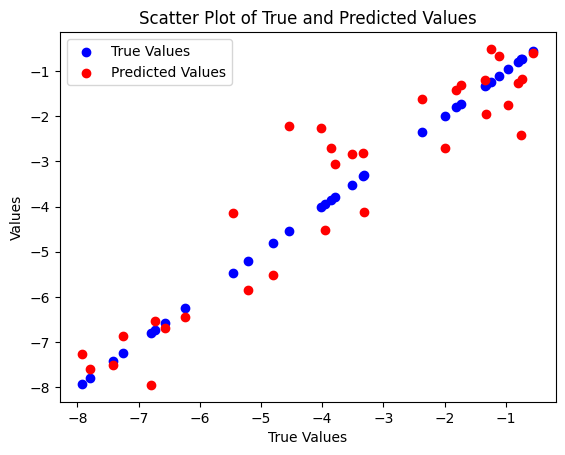

In [123]:
plt.scatter(y, y, c='blue', label='True Values')
plt.scatter(y, yhat, c='red', label='Predicted Values')

plt.xlabel('True Values')
plt.ylabel('Values')
plt.title('Scatter Plot of True and Predicted Values')
plt.legend()
plt.show()

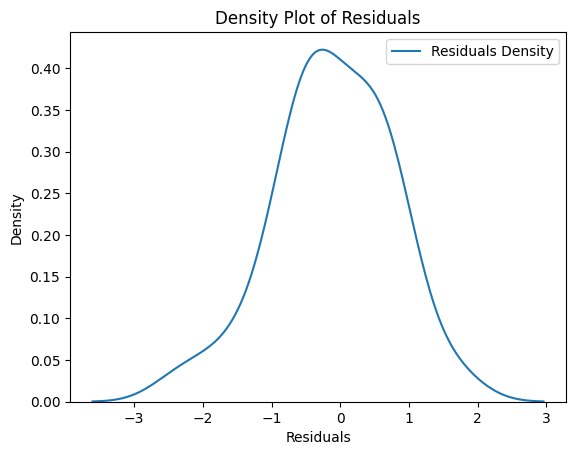

In [124]:
import seaborn as sns

residuals = y - yhat

sns.kdeplot(residuals, label='Residuals Density')
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.title('Density Plot of Residuals')
plt.legend()
plt.show()

In [131]:
def viasualize_attentions(path, smiles_string):

    config = RobertaConfig(
        vocab_size = 600,
        max_position_embeddings = 515,
        num_attention_heads = 6,
        num_hidden_layers = 6,
        type_vocab_size = 515,
        num_labels = 1,
        is_gpu = True,
        num_outputs = 1,
        position_embedding_type = 'random',
        output_attentions = True, 
        is_classification = False
    )
    model = RobertaForRegression(config)

    model.roberta.load_state_dict(torch.load(path))

    len_to_consider = len(smiles_string)
    data = smiles_tokenizer(smiles, add_special_tokens = True, truncation = True, padding = "max_length", max_length=515)
    x = torch.tensor(data['input_ids'])[None]

    attns = model.roberta(x)[-1][0]
    attns = attns[:, :, :len_to_consider, :len_to_consider]
    tokens = smiles_tokenizer.convert_ids_to_tokens(x[0]) 
    tokens = tokens[0:len_to_consider]
    head_view([attns], tokens)



In [135]:
viasualize_attentions('models/delaney_finetuned_roberta_v2.pth', 'ClCC(Cl)(Cl)Cl')

<IPython.core.display.Javascript object>

# Method Verification

In [ ]:
!ls chem_datasets/

250k_rndm_zinc_drugs_clean_3_latentVars.csv
250k_rndm_zinc_drugs_clean_3_shortListDescriptors.csv
bace_classification_anton_cleaned.csv
bace_classification_anton.csv
bace.csv
bace_reg_cleaned.csv
bace_regression_anton.csv
bbbp_cleaned.csv
bbbp.csv
clearance_cleaned.csv
clearance.csv
clintox_anton.csv
clintox_cleaned.csv
data_HLM_DOD.csv
data_PAMPA7_4.csv
data_PAMPA7_4_input.csv
data_PgpInh_DOD_SALI_lt20_2191.csv
dataset-delaney.csv
dataset-delaney-smiEd_latentVars.csv
delaney_mtr.csv
delany_mtr_normalized.csv
lipo_cleaned.csv
lipo.csv
mtr_10.csv
mtr_10_normalized.csv
mtr_clean_norm_zink.csv
mtr_normalized_top_10_cleaned.csv
smiles_cas_N6512_icmSmiles.csv
SR_p53_clnd.csv
zinc_top_10.csv
zinc_top_10_normalized.csv
zink_latent_vars_normalized.csv


In [ ]:
df = pd.read_csv('chem_datasets/delaney_mtr.csv')

In [ ]:
df.head()

,MinAbsPartialCharge,MaxAbsPartialCharge,BalabanJ,MolLogP,BCUT2D_MWLOW,MinPartialCharge,PEOE_VSA13,SMR_VSA10,BCUT2D_MRLOW,MaxEStateIndex,...,fr_nitro,MinEStateIndex,fr_furan,NumSaturatedRings,Chi0v,fr_benzodiazepine,fr_Ar_N,EState_VSA3,TPSA,smiles_charged
0,0.122063,0.203436,3.168490,2.5954,10.928780,-0.122063,0.0,46.40376,1.279550,5.116512,...,0,-1.276235,0,0,5.742680,0,0,0.000000,0.0,ClCC(Cl)(Cl)Cl
1,0.084013,0.187382,3.023716,2.3765,10.948044,-0.084013,0.0,34.80282,1.268178,5.060957,...,0,-1.083333,0,0,4.901680,0,0,0.000000,0.0,CC(Cl)(Cl)Cl
2,0.102365,0.137344,2.993497,2.5938,10.929605,-0.102365,0.0,46.40376,1.293168,5.114198,...,0,-0.672840,0,0,5.690274,0,0,0.000000,0.0,ClC(Cl)C(Cl)Cl
3,0.120829,0.123772,2.539539,2.0289,10.949696,-0.123772,0.0,34.80282,1.398333,5.095679,...,0,-0.405864,0,0,4.686137,0,0,5.880003,0.0,ClCC(Cl)Cl
4,0.199489,0.382976,4.020392,2.9189,10.767629,-0.199489,0.0,34.80282,0.024089,11.544753,...,0,-4.226080,0,0,5.535574,0,0,0.000000,0.0,FC(F)(Cl)C(F)(Cl)Cl


In [ ]:
label_cols = ['MinAbsPartialCharge', 'MaxAbsPartialCharge', 'BalabanJ',
       'MolLogP', 'BCUT2D_MWLOW', 'MinPartialCharge', 'PEOE_VSA13', 'SMR_VSA10', 'BCUT2D_MRLOW', 'MaxEStateIndex'] 

In [ ]:
ds = RegressionDataset(tokenizer = smiles_tokenizer, file_path = 'chem_datasets/delaney_mtr.csv', block_size = 515, x_col = "smiles_charged", y_col = label_cols)
train_ds, valid_ds = random_split(ds, lengths= (int(len(df)*0.8), len(df) - int(len(df)*0.8)))
train_loader = DataLoader(train_ds, batch_size = 32, shuffle = True)
valid_loader = DataLoader(valid_ds, batch_size = 32, shuffle = True)

config = RobertaConfig(
        vocab_size = 600,
        max_position_embeddings = 515,
        num_attention_heads = 6,
        num_hidden_layers = 6,
        type_vocab_size = 515,
        num_labels = 1,
        is_gpu = True,
        num_outputs = len(label_cols),
        position_embedding_type = 'random'
    )
model = RobertaForRegression(config)

Using custom data configuration default


init dataset
Loaded Dataset
Number of lines: 1144
Block size: 515


In [ ]:
wandb.init(project = "MTR - Method Verification - Old Loss Calculation")

In [ ]:
device = torch.device('cuda')
model.to(device)

In [ ]:
model.do_norm

False

In [ ]:
model.freeze_unfreeze()

In [ ]:
dd = next(iter(train_loader))

In [ ]:
x, y = dd['input_ids'].to(device), dd['label'].to(device)

In [ ]:
yhat = model(x)

In [ ]:
yhat

In [ ]:
model.freeze_unfreeze()

In [ ]:
train_regression(model, train_dataloader = train_loader, val_dataloader = valid_loader, learning_rate = 6e-06, epochs = 10, wd = 1e-01)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:04<00:00,  6.44it/s]


Epochs: 1 | Train Loss:  729.862             | Val Loss:  674.207


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:04<00:00,  6.41it/s]


Epochs: 2 | Train Loss:  727.328             | Val Loss:  656.529


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:04<00:00,  6.41it/s]


Epochs: 3 | Train Loss:  693.791             | Val Loss:  634.164


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:04<00:00,  6.42it/s]


Epochs: 4 | Train Loss:  663.687             | Val Loss:  597.845


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:04<00:00,  6.41it/s]


Epochs: 5 | Train Loss:  641.768             | Val Loss:  537.125


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:04<00:00,  6.40it/s]


Epochs: 6 | Train Loss:  612.905             | Val Loss:  525.758


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:04<00:00,  6.39it/s]


Epochs: 7 | Train Loss:  581.932             | Val Loss:  534.885


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:04<00:00,  6.38it/s]


Epochs: 8 | Train Loss:  571.076             | Val Loss:  531.394


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:04<00:00,  6.37it/s]


Epochs: 9 | Train Loss:  563.595             | Val Loss:  509.410


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:04<00:00,  6.37it/s]


Epochs: 10 | Train Loss:  573.798             | Val Loss:  504.589


In [ ]:
train_regression(model, train_dataloader = train_loader, val_dataloader = valid_loader, learning_rate = 1e-04, epochs = 15, wd = 1e-01)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:04<00:00,  6.38it/s]


Epochs: 1 | Train Loss:  560.492             | Val Loss:  475.870


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:04<00:00,  6.34it/s]


Epochs: 2 | Train Loss:  500.477             | Val Loss:  412.402


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:04<00:00,  6.40it/s]


Epochs: 3 | Train Loss:  402.171             | Val Loss:  328.755


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:04<00:00,  6.42it/s]


Epochs: 4 | Train Loss:  350.608             | Val Loss:  324.509


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:04<00:00,  6.42it/s]


Epochs: 5 | Train Loss:  348.769             | Val Loss:  330.088


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:04<00:00,  6.37it/s]


Epochs: 6 | Train Loss:  350.225             | Val Loss:  327.275


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:04<00:00,  6.37it/s]


Epochs: 7 | Train Loss:  348.728             | Val Loss:  308.377


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:04<00:00,  6.32it/s]


Epochs: 8 | Train Loss:  350.264             | Val Loss:  319.822


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:04<00:00,  6.42it/s]


Epochs: 9 | Train Loss:  346.090             | Val Loss:  327.900


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:04<00:00,  6.42it/s]


Epochs: 10 | Train Loss:  349.496             | Val Loss:  328.602


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:04<00:00,  6.42it/s]


Epochs: 11 | Train Loss:  346.548             | Val Loss:  325.186


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:04<00:00,  6.42it/s]


Epochs: 12 | Train Loss:  344.947             | Val Loss:  325.611


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:04<00:00,  6.42it/s]


Epochs: 13 | Train Loss:  349.958             | Val Loss:  327.470


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:04<00:00,  6.42it/s]


Epochs: 14 | Train Loss:  341.837             | Val Loss:  325.772


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:04<00:00,  6.41it/s]


Epochs: 15 | Train Loss:  347.796             | Val Loss:  323.149


In [ ]:
train_regression(model, train_dataloader = train_loader, val_dataloader = valid_loader, learning_rate = 5e-06, epochs = 5, wd = 1e-01)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:04<00:00,  6.42it/s]


Epochs: 1 | Train Loss:  341.579             | Val Loss:  326.973


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:04<00:00,  6.42it/s]


Epochs: 2 | Train Loss:  349.368             | Val Loss:  326.960


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:04<00:00,  6.42it/s]


Epochs: 3 | Train Loss:  349.561             | Val Loss:  328.801


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:04<00:00,  6.41it/s]


Epochs: 4 | Train Loss:  342.728             | Val Loss:  327.247


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:04<00:00,  6.41it/s]


Epochs: 5 | Train Loss:  346.349             | Val Loss:  322.558


In [ ]:
model.freeze_unfreeze('u')
train_regression(model, train_dataloader = train_loader, val_dataloader = valid_loader, learning_rate = 5e-06, epochs = 20, wd = 1e-02)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:11<00:00,  2.63it/s]


Epochs: 1 | Train Loss:  350.197             | Val Loss:  326.452


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:11<00:00,  2.63it/s]


Epochs: 2 | Train Loss:  345.086             | Val Loss:  322.898


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:11<00:00,  2.63it/s]


Epochs: 3 | Train Loss:  339.593             | Val Loss:  326.054


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:11<00:00,  2.63it/s]


Epochs: 4 | Train Loss:  343.232             | Val Loss:  325.415


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:11<00:00,  2.61it/s]


Epochs: 5 | Train Loss:  344.053             | Val Loss:  323.056


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:11<00:00,  2.62it/s]


Epochs: 6 | Train Loss:  344.044             | Val Loss:  324.283


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:11<00:00,  2.62it/s]


Epochs: 7 | Train Loss:  336.126             | Val Loss:  310.952


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:11<00:00,  2.62it/s]


Epochs: 8 | Train Loss:  319.889             | Val Loss:  285.040


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:11<00:00,  2.60it/s]


Epochs: 9 | Train Loss:  293.443             | Val Loss:  275.092


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:11<00:00,  2.62it/s]


Epochs: 10 | Train Loss:  280.780             | Val Loss:  272.676


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:11<00:00,  2.62it/s]


Epochs: 11 | Train Loss:  279.275             | Val Loss:  256.249


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:11<00:00,  2.62it/s]


Epochs: 12 | Train Loss:  263.261             | Val Loss:  263.976


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:11<00:00,  2.61it/s]


Epochs: 13 | Train Loss:  267.831             | Val Loss:  264.540


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:11<00:00,  2.61it/s]


Epochs: 14 | Train Loss:  267.796             | Val Loss:  261.766


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:11<00:00,  2.62it/s]


Epochs: 15 | Train Loss:  269.083             | Val Loss:  256.872


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:11<00:00,  2.62it/s]


Epochs: 16 | Train Loss:  263.822             | Val Loss:  259.473


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:11<00:00,  2.61it/s]


Epochs: 17 | Train Loss:  258.333             | Val Loss:  254.626


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:11<00:00,  2.61it/s]


Epochs: 18 | Train Loss:  263.100             | Val Loss:  258.983


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:11<00:00,  2.62it/s]


Epochs: 19 | Train Loss:  262.877             | Val Loss:  256.590


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:11<00:00,  2.61it/s]


Epochs: 20 | Train Loss:  258.143             | Val Loss:  256.201


In [ ]:
train_regression(model, train_dataloader = train_loader, val_dataloader = valid_loader, learning_rate = 1e-05, epochs = 2, wd = 1e-01)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.65it/s]


Epochs: 1 | Train Loss:  264.609             | Val Loss:  263.795


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.64it/s]


Epochs: 2 | Train Loss:  259.325             | Val Loss:  253.747


In [ ]:
train_regression(model, train_dataloader = train_loader, val_dataloader = valid_loader, learning_rate = 1e-06, epochs = 15, wd = 1e-02)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.64it/s]


Epochs: 1 | Train Loss:  254.299             | Val Loss:  247.081


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.64it/s]


Epochs: 2 | Train Loss:  261.728             | Val Loss:  251.772


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:11<00:00,  2.63it/s]


Epochs: 3 | Train Loss:  258.927             | Val Loss:  253.045


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:11<00:00,  2.63it/s]


Epochs: 4 | Train Loss:  254.694             | Val Loss:  251.982


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:11<00:00,  2.63it/s]


Epochs: 5 | Train Loss:  258.746             | Val Loss:  248.018


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:11<00:00,  2.63it/s]


Epochs: 6 | Train Loss:  254.419             | Val Loss:  244.373


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:11<00:00,  2.62it/s]


Epochs: 7 | Train Loss:  258.655             | Val Loss:  252.812


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:11<00:00,  2.63it/s]


Epochs: 8 | Train Loss:  255.556             | Val Loss:  254.047


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:11<00:00,  2.63it/s]


Epochs: 9 | Train Loss:  257.305             | Val Loss:  244.751


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:11<00:00,  2.63it/s]


Epochs: 10 | Train Loss:  254.201             | Val Loss:  254.407


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:11<00:00,  2.61it/s]


Epochs: 11 | Train Loss:  254.011             | Val Loss:  254.032


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:11<00:00,  2.62it/s]


Epochs: 12 | Train Loss:  253.909             | Val Loss:  251.478


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:11<00:00,  2.63it/s]


Epochs: 13 | Train Loss:  253.706             | Val Loss:  244.644


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:11<00:00,  2.63it/s]


Epochs: 14 | Train Loss:  248.316             | Val Loss:  252.028


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:11<00:00,  2.61it/s]


Epochs: 15 | Train Loss:  254.876             | Val Loss:  248.291


In [ ]:
torch.save(model.roberta.state_dict(), "./models/roberta_method_verification_old_loss.pth")

In [ ]:
df = pd.read_csv('chem_datasets/dataset-delaney.csv')
df.head()

,Compound ID,measured log(solubility:mol/L),ESOL predicted log(solubility:mol/L),SMILES
0,"1,1,1,2-Tetrachloroethane",-2.18,-2.794,ClCC(Cl)(Cl)Cl
1,"1,1,1-Trichloroethane",-2.00,-2.232,CC(Cl)(Cl)Cl
2,"1,1,2,2-Tetrachloroethane",-1.74,-2.549,ClC(Cl)C(Cl)Cl
3,"1,1,2-Trichloroethane",-1.48,-1.961,ClCC(Cl)Cl
4,"1,1,2-Trichlorotrifluoroethane",-3.04,-3.077,FC(F)(Cl)C(F)(Cl)Cl


In [ ]:
ds = RegressionDataset(tokenizer = smiles_tokenizer, file_path = 'chem_datasets/dataset-delaney.csv', block_size = 515, x_col = "SMILES", y_col = ['measured log(solubility:mol/L)'])
train_ds, valid_ds = random_split(ds, lengths= (int(len(df)*0.8), len(df) - int(len(df)*0.8)))
train_loader = DataLoader(train_ds, batch_size = 32, shuffle = True)
valid_loader = DataLoader(valid_ds, batch_size = 32, shuffle = True)

config = RobertaConfig(
        vocab_size = 600,
        max_position_embeddings = 515,
        num_attention_heads = 6,
        num_hidden_layers = 6,
        type_vocab_size = 515,
        num_labels = 1,
        is_gpu = True,
        num_outputs = len(label_cols),
        position_embedding_type = 'random'
    )
model = RobertaForRegression(config)

Using custom data configuration default


init dataset
Loaded Dataset
Number of lines: 1144
Block size: 515


In [ ]:
model.roberta.load_state_dict(torch.load("./models/roberta_method_verification_old_loss.pth"))

<All keys matched successfully>

In [ ]:
model.freeze_unfreeze()

In [ ]:
model.to(device)

In [ ]:
train_regression(model, train_dataloader = train_loader, val_dataloader = valid_loader, learning_rate = 1e-05, epochs = 5, wd = 1e-02)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:03<00:00,  7.27it/s]


Epochs: 1 | Train Loss:  13.590             | Val Loss:  12.844


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:03<00:00,  7.27it/s]


Epochs: 2 | Train Loss:  10.557             | Val Loss:  8.768


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:03<00:00,  7.30it/s]


Epochs: 3 | Train Loss:  7.143             | Val Loss:  6.348


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:03<00:00,  7.30it/s]


Epochs: 4 | Train Loss:  5.554             | Val Loss:  5.300


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:03<00:00,  7.25it/s]


Epochs: 5 | Train Loss:  5.084             | Val Loss:  5.221


In [ ]:
train_regression(model, train_dataloader = train_loader, val_dataloader = valid_loader, learning_rate = 5e-06, epochs = 5, wd = 1e-01)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:03<00:00,  7.29it/s]


Epochs: 1 | Train Loss:  4.850             | Val Loss:  4.972


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:03<00:00,  7.37it/s]


Epochs: 2 | Train Loss:  4.411             | Val Loss:  4.166


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:03<00:00,  7.33it/s]


Epochs: 3 | Train Loss:  3.810             | Val Loss:  3.667


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:03<00:00,  7.32it/s]


Epochs: 4 | Train Loss:  3.643             | Val Loss:  3.664


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:03<00:00,  7.30it/s]


Epochs: 5 | Train Loss:  3.589             | Val Loss:  3.676


In [ ]:
model.freeze_unfreeze('u')
train_regression(model, train_dataloader = train_loader, val_dataloader = valid_loader, learning_rate = 4e-06, epochs = 15, wd = 1e-02)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.81it/s]


Epochs: 1 | Train Loss:  3.557             | Val Loss:  3.350


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.80it/s]


Epochs: 2 | Train Loss:  3.338             | Val Loss:  3.097


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.80it/s]


Epochs: 3 | Train Loss:  2.978             | Val Loss:  2.842


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.79it/s]


Epochs: 4 | Train Loss:  2.871             | Val Loss:  2.683


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.80it/s]


Epochs: 5 | Train Loss:  2.834             | Val Loss:  2.767


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.80it/s]


Epochs: 6 | Train Loss:  2.710             | Val Loss:  2.529


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.80it/s]


Epochs: 7 | Train Loss:  2.714             | Val Loss:  2.472


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.80it/s]


Epochs: 8 | Train Loss:  2.698             | Val Loss:  2.416


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.80it/s]


Epochs: 9 | Train Loss:  2.607             | Val Loss:  2.451


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.80it/s]


Epochs: 10 | Train Loss:  2.602             | Val Loss:  2.414


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.80it/s]


Epochs: 11 | Train Loss:  2.475             | Val Loss:  2.335


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.79it/s]


Epochs: 12 | Train Loss:  2.479             | Val Loss:  2.358


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.80it/s]


Epochs: 13 | Train Loss:  2.418             | Val Loss:  2.274


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.80it/s]


Epochs: 14 | Train Loss:  2.383             | Val Loss:  2.124


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.80it/s]


Epochs: 15 | Train Loss:  2.429             | Val Loss:  2.228


In [ ]:
train_regression(model, train_dataloader = train_loader, val_dataloader = valid_loader, learning_rate = 1e-05, epochs = 2, wd = 1e-02)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.81it/s]


Epochs: 1 | Train Loss:  2.404             | Val Loss:  2.263


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.80it/s]


Epochs: 2 | Train Loss:  2.083             | Val Loss:  1.801


In [ ]:
train_regression(model, train_dataloader = train_loader, val_dataloader = valid_loader, learning_rate = 1e-06, epochs = 20, wd = 1e-02)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.80it/s]


Epochs: 1 | Train Loss:  1.938             | Val Loss:  1.844


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.80it/s]


Epochs: 2 | Train Loss:  1.898             | Val Loss:  1.867


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.80it/s]


Epochs: 3 | Train Loss:  1.919             | Val Loss:  1.711


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.80it/s]


Epochs: 4 | Train Loss:  1.844             | Val Loss:  1.699


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.80it/s]


Epochs: 5 | Train Loss:  1.820             | Val Loss:  1.586


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.80it/s]


Epochs: 6 | Train Loss:  1.752             | Val Loss:  1.537


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.79it/s]


Epochs: 7 | Train Loss:  1.689             | Val Loss:  1.467


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.80it/s]


Epochs: 8 | Train Loss:  1.564             | Val Loss:  1.464


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.79it/s]


Epochs: 9 | Train Loss:  1.570             | Val Loss:  1.224


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.80it/s]


Epochs: 10 | Train Loss:  1.495             | Val Loss:  1.280


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.78it/s]


Epochs: 11 | Train Loss:  1.407             | Val Loss:  1.335


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.80it/s]


Epochs: 12 | Train Loss:  1.407             | Val Loss:  1.183


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.80it/s]


Epochs: 13 | Train Loss:  1.350             | Val Loss:  1.209


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.80it/s]


Epochs: 14 | Train Loss:  1.365             | Val Loss:  1.199


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.79it/s]


Epochs: 15 | Train Loss:  1.347             | Val Loss:  1.187


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.80it/s]


Epochs: 16 | Train Loss:  1.336             | Val Loss:  1.177


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.80it/s]


Epochs: 17 | Train Loss:  1.360             | Val Loss:  1.149


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.80it/s]


Epochs: 18 | Train Loss:  1.368             | Val Loss:  1.223


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.79it/s]


Epochs: 19 | Train Loss:  1.339             | Val Loss:  1.225


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.79it/s]


Epochs: 20 | Train Loss:  1.321             | Val Loss:  1.190


In [ ]:
train_regression(model, train_dataloader = train_loader, val_dataloader = valid_loader, learning_rate = 1e-05, epochs = 3, wd = 1e-01)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.81it/s]


Epochs: 1 | Train Loss:  1.401             | Val Loss:  1.136


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.81it/s]


Epochs: 2 | Train Loss:  1.261             | Val Loss:  0.994


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.80it/s]


Epochs: 3 | Train Loss:  1.195             | Val Loss:  1.000


In [ ]:
train_regression(model, train_dataloader = train_loader, val_dataloader = valid_loader, learning_rate = 5e-05, epochs = 10, wd = 1e-02)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.81it/s]


Epochs: 1 | Train Loss:  1.211             | Val Loss:  0.967


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.81it/s]


Epochs: 2 | Train Loss:  1.345             | Val Loss:  0.984


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.80it/s]


Epochs: 3 | Train Loss:  1.274             | Val Loss:  1.042


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.80it/s]


Epochs: 4 | Train Loss:  1.357             | Val Loss:  0.886


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.79it/s]


Epochs: 5 | Train Loss:  1.136             | Val Loss:  0.833


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.80it/s]


Epochs: 6 | Train Loss:  0.961             | Val Loss:  0.771


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.80it/s]


Epochs: 7 | Train Loss:  0.995             | Val Loss:  0.819


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.80it/s]


Epochs: 8 | Train Loss:  0.878             | Val Loss:  0.667


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.80it/s]


Epochs: 9 | Train Loss:  0.808             | Val Loss:  0.713


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.78it/s]


Epochs: 10 | Train Loss:  0.784             | Val Loss:  0.651


In [ ]:
train_regression(model, train_dataloader = train_loader, val_dataloader = valid_loader, learning_rate = 5e-06, epochs = 10, wd = 1e-02)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.81it/s]


Epochs: 1 | Train Loss:  0.765             | Val Loss:  0.613


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.80it/s]


Epochs: 2 | Train Loss:  0.779             | Val Loss:  0.614


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.80it/s]


Epochs: 3 | Train Loss:  0.753             | Val Loss:  0.671


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.80it/s]


Epochs: 4 | Train Loss:  0.765             | Val Loss:  0.618


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.80it/s]


Epochs: 5 | Train Loss:  0.749             | Val Loss:  0.624


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.80it/s]


Epochs: 6 | Train Loss:  0.762             | Val Loss:  0.774


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.79it/s]


Epochs: 7 | Train Loss:  0.760             | Val Loss:  0.659


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.80it/s]


Epochs: 8 | Train Loss:  0.744             | Val Loss:  0.667


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.80it/s]


Epochs: 9 | Train Loss:  0.738             | Val Loss:  0.653


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.80it/s]


Epochs: 10 | Train Loss:  0.721             | Val Loss:  0.623


In [ ]:
train_regression(model, train_dataloader = train_loader, val_dataloader = valid_loader, learning_rate = 1e-06, epochs = 10, wd = 1e-02)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.81it/s]


Epochs: 1 | Train Loss:  0.708             | Val Loss:  0.647


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.81it/s]


Epochs: 2 | Train Loss:  0.736             | Val Loss:  0.600


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.80it/s]


Epochs: 3 | Train Loss:  0.724             | Val Loss:  0.686


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.79it/s]


Epochs: 4 | Train Loss:  0.692             | Val Loss:  0.629


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.80it/s]


Epochs: 5 | Train Loss:  0.692             | Val Loss:  0.683


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.80it/s]


Epochs: 6 | Train Loss:  0.691             | Val Loss:  0.637


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.80it/s]


Epochs: 7 | Train Loss:  0.720             | Val Loss:  0.660


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.79it/s]


Epochs: 8 | Train Loss:  0.705             | Val Loss:  0.675


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.80it/s]


Epochs: 9 | Train Loss:  0.706             | Val Loss:  0.590


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.80it/s]


Epochs: 10 | Train Loss:  0.704             | Val Loss:  0.683


In [ ]:
train_regression(model, train_dataloader = train_loader, val_dataloader = valid_loader, learning_rate = 5e-05, epochs = 2, wd = 1e-02)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.81it/s]


Epochs: 1 | Train Loss:  0.995             | Val Loss:  0.657


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.81it/s]


Epochs: 2 | Train Loss:  0.884             | Val Loss:  0.714


In [ ]:
train_regression(model, train_dataloader = train_loader, val_dataloader = valid_loader, learning_rate = 1e-06, epochs = 10, wd = 1e-02)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.81it/s]


Epochs: 1 | Train Loss:  0.771             | Val Loss:  0.678


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.80it/s]


Epochs: 2 | Train Loss:  0.734             | Val Loss:  0.582


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.81it/s]


Epochs: 3 | Train Loss:  0.734             | Val Loss:  0.639


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.81it/s]


Epochs: 4 | Train Loss:  0.739             | Val Loss:  0.621


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.80it/s]


Epochs: 5 | Train Loss:  0.715             | Val Loss:  0.588


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.80it/s]


Epochs: 6 | Train Loss:  0.735             | Val Loss:  0.620


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.79it/s]


Epochs: 7 | Train Loss:  0.702             | Val Loss:  0.584


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.80it/s]


Epochs: 8 | Train Loss:  0.689             | Val Loss:  0.593


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.80it/s]


Epochs: 9 | Train Loss:  0.698             | Val Loss:  0.598


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.80it/s]


Epochs: 10 | Train Loss:  0.722             | Val Loss:  0.590


In [ ]:
torch.save(model.roberta.state_dict(), 'models/roberta_fine_tuned_no_norm.pth')

# Latent Variables exploration, pre training and fine tuning

In [ ]:
!ls chem_datasets/

250k_rndm_zinc_drugs_clean_3_latentVars.csv
250k_rndm_zinc_drugs_clean_3_shortListDescriptors.csv
bace_classification_anton_cleaned.csv
bace_classification_anton.csv
bace.csv
bace_reg_cleaned.csv
bace_regression_anton.csv
bbbp_cleaned.csv
bbbp.csv
clearance_cleaned.csv
clearance.csv
clintox_anton.csv
clintox_cleaned.csv
data_HLM_DOD.csv
data_PAMPA7_4.csv
data_PAMPA7_4_input.csv
data_PgpInh_DOD_SALI_lt20_2191.csv
dataset-delaney.csv
dataset-delaney-smiEd_latentVars.csv
delaney_mtr.csv
delany_latent_vars_normalized.csv
delany_mtr_normalized.csv
lipo_cleaned.csv
lipo.csv
mtr_10.csv
mtr_10_normalized.csv
mtr_clean_norm_zink.csv
mtr_normalized_top_10_cleaned.csv
smiles_cas_N6512_icmSmiles.csv
SR_p53_clnd.csv
zinc_top_10.csv
zinc_top_10_normalized.csv
zink_latent_vars_normalized.csv


In [ ]:
df = pd.read_csv('chem_datasets/dataset-delaney-smiEd_latentVars.csv')

In [ ]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,y,smiles
0,-0.404681,-1.426282,-3.846785,2.308749,0.465333,-0.131782,0.397761,1.162751,-1.110965,-0.512179,-1.245773,1.379202,-0.561520,-2.18,ClCC(Cl)(Cl)Cl
1,-1.343249,-2.248502,-2.921644,1.751809,0.107465,0.148327,0.512763,1.026216,-1.126259,-0.839391,-0.637683,1.465351,-0.754847,-2.00,CC(Cl)(Cl)Cl
2,-0.342876,-2.056024,-4.127134,1.628628,0.723745,-0.348499,1.440960,0.538935,-0.538321,0.429715,-2.392034,1.145697,-0.388387,-1.74,ClC(Cl)C(Cl)Cl
3,-2.117191,-1.457281,-3.065112,2.061820,-0.340315,-0.401238,0.417687,0.531057,-0.723712,0.262293,-1.484979,1.071856,-0.284055,-1.48,ClCC(Cl)Cl
4,-0.248416,0.052533,-2.729127,2.118109,1.113149,0.350479,0.097234,2.524862,-2.050190,-0.823970,-2.463063,-0.082608,-0.240732,-3.04,FC(F)(Cl)C(F)(Cl)Cl


In [ ]:
df.describe()

In [ ]:
wandb.init(project = "MTR - Latent Vars - Pre Train -  variable 3")

wandb: Currently logged in as: bindelapranay1997 (comp_chem). Use `wandb login --relogin` to force relogin


In [ ]:
label_cols = ["2"]
ds = RegressionDataset(tokenizer = smiles_tokenizer, file_path = 'chem_datasets/dataset-delaney-smiEd_latentVars.csv', block_size = 515, x_col = "smiles", y_col = label_cols)
train_ds, valid_ds = random_split(ds, lengths= (int(len(df)*0.8), len(df) - int(len(df)*0.8)))
train_loader = DataLoader(train_ds, batch_size = 32, shuffle = True)
valid_loader = DataLoader(valid_ds, batch_size = 32, shuffle = True)

config = RobertaConfig(
        vocab_size = 600,
        max_position_embeddings = 515,
        num_attention_heads = 6,
        num_hidden_layers = 6,
        type_vocab_size = 515,
        num_labels = 1,
        is_gpu = True,
        num_outputs = len(label_cols),
        position_embedding_type = 'random'
    )
model = RobertaForRegression(config)
model.to(device)
model.freeze_unfreeze()

Using custom data configuration default


init dataset
Loaded Dataset
Number of lines: 1144
Block size: 515


In [ ]:
ds[0]

In [ ]:
device = torch.device('cuda')

In [ ]:
model.to(device)
model.freeze_unfreeze()

In [ ]:
model

In [ ]:
for i in model.parameters():
  assert i.requires_grad == True

In [ ]:
train_regression(model, train_dataloader = train_loader, val_dataloader = valid_loader, learning_rate = 1e-02, epochs = 5, wd = 1e-02)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:04<00:00,  6.86it/s]


Epochs: 1 | Train Loss:  3.531             | Val Loss:  2.722


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:03<00:00,  7.37it/s]


Epochs: 2 | Train Loss:  3.460             | Val Loss:  2.755


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:03<00:00,  7.38it/s]


Epochs: 3 | Train Loss:  3.364             | Val Loss:  2.757


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:03<00:00,  7.37it/s]


Epochs: 4 | Train Loss:  3.321             | Val Loss:  2.931


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:03<00:00,  7.36it/s]


Epochs: 5 | Train Loss:  3.284             | Val Loss:  2.770


In [ ]:
model.freeze_unfreeze('u')

In [ ]:
train_regression(model, train_dataloader = train_loader, val_dataloader = valid_loader, learning_rate = 1e-05, epochs = 5, wd = 1e-02)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.86it/s]


Epochs: 1 | Train Loss:  3.312             | Val Loss:  2.805


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.85it/s]


Epochs: 2 | Train Loss:  3.332             | Val Loss:  2.785


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.84it/s]


Epochs: 3 | Train Loss:  3.310             | Val Loss:  2.818


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.83it/s]


Epochs: 4 | Train Loss:  3.263             | Val Loss:  2.818


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.83it/s]


Epochs: 5 | Train Loss:  3.282             | Val Loss:  2.745


In [ ]:
train_regression(model, train_dataloader = train_loader, val_dataloader = valid_loader, learning_rate = 1e-06, epochs = 5, wd = 1e-02)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.85it/s]


Epochs: 1 | Train Loss:  3.270             | Val Loss:  2.829


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.85it/s]


Epochs: 2 | Train Loss:  3.243             | Val Loss:  2.797


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.84it/s]


Epochs: 3 | Train Loss:  3.308             | Val Loss:  2.814


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.83it/s]


Epochs: 4 | Train Loss:  3.319             | Val Loss:  2.830


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.83it/s]


Epochs: 5 | Train Loss:  3.312             | Val Loss:  2.837


In [ ]:
label_cols = ["3"]
ds = RegressionDataset(tokenizer = smiles_tokenizer, file_path = 'chem_datasets/dataset-delaney-smiEd_latentVars.csv', block_size = 515, x_col = "smiles", y_col = label_cols)
train_ds, valid_ds = random_split(ds, lengths= (int(len(df)*0.8), len(df) - int(len(df)*0.8)))
train_loader = DataLoader(train_ds, batch_size = 32, shuffle = True)
valid_loader = DataLoader(valid_ds, batch_size = 32, shuffle = True)

config = RobertaConfig(
        vocab_size = 600,
        max_position_embeddings = 515,
        num_attention_heads = 6,
        num_hidden_layers = 6,
        type_vocab_size = 515,
        num_labels = 1,
        is_gpu = True,
        num_outputs = len(label_cols),
        position_embedding_type = 'random'
    )
model = RobertaForRegression(config)
model.to(device)
model.freeze_unfreeze()

init dataset


Using custom data configuration default


Loaded Dataset
Number of lines: 1144
Block size: 515


In [ ]:
train_regression(model, train_dataloader = train_loader, val_dataloader = valid_loader, learning_rate = 1e-03, epochs = 5, wd = 1e-02)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:03<00:00,  7.32it/s]


Epochs: 1 | Train Loss:  2.651             | Val Loss:  2.749


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:03<00:00,  7.33it/s]


Epochs: 2 | Train Loss:  2.822             | Val Loss:  2.526


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:03<00:00,  7.33it/s]


Epochs: 3 | Train Loss:  2.702             | Val Loss:  2.490


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:03<00:00,  7.32it/s]


Epochs: 4 | Train Loss:  2.689             | Val Loss:  2.541


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:03<00:00,  7.32it/s]


Epochs: 5 | Train Loss:  2.635             | Val Loss:  2.535


In [ ]:
model.freeze_unfreeze('u')
train_regression(model, train_dataloader = train_loader, val_dataloader = valid_loader, learning_rate = 1e-05, epochs = 5, wd = 1e-02)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.85it/s]


Epochs: 1 | Train Loss:  2.662             | Val Loss:  2.565


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.84it/s]


Epochs: 2 | Train Loss:  2.638             | Val Loss:  2.467


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.84it/s]


Epochs: 3 | Train Loss:  2.664             | Val Loss:  2.491


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.83it/s]


Epochs: 4 | Train Loss:  2.639             | Val Loss:  2.423


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.83it/s]


Epochs: 5 | Train Loss:  2.555             | Val Loss:  2.515


In [ ]:
label_cols = ["4"]
ds = RegressionDataset(tokenizer = smiles_tokenizer, file_path = 'chem_datasets/dataset-delaney-smiEd_latentVars.csv', block_size = 515, x_col = "smiles", y_col = label_cols)
train_ds, valid_ds = random_split(ds, lengths= (int(len(df)*0.8), len(df) - int(len(df)*0.8)))
train_loader = DataLoader(train_ds, batch_size = 32, shuffle = True)
valid_loader = DataLoader(valid_ds, batch_size = 32, shuffle = True)

config = RobertaConfig(
        vocab_size = 600,
        max_position_embeddings = 515,
        num_attention_heads = 6,
        num_hidden_layers = 6,
        type_vocab_size = 515,
        num_labels = 1,
        is_gpu = True,
        num_outputs = len(label_cols),
        position_embedding_type = 'random'
    )
model = RobertaForRegression(config)
model.to(device)
model.freeze_unfreeze()
train_regression(model, train_dataloader = train_loader, val_dataloader = valid_loader, learning_rate = 1e-03, epochs = 5, wd = 1e-02)

Using custom data configuration default


init dataset
Loaded Dataset
Number of lines: 1144
Block size: 515


In [ ]:
train_regression(model, train_dataloader = train_loader, val_dataloader = valid_loader, learning_rate = 1e-03, epochs = 5, wd = 1e-02)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:03<00:00,  7.35it/s]


Epochs: 1 | Train Loss:  2.292             | Val Loss:  1.827


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:03<00:00,  7.35it/s]


Epochs: 2 | Train Loss:  2.440             | Val Loss:  1.859


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:03<00:00,  7.35it/s]


Epochs: 3 | Train Loss:  2.453             | Val Loss:  1.925


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:03<00:00,  7.35it/s]


Epochs: 4 | Train Loss:  2.345             | Val Loss:  1.895


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:03<00:00,  7.34it/s]


Epochs: 5 | Train Loss:  2.275             | Val Loss:  1.776


In [ ]:
model.freeze_unfreeze('u')
train_regression(model, train_dataloader = train_loader, val_dataloader = valid_loader, learning_rate = 1e-05, epochs = 5, wd = 1e-02)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.85it/s]


Epochs: 1 | Train Loss:  2.300             | Val Loss:  1.808


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.84it/s]


Epochs: 2 | Train Loss:  2.277             | Val Loss:  1.818


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.84it/s]


Epochs: 3 | Train Loss:  2.267             | Val Loss:  1.819


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.83it/s]


Epochs: 4 | Train Loss:  2.257             | Val Loss:  1.804


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.83it/s]


Epochs: 5 | Train Loss:  2.148             | Val Loss:  1.727


In [ ]:
label_cols = ["5"]
ds = RegressionDataset(tokenizer = smiles_tokenizer, file_path = 'chem_datasets/dataset-delaney-smiEd_latentVars.csv', block_size = 515, x_col = "smiles", y_col = label_cols)
train_ds, valid_ds = random_split(ds, lengths= (int(len(df)*0.8), len(df) - int(len(df)*0.8)))
train_loader = DataLoader(train_ds, batch_size = 32, shuffle = True)
valid_loader = DataLoader(valid_ds, batch_size = 32, shuffle = True)

config = RobertaConfig(
        vocab_size = 600,
        max_position_embeddings = 515,
        num_attention_heads = 6,
        num_hidden_layers = 6,
        type_vocab_size = 515,
        num_labels = 1,
        is_gpu = True,
        num_outputs = len(label_cols),
        position_embedding_type = 'random'
    )
model = RobertaForRegression(config)
model.to(device)
model.freeze_unfreeze()
train_regression(model, train_dataloader = train_loader, val_dataloader = valid_loader, learning_rate = 1e-03, epochs = 5, wd = 1e-02)

init dataset


Using custom data configuration default


Loaded Dataset
Number of lines: 1144
Block size: 515


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:03<00:00,  7.27it/s]


Epochs: 1 | Train Loss:  2.467             | Val Loss:  2.326


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:03<00:00,  7.27it/s]


Epochs: 2 | Train Loss:  2.521             | Val Loss:  2.190


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:03<00:00,  7.31it/s]


Epochs: 3 | Train Loss:  2.468             | Val Loss:  2.217


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:03<00:00,  7.33it/s]


Epochs: 4 | Train Loss:  2.410             | Val Loss:  2.204


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:03<00:00,  7.31it/s]


Epochs: 5 | Train Loss:  2.360             | Val Loss:  2.154


In [ ]:
model.freeze_unfreeze('u')
train_regression(model, train_dataloader = train_loader, val_dataloader = valid_loader, learning_rate = 1e-05, epochs = 5, wd = 1e-02)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.85it/s]


Epochs: 1 | Train Loss:  2.374             | Val Loss:  2.169


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.84it/s]


Epochs: 2 | Train Loss:  2.343             | Val Loss:  2.097


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.83it/s]


Epochs: 3 | Train Loss:  2.099             | Val Loss:  1.570


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.83it/s]


Epochs: 4 | Train Loss:  1.686             | Val Loss:  1.610


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.83it/s]


Epochs: 5 | Train Loss:  1.672             | Val Loss:  1.567


In [ ]:
train_regression(model, train_dataloader = train_loader, val_dataloader = valid_loader, learning_rate = 5e-06, epochs = 15, wd = 1e-02)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.85it/s]


Epochs: 1 | Train Loss:  1.674             | Val Loss:  1.512


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.84it/s]


Epochs: 2 | Train Loss:  1.603             | Val Loss:  1.550


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.83it/s]


Epochs: 3 | Train Loss:  1.621             | Val Loss:  1.557


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.83it/s]


Epochs: 4 | Train Loss:  1.577             | Val Loss:  1.430


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.83it/s]


Epochs: 5 | Train Loss:  1.563             | Val Loss:  1.382


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.83it/s]


Epochs: 6 | Train Loss:  1.484             | Val Loss:  1.333


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.83it/s]


Epochs: 7 | Train Loss:  1.437             | Val Loss:  1.318


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.83it/s]


Epochs: 8 | Train Loss:  1.317             | Val Loss:  1.400


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.83it/s]


Epochs: 9 | Train Loss:  1.325             | Val Loss:  1.375


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.83it/s]


Epochs: 10 | Train Loss:  1.278             | Val Loss:  1.264


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.83it/s]


Epochs: 11 | Train Loss:  1.243             | Val Loss:  1.258


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.83it/s]


Epochs: 12 | Train Loss:  1.229             | Val Loss:  1.174


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.83it/s]


Epochs: 13 | Train Loss:  1.224             | Val Loss:  1.293


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.83it/s]


Epochs: 14 | Train Loss:  1.220             | Val Loss:  1.262


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.83it/s]


Epochs: 15 | Train Loss:  1.212             | Val Loss:  1.160


In [ ]:
train_regression(model, train_dataloader = train_loader, val_dataloader = valid_loader, learning_rate = 1e-06, epochs = 15, wd = 1e-02)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.86it/s]


Epochs: 1 | Train Loss:  1.228             | Val Loss:  1.242


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.84it/s]


Epochs: 2 | Train Loss:  1.233             | Val Loss:  1.228


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.83it/s]


Epochs: 3 | Train Loss:  1.250             | Val Loss:  1.232


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.83it/s]


Epochs: 4 | Train Loss:  1.216             | Val Loss:  1.253


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.82it/s]


Epochs: 5 | Train Loss:  1.193             | Val Loss:  1.275


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.83it/s]


Epochs: 6 | Train Loss:  1.215             | Val Loss:  1.258


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.83it/s]


Epochs: 7 | Train Loss:  1.212             | Val Loss:  1.252


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.83it/s]


Epochs: 8 | Train Loss:  1.200             | Val Loss:  1.225


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.81it/s]


Epochs: 9 | Train Loss:  1.225             | Val Loss:  1.232


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.82it/s]


Epochs: 10 | Train Loss:  1.200             | Val Loss:  1.210


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.82it/s]


Epochs: 11 | Train Loss:  1.185             | Val Loss:  1.238


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.82it/s]


Epochs: 12 | Train Loss:  1.181             | Val Loss:  1.233


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.83it/s]


Epochs: 13 | Train Loss:  1.171             | Val Loss:  1.170


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.82it/s]


Epochs: 14 | Train Loss:  1.188             | Val Loss:  1.199


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.83it/s]


Epochs: 15 | Train Loss:  1.187             | Val Loss:  1.250


In [ ]:
torch.save(model.roberta.state_dict(), 'models/roberta_pre_trained_var_5.pth')

In [ ]:
label_cols = ["6"]
ds = RegressionDataset(tokenizer = smiles_tokenizer, file_path = 'chem_datasets/dataset-delaney-smiEd_latentVars.csv', block_size = 515, x_col = "smiles", y_col = label_cols)
train_ds, valid_ds = random_split(ds, lengths= (int(len(df)*0.8), len(df) - int(len(df)*0.8)))
train_loader = DataLoader(train_ds, batch_size = 32, shuffle = True)
valid_loader = DataLoader(valid_ds, batch_size = 32, shuffle = True)

config = RobertaConfig(
        vocab_size = 600,
        max_position_embeddings = 515,
        num_attention_heads = 6,
        num_hidden_layers = 6,
        type_vocab_size = 515,
        num_labels = 1,
        is_gpu = True,
        num_outputs = len(label_cols),
        position_embedding_type = 'random'
    )
model = RobertaForRegression(config)
model.to(device)
model.freeze_unfreeze()
train_regression(model, train_dataloader = train_loader, val_dataloader = valid_loader, learning_rate = 1e-03, epochs = 5, wd = 1e-02)

Using custom data configuration default


init dataset
Loaded Dataset
Number of lines: 1144
Block size: 515


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:03<00:00,  7.38it/s]


Epochs: 1 | Train Loss:  1.468             | Val Loss:  1.888


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:03<00:00,  7.37it/s]


Epochs: 2 | Train Loss:  1.611             | Val Loss:  1.463


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:03<00:00,  7.37it/s]


Epochs: 3 | Train Loss:  1.445             | Val Loss:  1.449


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:03<00:00,  7.38it/s]


Epochs: 4 | Train Loss:  1.415             | Val Loss:  1.405


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:03<00:00,  7.35it/s]


Epochs: 5 | Train Loss:  1.394             | Val Loss:  1.365


In [ ]:
train_regression(model, train_dataloader = train_loader, val_dataloader = valid_loader, learning_rate = 1e-04, epochs = 5, wd = 1e-02)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:03<00:00,  7.36it/s]


Epochs: 1 | Train Loss:  1.389             | Val Loss:  1.434


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:03<00:00,  7.38it/s]


Epochs: 2 | Train Loss:  1.395             | Val Loss:  1.424


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:03<00:00,  7.35it/s]


Epochs: 3 | Train Loss:  1.406             | Val Loss:  1.446


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:03<00:00,  7.34it/s]


Epochs: 4 | Train Loss:  1.399             | Val Loss:  1.412


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:03<00:00,  7.33it/s]


Epochs: 5 | Train Loss:  1.371             | Val Loss:  1.435


In [ ]:
model.freeze_unfreeze('u')
train_regression(model, train_dataloader = train_loader, val_dataloader = valid_loader, learning_rate = 1e-05, epochs = 10, wd = 1e-02)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.84it/s]


Epochs: 1 | Train Loss:  1.410             | Val Loss:  1.414


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.84it/s]


Epochs: 2 | Train Loss:  1.400             | Val Loss:  1.429


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.83it/s]


Epochs: 3 | Train Loss:  1.405             | Val Loss:  1.453


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.83it/s]


Epochs: 4 | Train Loss:  1.379             | Val Loss:  1.307


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.79it/s]


Epochs: 5 | Train Loss:  1.308             | Val Loss:  1.322


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.83it/s]


Epochs: 6 | Train Loss:  1.264             | Val Loss:  1.287


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.81it/s]


Epochs: 7 | Train Loss:  1.242             | Val Loss:  1.287


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.83it/s]


Epochs: 8 | Train Loss:  1.226             | Val Loss:  1.213


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.83it/s]


Epochs: 9 | Train Loss:  1.211             | Val Loss:  1.289


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.83it/s]


Epochs: 10 | Train Loss:  1.215             | Val Loss:  1.273


<AxesSubplot:>

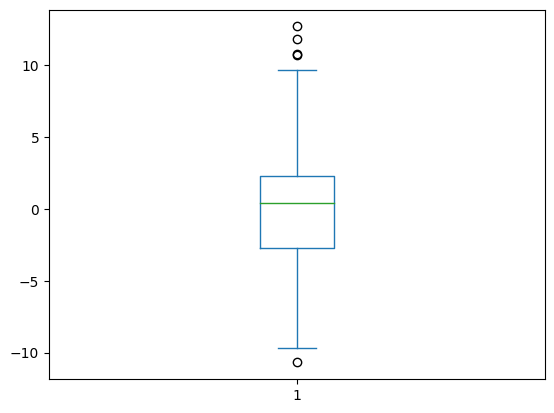

In [ ]:
df['1'].plot.box()

<AxesSubplot:>

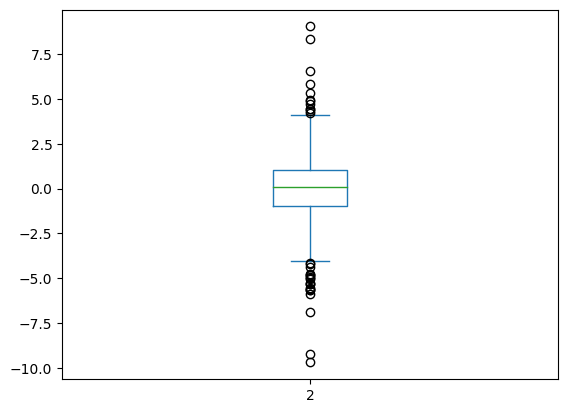

In [ ]:
df['2'].plot.box()

<AxesSubplot:>

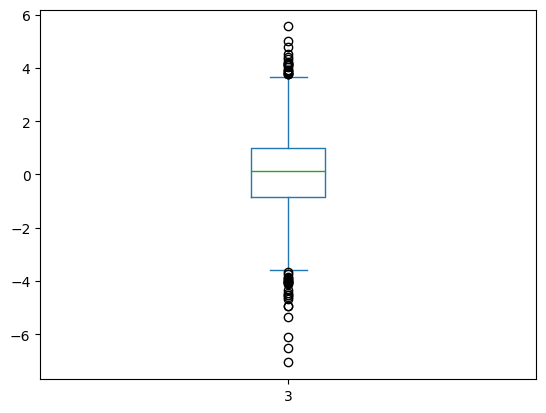

In [ ]:
df['3'].plot.box()

<AxesSubplot:>

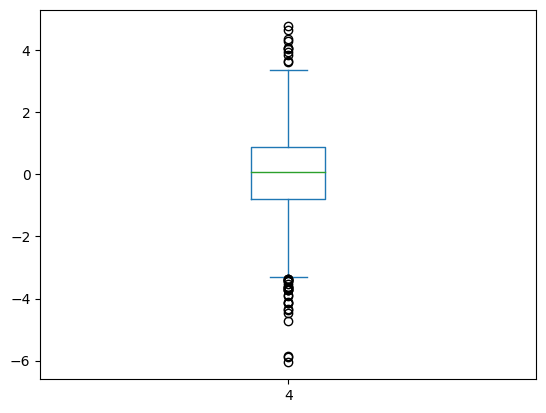

In [ ]:
df['4'].plot.box()

<AxesSubplot:>

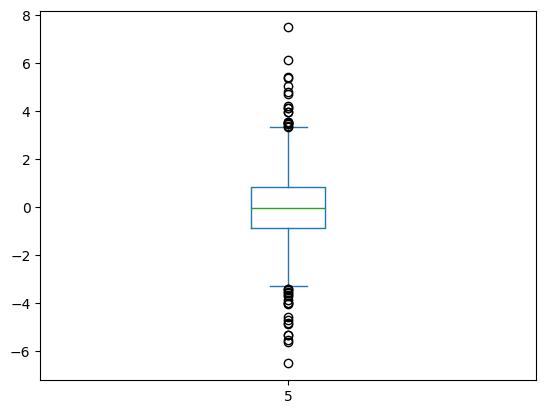

In [ ]:
df['5'].plot.box()

<AxesSubplot:>

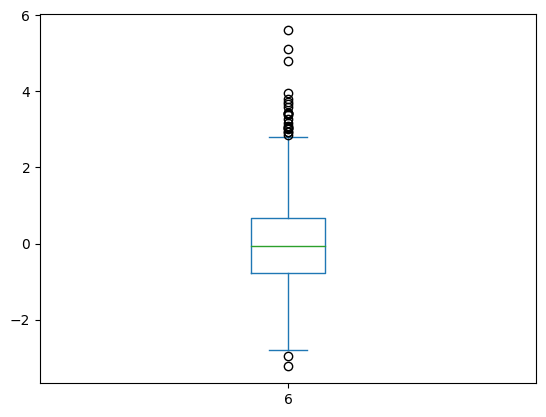

In [ ]:
df['6'].plot.box()

<AxesSubplot:>

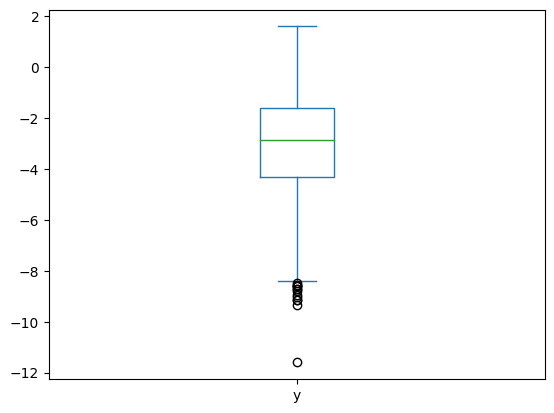

In [ ]:
df['y'].plot.box()

In [ ]:
!ls chem_datasets/

250k_rndm_zinc_drugs_clean_3_latentVars.csv
250k_rndm_zinc_drugs_clean_3_shortListDescriptors.csv
bace_classification_anton_cleaned.csv
bace_classification_anton.csv
bace.csv
bace_reg_cleaned.csv
bace_regression_anton.csv
bbbp_cleaned.csv
bbbp.csv
clearance_cleaned.csv
clearance.csv
clintox_anton.csv
clintox_cleaned.csv
data_HLM_DOD.csv
data_PAMPA7_4.csv
data_PAMPA7_4_input.csv
data_PgpInh_DOD_SALI_lt20_2191.csv
dataset-delaney.csv
dataset-delaney-smiEd_latentVars.csv
delaney_mtr.csv
delany_mtr_normalized.csv
lipo_cleaned.csv
lipo.csv
mtr_10.csv
mtr_10_normalized.csv
mtr_clean_norm_zink.csv
mtr_normalized_top_10_cleaned.csv
smiles_cas_N6512_icmSmiles.csv
SR_p53_clnd.csv
zinc_top_10.csv
zinc_top_10_normalized.csv
zink_latent_vars_normalized.csv


In [ ]:
ndf = pd.read_csv('chem_datasets/delaney_mtr.csv')

In [ ]:
ndf.head()

,MinAbsPartialCharge,MaxAbsPartialCharge,BalabanJ,MolLogP,BCUT2D_MWLOW,MinPartialCharge,PEOE_VSA13,SMR_VSA10,BCUT2D_MRLOW,MaxEStateIndex,...,fr_nitro,MinEStateIndex,fr_furan,NumSaturatedRings,Chi0v,fr_benzodiazepine,fr_Ar_N,EState_VSA3,TPSA,smiles_charged
0,0.122063,0.203436,3.168490,2.5954,10.928780,-0.122063,0.0,46.40376,1.279550,5.116512,...,0,-1.276235,0,0,5.742680,0,0,0.000000,0.0,ClCC(Cl)(Cl)Cl
1,0.084013,0.187382,3.023716,2.3765,10.948044,-0.084013,0.0,34.80282,1.268178,5.060957,...,0,-1.083333,0,0,4.901680,0,0,0.000000,0.0,CC(Cl)(Cl)Cl
2,0.102365,0.137344,2.993497,2.5938,10.929605,-0.102365,0.0,46.40376,1.293168,5.114198,...,0,-0.672840,0,0,5.690274,0,0,0.000000,0.0,ClC(Cl)C(Cl)Cl
3,0.120829,0.123772,2.539539,2.0289,10.949696,-0.123772,0.0,34.80282,1.398333,5.095679,...,0,-0.405864,0,0,4.686137,0,0,5.880003,0.0,ClCC(Cl)Cl
4,0.199489,0.382976,4.020392,2.9189,10.767629,-0.199489,0.0,34.80282,0.024089,11.544753,...,0,-4.226080,0,0,5.535574,0,0,0.000000,0.0,FC(F)(Cl)C(F)(Cl)Cl


<AxesSubplot:>

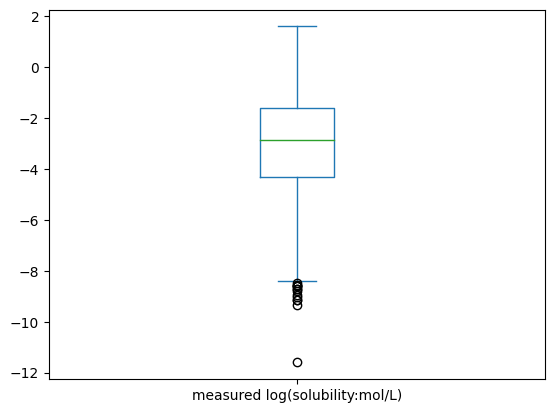

In [ ]:
ndf['measured log(solubility:mol/L)'].plot.box()

In [ ]:
df.columns[:-1]

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       'y'],
      dtype='object')

In [ ]:
corrs = {'pearson': [], "spearman": []}
for i in df.columns[:-1]:
    pearson_corr, _ = pearsonr(df[i], df['y'])
    corrs['pearson'].append(pearson_corr)

    spearman_corr, _ = spearmanr(df[i], df['y'])
    corrs['spearman'].append(spearman_corr)

In [ ]:
corrs

{'pearson': [-0.8517643601004444,
  0.3013549899095532,
  -0.2294090643426181,
  -0.14233245330821756,
  0.09732937553617355,
  0.07281437831361344,
  -0.06666877527634961,
  0.055105818380719714,
  -0.04023538305329084,
  -0.03595543224842019,
  0.027525456811218905,
  0.02316424977359149,
  -0.015151073708400428,
  1.0],
 'spearman': [-0.8534262760778385,
  0.18449166972647021,
  -0.3171506040974942,
  -0.12770332972091786,
  0.04854592146359818,
  0.13214971033265796,
  -0.0942205294812515,
  0.10591567829447668,
  -0.12566608491832937,
  -0.00360207052957306,
  0.008619985646565256,
  0.006973118234649662,
  -0.036129118409216704,
  1.0]}

In [ ]:
abs_charge_corrs = {'pearson': [], "spearman": []}
for i in df.columns[:-1]:
    pearson_corr, _ = pearsonr(df[i], ndf['MinAbsPartialCharge'])
    abs_charge_corrs['pearson'].append(pearson_corr)

    spearman_corr, _ = spearmanr(df[i], ndf['MinAbsPartialCharge'])
    abs_charge_corrs['spearman'].append(spearman_corr)

In [ ]:
abs_charge_corrs

{'pearson': [0.13181778974983135,
  0.7609775542108533,
  0.2450019341817667,
  0.186814642759087,
  0.19462056976665112,
  -0.1918979584817897,
  -0.0005883561670920908,
  -0.029260060084383994,
  0.08970604674939603,
  0.19253067361666448,
  0.05023013937113768,
  -0.05859040837022138,
  -0.08867300543452462,
  0.02827227259758752],
 'spearman': [0.16779762356464942,
  0.8109880960545002,
  0.21989311866208217,
  0.19881043219792174,
  0.24086232431796842,
  -0.16745287827869704,
  -0.035966385016281105,
  -0.11865623766059386,
  0.13101200085689516,
  0.19204234024345618,
  0.07808087374938331,
  -0.08442661571305496,
  -0.0766509053249674,
  0.0074807950199873]}

In [ ]:


pearson_corr, _ = pearsonr(ndf['BalabanJ'], ndf['MinAbsPartialCharge'])


spearman_corr, _ = spearmanr(ndf['BalabanJ'], ndf['MinAbsPartialCharge'])
print(pearson_corr, spearman_corr)

0.0531031589305323 0.03672218421061172


In [ ]:
BalabanJ_corrs = {'pearson': [], "spearman": []}
for i in df.columns[:-1]:
    pearson_corr, _ = pearsonr(df[i], ndf['BalabanJ'])
    BalabanJ_corrs['pearson'].append(pearson_corr)

    spearman_corr, _ = spearmanr(df[i], ndf['BalabanJ'])
    BalabanJ_corrs['spearman'].append(spearman_corr)

In [ ]:
ndf.columns

Index(['MinAbsPartialCharge', 'MaxAbsPartialCharge', 'BalabanJ', 'MolLogP',
       'BCUT2D_MWLOW', 'MinPartialCharge', 'PEOE_VSA13', 'SMR_VSA10',
       'BCUT2D_MRLOW', 'MaxEStateIndex', 'MaxAbsEStateIndex',
       'fr_alkyl_halide', 'BCUT2D_LOGPHI', 'SlogP_VSA10', 'fr_aniline',
       'EState_VSA11', 'SlogP_VSA11', 'FpDensityMorgan1', 'Kappa2',
       'BCUT2D_LOGPLOW', 'SlogP_VSA2', 'fr_Nhpyrrole', 'fr_Ar_NH', 'fr_ester',
       'PEOE_VSA2', 'FpDensityMorgan3', 'fr_imidazole', 'SlogP_VSA3',
       'PEOE_VSA6', 'PEOE_VSA8', 'SlogP_VSA8', 'fr_imide', 'EState_VSA2',
       'NumAromaticHeterocycles', 'fr_ether', 'SlogP_VSA5', 'SlogP_VSA7',
       'FpDensityMorgan2', 'VSA_EState10', 'fr_nitro_arom_nonortho',
       'EState_VSA5', 'HeavyAtomMolWt', 'BCUT2D_CHGHI', 'SMR_VSA3',
       'fr_aryl_methyl', 'PEOE_VSA9', 'MolWt', 'ExactMolWt',
       'NumAromaticCarbocycles', 'fr_benzene', 'fr_hdrzine', 'VSA_EState8',
       'MolMR', 'fr_halogen', 'PEOE_VSA12', 'FractionCSP3',
       'NumRotatableB

In [ ]:
raw_corrs = {'pearson': [], "spearman": []}
for i in ndf.columns[:10]:
    pearson_corr, _ = pearsonr(ndf[i], df['y'])
    raw_corrs['pearson'].append(pearson_corr)

    spearman_corr, _ = spearmanr(ndf[i], df['y'])
    raw_corrs['spearman'].append(spearman_corr)

In [ ]:
raw_corrs

{'pearson': [0.02827227259758752,
  0.28564669903760853,
  0.2204092818347323,
  -0.8196081877061087,
  0.4182743286407818,
  -0.283119534533712,
  -0.027705640333805414,
  -0.5238054230720727,
  -0.16993808073927216,
  0.08037322146559217],
 'spearman': [0.0074807950199873,
  0.22315183165422545,
  0.2676368534992566,
  -0.8325706660579417,
  0.48326491247975145,
  -0.2315578852928312,
  -0.04604035745710332,
  -0.4594102536010874,
  -0.11046153322917847,
  -0.05978548484588025]}

In [ ]:
label_cols = ["0"]
ds = RegressionDataset(tokenizer = smiles_tokenizer, file_path = 'chem_datasets/dataset-delaney-smiEd_latentVars.csv', block_size = 515, x_col = "smiles", y_col = label_cols)
train_ds, valid_ds = random_split(ds, lengths= (int(len(df)*0.8), len(df) - int(len(df)*0.8)))
train_loader = DataLoader(train_ds, batch_size = 32, shuffle = True)
valid_loader = DataLoader(valid_ds, batch_size = 32, shuffle = True)

config = RobertaConfig(
        vocab_size = 600,
        max_position_embeddings = 515,
        num_attention_heads = 6,
        num_hidden_layers = 6,
        type_vocab_size = 515,
        num_labels = 1,
        is_gpu = True,
        num_outputs = len(label_cols),
        position_embedding_type = 'random'
    )

model = RobertaForRegression(config)

Using custom data configuration default


init dataset
Loaded Dataset
Number of lines: 1144
Block size: 515


In [ ]:
train_ds[0]

In [ ]:
device = torch.device('cuda')

In [ ]:
model.freeze_unfreeze()

In [ ]:
TOKENIZERS_PARALLELISM = False

In [ ]:
model = model.to(device)
train_regression(model, train_dataloader = train_loader, val_dataloader = valid_loader, learning_rate = 1e-03, epochs = 5, wd = 1e-02)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:05<00:00,  5.02it/s]


Epochs: 1 | Train Loss:  12.648             | Val Loss:  15.628


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:03<00:00,  7.37it/s]


Epochs: 2 | Train Loss:  12.684             | Val Loss:  13.923


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:03<00:00,  7.38it/s]


Epochs: 3 | Train Loss:  12.295             | Val Loss:  13.910


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:03<00:00,  7.37it/s]


Epochs: 4 | Train Loss:  12.152             | Val Loss:  13.783


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:03<00:00,  7.36it/s]


Epochs: 5 | Train Loss:  12.060             | Val Loss:  13.561


In [ ]:
train_regression(model, train_dataloader = train_loader, val_dataloader = valid_loader, learning_rate = 1e-04, epochs = 5, wd = 1e-02)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:03<00:00,  7.36it/s]


Epochs: 1 | Train Loss:  12.144             | Val Loss:  13.868


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:03<00:00,  7.35it/s]


Epochs: 2 | Train Loss:  12.100             | Val Loss:  13.759


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:03<00:00,  7.34it/s]


Epochs: 3 | Train Loss:  12.118             | Val Loss:  13.919


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:03<00:00,  7.33it/s]


Epochs: 4 | Train Loss:  12.145             | Val Loss:  13.918


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:03<00:00,  7.31it/s]


Epochs: 5 | Train Loss:  12.027             | Val Loss:  14.019


In [ ]:
train_regression(model, train_dataloader = train_loader, val_dataloader = valid_loader, learning_rate = 1e-05, epochs = 5, wd = 1e-02)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:03<00:00,  7.38it/s]


Epochs: 1 | Train Loss:  11.952             | Val Loss:  13.789


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:03<00:00,  7.36it/s]


Epochs: 2 | Train Loss:  12.074             | Val Loss:  13.775


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:03<00:00,  7.34it/s]


Epochs: 3 | Train Loss:  11.976             | Val Loss:  13.749


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:03<00:00,  7.33it/s]


Epochs: 4 | Train Loss:  11.926             | Val Loss:  13.645


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:03<00:00,  7.33it/s]


Epochs: 5 | Train Loss:  11.983             | Val Loss:  13.944


In [ ]:
model.freeze_unfreeze('u')

In [ ]:
train_regression(model, train_dataloader = train_loader, val_dataloader = valid_loader, learning_rate = 1e-05, epochs = 5, wd = 1e-02)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.86it/s]


Epochs: 1 | Train Loss:  12.010             | Val Loss:  13.463


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.85it/s]


Epochs: 2 | Train Loss:  11.660             | Val Loss:  10.173


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.85it/s]


Epochs: 3 | Train Loss:  6.241             | Val Loss:  3.628


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.84it/s]


Epochs: 4 | Train Loss:  3.360             | Val Loss:  3.000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.84it/s]


Epochs: 5 | Train Loss:  3.107             | Val Loss:  2.831


In [ ]:
train_regression(model, train_dataloader = train_loader, val_dataloader = valid_loader, learning_rate = 5e-06, epochs = 5, wd = 1e-02)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.85it/s]


Epochs: 1 | Train Loss:  3.017             | Val Loss:  2.981


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.84it/s]


Epochs: 2 | Train Loss:  2.995             | Val Loss:  2.466


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.84it/s]


Epochs: 3 | Train Loss:  2.851             | Val Loss:  2.579


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.84it/s]


Epochs: 4 | Train Loss:  2.758             | Val Loss:  2.423


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.83it/s]


Epochs: 5 | Train Loss:  2.691             | Val Loss:  2.530


In [ ]:
train_regression(model, train_dataloader = train_loader, val_dataloader = valid_loader, learning_rate = 5e-06, epochs = 5, wd = 1e-02)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.84it/s]


Epochs: 1 | Train Loss:  2.651             | Val Loss:  2.737


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.84it/s]


Epochs: 2 | Train Loss:  2.611             | Val Loss:  2.235


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.83it/s]


Epochs: 3 | Train Loss:  2.608             | Val Loss:  2.486


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.83it/s]


Epochs: 4 | Train Loss:  2.628             | Val Loss:  2.291


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.84it/s]


Epochs: 5 | Train Loss:  2.373             | Val Loss:  2.165


In [ ]:
train_regression(model, train_dataloader = train_loader, val_dataloader = valid_loader, learning_rate = 1e-06, epochs = 10, wd = 1e-02)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.85it/s]


Epochs: 1 | Train Loss:  2.453             | Val Loss:  2.178


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.84it/s]


Epochs: 2 | Train Loss:  2.481             | Val Loss:  2.352


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.84it/s]


Epochs: 3 | Train Loss:  2.433             | Val Loss:  2.345


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.84it/s]


Epochs: 4 | Train Loss:  2.508             | Val Loss:  2.105


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.84it/s]


Epochs: 5 | Train Loss:  2.389             | Val Loss:  2.211


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.85it/s]


Epochs: 6 | Train Loss:  2.353             | Val Loss:  2.134


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.85it/s]


Epochs: 7 | Train Loss:  2.401             | Val Loss:  2.174


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.85it/s]


Epochs: 8 | Train Loss:  2.327             | Val Loss:  2.071


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.85it/s]


Epochs: 9 | Train Loss:  2.437             | Val Loss:  2.113


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.85it/s]


Epochs: 10 | Train Loss:  2.382             | Val Loss:  2.040


In [ ]:
torch.save(model.roberta.state_dict(), "./models/roberta_single_latent_variable_pre_train.pth")

In [ ]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,y,smiles
0,-0.404681,-1.426282,-3.846785,2.308749,0.465333,-0.131782,0.397761,1.162751,-1.110965,-0.512179,-1.245773,1.379202,-0.561520,-2.18,ClCC(Cl)(Cl)Cl
1,-1.343249,-2.248502,-2.921644,1.751809,0.107465,0.148327,0.512763,1.026216,-1.126259,-0.839391,-0.637683,1.465351,-0.754847,-2.00,CC(Cl)(Cl)Cl
2,-0.342876,-2.056024,-4.127134,1.628628,0.723745,-0.348499,1.440960,0.538935,-0.538321,0.429715,-2.392034,1.145697,-0.388387,-1.74,ClC(Cl)C(Cl)Cl
3,-2.117191,-1.457281,-3.065112,2.061820,-0.340315,-0.401238,0.417687,0.531057,-0.723712,0.262293,-1.484979,1.071856,-0.284055,-1.48,ClCC(Cl)Cl
4,-0.248416,0.052533,-2.729127,2.118109,1.113149,0.350479,0.097234,2.524862,-2.050190,-0.823970,-2.463063,-0.082608,-0.240732,-3.04,FC(F)(Cl)C(F)(Cl)Cl


In [ ]:
label_cols = ["y"]
ds = RegressionDataset(tokenizer = smiles_tokenizer, file_path = 'chem_datasets/dataset-delaney-smiEd_latentVars.csv', block_size = 515, x_col = "smiles", y_col = label_cols)
train_ds, valid_ds = random_split(ds, lengths= (int(len(df)*0.8), len(df) - int(len(df)*0.8)))
train_loader = DataLoader(train_ds, batch_size = 32, shuffle = True)
valid_loader = DataLoader(valid_ds, batch_size = 32, shuffle = True)

config = RobertaConfig(
        vocab_size = 600,
        max_position_embeddings = 515,
        num_attention_heads = 6,
        num_hidden_layers = 6,
        type_vocab_size = 515,
        num_labels = 1,
        is_gpu = True,
        num_outputs = len(label_cols),
        position_embedding_type = 'random'
    )

model = RobertaForRegression(config)

Using custom data configuration default


init dataset
Loaded Dataset
Number of lines: 1144
Block size: 515


In [ ]:
model.roberta.load_state_dict(torch.load("./models/roberta_single_latent_variable_pre_train.pth"))

<All keys matched successfully>

In [ ]:
model.to(device)
model.freeze_unfreeze()

In [ ]:
train_regression(model, train_dataloader = train_loader, val_dataloader = valid_loader, learning_rate = 1e-04, epochs = 10, wd = 1e-01)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:03<00:00,  7.31it/s]


Epochs: 1 | Train Loss:  11.718             | Val Loss:  7.849


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:03<00:00,  7.33it/s]


Epochs: 2 | Train Loss:  5.374             | Val Loss:  2.563


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:03<00:00,  7.32it/s]


Epochs: 3 | Train Loss:  2.350             | Val Loss:  1.710


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:03<00:00,  7.32it/s]


Epochs: 4 | Train Loss:  2.179             | Val Loss:  1.860


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:03<00:00,  7.32it/s]


Epochs: 5 | Train Loss:  2.127             | Val Loss:  1.766


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:03<00:00,  7.30it/s]


Epochs: 6 | Train Loss:  2.151             | Val Loss:  1.655


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:03<00:00,  7.30it/s]


Epochs: 7 | Train Loss:  2.083             | Val Loss:  1.799


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:03<00:00,  7.31it/s]


Epochs: 8 | Train Loss:  2.133             | Val Loss:  1.788


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:03<00:00,  7.32it/s]


Epochs: 9 | Train Loss:  2.080             | Val Loss:  1.775


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:03<00:00,  7.31it/s]


Epochs: 10 | Train Loss:  2.101             | Val Loss:  1.753


In [ ]:
model.freeze_unfreeze('u')
train_regression(model, train_dataloader = train_loader, val_dataloader = valid_loader, learning_rate = 1e-05, epochs = 2, wd = 1e-01)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.84it/s]


Epochs: 1 | Train Loss:  2.150             | Val Loss:  1.747


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.83it/s]


Epochs: 2 | Train Loss:  2.000             | Val Loss:  1.722


In [ ]:
train_regression(model, train_dataloader = train_loader, val_dataloader = valid_loader, learning_rate = 5e-06, epochs = 10, wd = 1e-02)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.84it/s]


Epochs: 1 | Train Loss:  2.004             | Val Loss:  1.603


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.84it/s]


Epochs: 2 | Train Loss:  1.998             | Val Loss:  1.668


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.84it/s]


Epochs: 3 | Train Loss:  1.942             | Val Loss:  1.621


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.83it/s]


Epochs: 4 | Train Loss:  1.870             | Val Loss:  1.458


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.83it/s]


Epochs: 5 | Train Loss:  1.844             | Val Loss:  1.504


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.83it/s]


Epochs: 6 | Train Loss:  1.730             | Val Loss:  1.452


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.83it/s]


Epochs: 7 | Train Loss:  1.630             | Val Loss:  1.289


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.83it/s]


Epochs: 8 | Train Loss:  1.534             | Val Loss:  1.182


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.83it/s]


Epochs: 9 | Train Loss:  1.439             | Val Loss:  1.158


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.83it/s]


Epochs: 10 | Train Loss:  1.448             | Val Loss:  1.190


In [ ]:
train_regression(model, train_dataloader = train_loader, val_dataloader = valid_loader, learning_rate = 2e-06, epochs = 10, wd = 1e-02)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.85it/s]


Epochs: 1 | Train Loss:  1.437             | Val Loss:  1.191


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.84it/s]


Epochs: 2 | Train Loss:  1.428             | Val Loss:  1.072


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.84it/s]


Epochs: 3 | Train Loss:  1.418             | Val Loss:  1.122


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.84it/s]


Epochs: 4 | Train Loss:  1.350             | Val Loss:  1.154


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.84it/s]


Epochs: 5 | Train Loss:  1.305             | Val Loss:  1.122


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.83it/s]


Epochs: 6 | Train Loss:  1.307             | Val Loss:  1.099


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.83it/s]


Epochs: 7 | Train Loss:  1.237             | Val Loss:  1.042


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.83it/s]


Epochs: 8 | Train Loss:  1.264             | Val Loss:  1.027


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.83it/s]


Epochs: 9 | Train Loss:  1.265             | Val Loss:  1.054


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.82it/s]


Epochs: 10 | Train Loss:  1.251             | Val Loss:  1.054


In [ ]:
train_regression(model, train_dataloader = train_loader, val_dataloader = valid_loader, learning_rate = 5e-05, epochs = 2, wd = 1e-01)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.84it/s]


Epochs: 1 | Train Loss:  1.621             | Val Loss:  1.438


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.83it/s]


Epochs: 2 | Train Loss:  1.316             | Val Loss:  0.940


In [ ]:
train_regression(model, train_dataloader = train_loader, val_dataloader = valid_loader, learning_rate = 5e-05, epochs = 2, wd = 1e-01)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.84it/s]


Epochs: 1 | Train Loss:  1.360             | Val Loss:  1.032


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.84it/s]


Epochs: 2 | Train Loss:  1.186             | Val Loss:  0.907


In [ ]:
train_regression(model, train_dataloader = train_loader, val_dataloader = valid_loader, learning_rate = 5e-06, epochs = 10, wd = 1e-02)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.84it/s]


Epochs: 1 | Train Loss:  0.981             | Val Loss:  0.845


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.83it/s]


Epochs: 2 | Train Loss:  1.026             | Val Loss:  0.915


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.83it/s]


Epochs: 3 | Train Loss:  0.977             | Val Loss:  0.830


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.83it/s]


Epochs: 4 | Train Loss:  0.990             | Val Loss:  0.825


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.83it/s]


Epochs: 5 | Train Loss:  1.009             | Val Loss:  0.811


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.82it/s]


Epochs: 6 | Train Loss:  0.936             | Val Loss:  0.762


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.83it/s]


Epochs: 7 | Train Loss:  0.910             | Val Loss:  0.744


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.83it/s]


Epochs: 8 | Train Loss:  0.907             | Val Loss:  0.742


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.83it/s]


Epochs: 9 | Train Loss:  0.897             | Val Loss:  0.725


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.83it/s]


Epochs: 10 | Train Loss:  0.892             | Val Loss:  0.724


In [ ]:
train_regression(model, train_dataloader = train_loader, val_dataloader = valid_loader, learning_rate = 1e-06, epochs = 10, wd = 1e-02)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.84it/s]


Epochs: 1 | Train Loss:  0.904             | Val Loss:  0.734


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.83it/s]


Epochs: 2 | Train Loss:  0.885             | Val Loss:  0.720


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.82it/s]


Epochs: 3 | Train Loss:  0.865             | Val Loss:  0.739


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.83it/s]


Epochs: 4 | Train Loss:  0.869             | Val Loss:  0.747


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.83it/s]


Epochs: 5 | Train Loss:  0.906             | Val Loss:  0.740


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.83it/s]


Epochs: 6 | Train Loss:  0.898             | Val Loss:  0.764


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.83it/s]


Epochs: 7 | Train Loss:  0.889             | Val Loss:  0.786


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.83it/s]


Epochs: 8 | Train Loss:  0.837             | Val Loss:  0.702


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.83it/s]


Epochs: 9 | Train Loss:  0.886             | Val Loss:  0.757


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.83it/s]


Epochs: 10 | Train Loss:  0.852             | Val Loss:  0.739


In [ ]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,y,smiles
0,-0.404681,-1.426282,-3.846785,2.308749,0.465333,-0.131782,0.397761,1.162751,-1.110965,-0.512179,-1.245773,1.379202,-0.561520,-2.18,ClCC(Cl)(Cl)Cl
1,-1.343249,-2.248502,-2.921644,1.751809,0.107465,0.148327,0.512763,1.026216,-1.126259,-0.839391,-0.637683,1.465351,-0.754847,-2.00,CC(Cl)(Cl)Cl
2,-0.342876,-2.056024,-4.127134,1.628628,0.723745,-0.348499,1.440960,0.538935,-0.538321,0.429715,-2.392034,1.145697,-0.388387,-1.74,ClC(Cl)C(Cl)Cl
3,-2.117191,-1.457281,-3.065112,2.061820,-0.340315,-0.401238,0.417687,0.531057,-0.723712,0.262293,-1.484979,1.071856,-0.284055,-1.48,ClCC(Cl)Cl
4,-0.248416,0.052533,-2.729127,2.118109,1.113149,0.350479,0.097234,2.524862,-2.050190,-0.823970,-2.463063,-0.082608,-0.240732,-3.04,FC(F)(Cl)C(F)(Cl)Cl


# With Two Variables - Most Co-related

In [ ]:
torch.save(model, 'models/roberta_finetuned_single__latent_variable_0_838.pth')

In [ ]:
label_cols = ["0", "1"]
ds = RegressionDataset(tokenizer = smiles_tokenizer, file_path = 'chem_datasets/dataset-delaney-smiEd_latentVars.csv', block_size = 515, x_col = "smiles", y_col = label_cols)
train_ds, valid_ds = random_split(ds, lengths= (int(len(df)*0.8), len(df) - int(len(df)*0.8)))
train_loader = DataLoader(train_ds, batch_size = 32, shuffle = True)
valid_loader = DataLoader(valid_ds, batch_size = 32, shuffle = True)

config = RobertaConfig(
        vocab_size = 600,
        max_position_embeddings = 515,
        num_attention_heads = 6,
        num_hidden_layers = 6,
        type_vocab_size = 515,
        num_labels = 1,
        is_gpu = True,
        num_outputs = len(label_cols),
        position_embedding_type = 'random'
    )

model = RobertaForRegression(config)

Using custom data configuration default


init dataset
Loaded Dataset
Number of lines: 1144
Block size: 515


In [ ]:
# model.roberta.load_state_dict(torch.load("./models/roberta_single_latent_variable_pre_train.pth"))
# torch.save(model.roberta.state_dict(), "./models/roberta_single_latent_variable_pre_train.pth")

In [ ]:
model.to(device)

In [ ]:
model.freeze_unfreeze()

In [ ]:
train_regression(model, train_dataloader = train_loader, val_dataloader = valid_loader, learning_rate = 1e-03, epochs = 5, wd = 1e-01)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:03<00:00,  7.37it/s]


Epochs: 1 | Train Loss:  25.050             | Val Loss:  25.606


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:03<00:00,  7.38it/s]


Epochs: 2 | Train Loss:  24.570             | Val Loss:  26.707


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:03<00:00,  7.35it/s]


Epochs: 3 | Train Loss:  24.873             | Val Loss:  25.433


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:03<00:00,  7.35it/s]


Epochs: 4 | Train Loss:  24.938             | Val Loss:  23.037


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:03<00:00,  7.35it/s]


Epochs: 5 | Train Loss:  24.487             | Val Loss:  25.044


In [ ]:
train_regression(model, train_dataloader = train_loader, val_dataloader = valid_loader, learning_rate = 1e-04, epochs = 10, wd = 1e-01)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:03<00:00,  7.37it/s]


Epochs: 1 | Train Loss:  24.231             | Val Loss:  24.727


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:03<00:00,  7.34it/s]


Epochs: 2 | Train Loss:  24.174             | Val Loss:  25.032


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:03<00:00,  7.32it/s]


Epochs: 3 | Train Loss:  24.135             | Val Loss:  24.551


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:03<00:00,  7.32it/s]


Epochs: 4 | Train Loss:  23.857             | Val Loss:  24.595


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:03<00:00,  7.31it/s]


Epochs: 5 | Train Loss:  24.023             | Val Loss:  22.957


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:03<00:00,  7.31it/s]


Epochs: 6 | Train Loss:  24.106             | Val Loss:  25.023


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:03<00:00,  7.31it/s]


Epochs: 7 | Train Loss:  23.556             | Val Loss:  23.793


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:03<00:00,  7.31it/s]


Epochs: 8 | Train Loss:  23.820             | Val Loss:  25.349


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:03<00:00,  7.32it/s]


Epochs: 9 | Train Loss:  23.705             | Val Loss:  24.656


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:03<00:00,  7.33it/s]


Epochs: 10 | Train Loss:  23.620             | Val Loss:  25.344


In [ ]:
train_regression(model, train_dataloader = train_loader, val_dataloader = valid_loader, learning_rate = 1e-05, epochs = 10, wd = 1e-02)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:03<00:00,  7.38it/s]


Epochs: 1 | Train Loss:  23.868             | Val Loss:  23.791


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:03<00:00,  7.34it/s]


Epochs: 2 | Train Loss:  23.924             | Val Loss:  24.625


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:03<00:00,  7.33it/s]


Epochs: 3 | Train Loss:  23.435             | Val Loss:  24.292


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:03<00:00,  7.32it/s]


Epochs: 4 | Train Loss:  23.650             | Val Loss:  24.379


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:03<00:00,  7.32it/s]


Epochs: 5 | Train Loss:  23.266             | Val Loss:  25.455


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:03<00:00,  7.32it/s]


Epochs: 6 | Train Loss:  23.622             | Val Loss:  25.021


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:03<00:00,  7.32it/s]


Epochs: 7 | Train Loss:  23.547             | Val Loss:  24.141


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:03<00:00,  7.31it/s]


Epochs: 8 | Train Loss:  23.379             | Val Loss:  25.205


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:03<00:00,  7.31it/s]


Epochs: 9 | Train Loss:  23.520             | Val Loss:  25.233


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:03<00:00,  7.31it/s]


Epochs: 10 | Train Loss:  23.874             | Val Loss:  24.454


**Not Working**

In [ ]:
label_cols = ["1"]
ds = RegressionDataset(tokenizer = smiles_tokenizer, file_path = 'chem_datasets/dataset-delaney-smiEd_latentVars.csv', block_size = 515, x_col = "smiles", y_col = label_cols)
train_ds, valid_ds = random_split(ds, lengths= (int(len(df)*0.8), len(df) - int(len(df)*0.8)))
train_loader = DataLoader(train_ds, batch_size = 32, shuffle = True)
valid_loader = DataLoader(valid_ds, batch_size = 32, shuffle = True)

config = RobertaConfig(
        vocab_size = 600,
        max_position_embeddings = 515,
        num_attention_heads = 6,
        num_hidden_layers = 6,
        type_vocab_size = 515,
        num_labels = 1,
        is_gpu = True,
        num_outputs = len(label_cols),
        position_embedding_type = 'random'
    )

model = RobertaForRegression(config)

Using custom data configuration default


init dataset
Loaded Dataset
Number of lines: 1144
Block size: 515


In [ ]:
model.to(device)
model.freeze_unfreeze()

In [ ]:
train_regression(model, train_dataloader = train_loader, val_dataloader = valid_loader, learning_rate = 1e-03, epochs = 5, wd = 1e-01)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:03<00:00,  7.38it/s]


Epochs: 1 | Train Loss:  11.012             | Val Loss:  11.575


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:03<00:00,  7.37it/s]


Epochs: 2 | Train Loss:  11.190             | Val Loss:  10.667


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:03<00:00,  7.33it/s]


Epochs: 3 | Train Loss:  10.901             | Val Loss:  11.014


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:03<00:00,  7.34it/s]


Epochs: 4 | Train Loss:  10.966             | Val Loss:  10.850


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:03<00:00,  7.35it/s]


Epochs: 5 | Train Loss:  10.726             | Val Loss:  10.769


In [ ]:
train_regression(model, train_dataloader = train_loader, val_dataloader = valid_loader, learning_rate = 1e-04, epochs = 5, wd = 1e-01)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:03<00:00,  7.35it/s]


Epochs: 1 | Train Loss:  10.762             | Val Loss:  10.828


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:03<00:00,  7.36it/s]


Epochs: 2 | Train Loss:  10.695             | Val Loss:  10.818


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:03<00:00,  7.35it/s]


Epochs: 3 | Train Loss:  10.546             | Val Loss:  10.895


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:03<00:00,  7.32it/s]


Epochs: 4 | Train Loss:  10.622             | Val Loss:  10.695


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:03<00:00,  7.33it/s]


Epochs: 5 | Train Loss:  10.771             | Val Loss:  10.636


In [ ]:
train_regression(model, train_dataloader = train_loader, val_dataloader = valid_loader, learning_rate = 1e-05, epochs = 10, wd = 1e-02)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:03<00:00,  7.39it/s]


Epochs: 1 | Train Loss:  10.560             | Val Loss:  10.646


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:03<00:00,  7.38it/s]


Epochs: 2 | Train Loss:  10.694             | Val Loss:  10.663


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:03<00:00,  7.36it/s]


Epochs: 3 | Train Loss:  10.654             | Val Loss:  10.705


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:03<00:00,  7.35it/s]


Epochs: 4 | Train Loss:  10.647             | Val Loss:  10.754


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:03<00:00,  7.32it/s]


Epochs: 5 | Train Loss:  10.805             | Val Loss:  10.790


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:03<00:00,  7.33it/s]


Epochs: 6 | Train Loss:  10.770             | Val Loss:  10.705


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:03<00:00,  7.31it/s]


Epochs: 7 | Train Loss:  10.735             | Val Loss:  10.853


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:03<00:00,  7.32it/s]


Epochs: 8 | Train Loss:  10.762             | Val Loss:  10.732


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:03<00:00,  7.32it/s]


Epochs: 9 | Train Loss:  10.684             | Val Loss:  10.708


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:03<00:00,  7.31it/s]


Epochs: 10 | Train Loss:  10.755             | Val Loss:  10.441


**NOT WORKING**

# PLAIN MODEL BASED ON DESCRIPTORS AND LATENT VARIABLES

In [ ]:
!ls chem_datasets/

250k_rndm_zinc_drugs_clean_3_latentVars.csv
250k_rndm_zinc_drugs_clean_3_shortListDescriptors.csv
bace_classification_anton_cleaned.csv
bace_classification_anton.csv
bace.csv
bace_reg_cleaned.csv
bace_regression_anton.csv
bbbp_cleaned.csv
bbbp.csv
clearance_cleaned.csv
clearance.csv
clintox_anton.csv
clintox_cleaned.csv
data_HLM_DOD.csv
data_PAMPA7_4.csv
data_PAMPA7_4_input.csv
data_PgpInh_DOD_SALI_lt20_2191.csv
dataset-delaney.csv
dataset-delaney-smiEd_latentVars.csv
delaney_mtr.csv
delany_latent_vars_normalized.csv
delany_mtr_normalized.csv
lipo_cleaned.csv
lipo.csv
mtr_10.csv
mtr_10_normalized.csv
mtr_clean_norm_zink.csv
mtr_normalized_top_10_cleaned.csv
smiles_cas_N6512_icmSmiles.csv
SR_p53_clnd.csv
zinc_top_10.csv
zinc_top_10_normalized.csv
zink_latent_vars_normalized.csv


In [ ]:
df = pd.read_csv('chem_datasets/dataset-delaney-smiEd_latentVars.csv')

In [ ]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,y,smiles
0,-0.404681,-1.426282,-3.846785,2.308749,0.465333,-0.131782,0.397761,1.162751,-1.110965,-0.512179,-1.245773,1.379202,-0.561520,-2.18,ClCC(Cl)(Cl)Cl
1,-1.343249,-2.248502,-2.921644,1.751809,0.107465,0.148327,0.512763,1.026216,-1.126259,-0.839391,-0.637683,1.465351,-0.754847,-2.00,CC(Cl)(Cl)Cl
2,-0.342876,-2.056024,-4.127134,1.628628,0.723745,-0.348499,1.440960,0.538935,-0.538321,0.429715,-2.392034,1.145697,-0.388387,-1.74,ClC(Cl)C(Cl)Cl
3,-2.117191,-1.457281,-3.065112,2.061820,-0.340315,-0.401238,0.417687,0.531057,-0.723712,0.262293,-1.484979,1.071856,-0.284055,-1.48,ClCC(Cl)Cl
4,-0.248416,0.052533,-2.729127,2.118109,1.113149,0.350479,0.097234,2.524862,-2.050190,-0.823970,-2.463063,-0.082608,-0.240732,-3.04,FC(F)(Cl)C(F)(Cl)Cl


In [ ]:
df.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,y
count,1.144000e+03,1144.000000,1.144000e+03,1144.000000,1.144000e+03,1.144000e+03,1.144000e+03,1.144000e+03,1.144000e+03,1.144000e+03,1.144000e+03,1.144000e+03,1.144000e+03,1144.000000
mean,-1.366428e-16,0.000000,-1.708035e-16,0.000000,2.499943e-16,7.453245e-17,-2.919188e-16,2.235974e-16,-2.732857e-16,4.968830e-17,1.040349e-16,2.142808e-16,-1.366428e-16,-3.057997
std,3.548412e+00,3.288509,1.783799e+00,1.610749,1.472947e+00,1.523769e+00,1.177291e+00,1.161617e+00,1.104231e+00,1.039761e+00,1.288893e+00,7.967096e-01,1.296827e+00,2.096502
min,-7.471232e+00,-10.687265,-9.699681e+00,-7.066121,-6.061508e+00,-6.525869e+00,-3.233045e+00,-4.105583e+00,-5.768873e+00,-4.038879e+00,-6.257814e+00,-4.156572e+00,-6.062951e+00,-11.600000
25%,-2.623344e+00,-2.729661,-9.880373e-01,-0.859706,-7.951479e-01,-8.632893e-01,-7.722648e-01,-6.200582e-01,-5.034404e-01,-6.304439e-01,-7.320732e-01,-4.942566e-01,-6.177881e-01,-4.332250
50%,-5.909264e-01,0.405706,8.033439e-02,0.111199,8.717952e-02,-3.216472e-02,-5.615902e-02,-1.092881e-01,-1.647033e-02,-6.489296e-02,1.233187e-01,-4.388129e-02,6.971466e-02,-2.870500
75%,2.236001e+00,2.278999,1.067385e+00,0.985168,8.714815e-01,8.186445e-01,6.583240e-01,4.361048e-01,5.258592e-01,6.053736e-01,8.213804e-01,4.553023e-01,6.919693e-01,-1.600000
max,1.429137e+01,12.699825,9.051694e+00,5.550652,4.768344e+00,7.481295e+00,5.600650e+00,4.470584e+00,6.853751e+00,3.519190e+00,4.940579e+00,3.693373e+00,6.785115e+00,1.580000


In [ ]:
normalized_latent_vars = zscore_normalize_data(df, cols = df.columns[:-2])

In [ ]:
normalized_latent_vars.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,y,smiles
0,-0.114095,-0.433906,-2.157456,1.433966,0.316058,-0.086522,0.338009,1.001413,-1.006538,-0.492808,-0.966968,1.731880,-0.433184,-2.18,ClCC(Cl)(Cl)Cl
1,-0.378715,-0.684044,-1.638594,1.088050,0.072991,0.097384,0.435736,0.883824,-1.020395,-0.807646,-0.494969,1.840058,-0.582326,-2.00,CC(Cl)(Cl)Cl
2,-0.096670,-0.625488,-2.314689,1.011542,0.491573,-0.228808,1.224498,0.464156,-0.487721,0.413464,-1.856694,1.438665,-0.299621,-1.74,ClC(Cl)C(Cl)Cl
3,-0.596920,-0.443337,-1.719058,1.280598,-0.231145,-0.263435,0.354942,0.457370,-0.655686,0.252373,-1.152639,1.345941,-0.219134,-1.48,ClCC(Cl)Cl
4,-0.070038,0.015982,-1.530621,1.315560,0.756059,0.230108,0.082627,2.174525,-1.857480,-0.792808,-1.911827,-0.103732,-0.185713,-3.04,FC(F)(Cl)C(F)(Cl)Cl


In [ ]:
normalized_latent_vars.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,y
count,1.144000e+03,1.144000e+03,1.144000e+03,1.144000e+03,1.144000e+03,1.144000e+03,1144.000000,1.144000e+03,1.144000e+03,1144.000000,1.144000e+03,1144.000000,1.144000e+03,1144.000000
mean,-2.794967e-17,-2.484415e-17,1.552759e-18,1.552759e-18,-1.863311e-17,2.484415e-17,0.000000,-1.552759e-17,-2.484415e-17,0.000000,2.950243e-17,0.000000,-6.211038e-18,-3.057997
std,1.000437e+00,1.000437e+00,1.000437e+00,1.000437e+00,1.000437e+00,1.000437e+00,1.000437,1.000437e+00,1.000437e+00,1.000437,1.000437e+00,1.000437,1.000437e+00,2.096502
min,-2.106435e+00,-3.251303e+00,-5.440033e+00,-4.388774e+00,-4.117023e+00,-4.284588e+00,-2.747374,-3.535913e+00,-5.226621e+00,-3.886129,-4.857308e+00,-5.219455,-4.677263e+00,-11.600000
25%,-7.396242e-01,-8.304233e-01,-5.541373e-01,-5.339644e-01,-5.400706e-01,-5.667964e-01,-0.656255,-5.340221e-01,-4.561190e-01,-0.606601,-5.682344e-01,-0.620644,-4.765925e-01,-4.332250
50%,-1.666055e-01,1.234247e-01,4.505527e-02,6.906595e-02,5.921301e-02,-2.111789e-02,-0.047723,-9.412381e-02,-1.492218e-02,-0.062439,9.571983e-02,-0.055102,5.378136e-02,-2.870500
75%,6.304169e-01,6.933221e-01,5.986393e-01,6.118887e-01,5.919170e-01,5.374847e-01,0.559430,3.755932e-01,4.764305e-01,0.582479,6.375545e-01,0.571728,5.338196e-01,-1.600000
max,4.029302e+00,3.863568e+00,5.076611e+00,3.447515e+00,3.238696e+00,4.911877e+00,4.759316,3.850269e+00,6.209526e+00,3.386095,3.834871e+00,4.637811,5.234376e+00,1.580000


In [ ]:
normalized_latent_vars.to_csv('chem_datasets/delany_latent_vars_normalized.csv', index= None)

In [ ]:
df = pd.read_csv('chem_datasets/delany_latent_vars_normalized.csv')

In [ ]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,y,smiles
0,-0.114095,-0.433906,-2.157456,1.433966,0.316058,-0.086522,0.338009,1.001413,-1.006538,-0.492808,-0.966968,1.731880,-0.433184,-2.18,ClCC(Cl)(Cl)Cl
1,-0.378715,-0.684044,-1.638594,1.088050,0.072991,0.097384,0.435736,0.883824,-1.020395,-0.807646,-0.494969,1.840058,-0.582326,-2.00,CC(Cl)(Cl)Cl
2,-0.096670,-0.625488,-2.314689,1.011542,0.491573,-0.228808,1.224498,0.464156,-0.487721,0.413464,-1.856694,1.438665,-0.299621,-1.74,ClC(Cl)C(Cl)Cl
3,-0.596920,-0.443337,-1.719058,1.280598,-0.231145,-0.263435,0.354942,0.457370,-0.655686,0.252373,-1.152639,1.345941,-0.219134,-1.48,ClCC(Cl)Cl
4,-0.070038,0.015982,-1.530621,1.315560,0.756059,0.230108,0.082627,2.174525,-1.857480,-0.792808,-1.911827,-0.103732,-0.185713,-3.04,FC(F)(Cl)C(F)(Cl)Cl


In [ ]:
x_cols = [str(i) for i in range(13)]

In [ ]:
torch.tensor(df[x_cols].iloc[0])

tensor([-0.1141, -0.4339, -2.1575,  1.4340,  0.3161, -0.0865,  0.3380,  1.0014,
        -1.0065, -0.4928, -0.9670,  1.7319, -0.4332], dtype=torch.float64)

In [ ]:
class LatentVarRegressionDataset(torch.utils.data.Dataset):
    def __init__(self, file_path, x_cols = x_cols, y_col = 'y'):
        super().__init__()
        print("init dataset")
        
        self.file_path = file_path

        self.dataset = pd.read_csv(file_path)
        self.x_cols = x_cols
        self.y_col = y_col

        
    def __len__(self):
        return self.len

    def __getitem__(self, i):
        dd = preprocess(self.dataset[i], self.tokenizer, self.block_size, self.smiles_column, self.label_columns)
        return dd


In [ ]:
class SkipConnectionNetwork(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(SkipConnectionNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size1 + hidden_size2, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x1 = self.relu(self.fc1(x))
        x2 = self.relu(self.fc2(x1))
        x3 = torch.cat((x1, x2), dim=1)
        out = self.fc3(x3)
        return out

# Set the input size, hidden layer sizes, and output size
input_size = 12
hidden_size1 = 64
hidden_size2 = 32
output_size = 1

# Create the neural network with skip connections
model = SkipConnectionNetwork(input_size, hidden_size1, hidden_size2, output_size)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Load your dataset and prepare DataLoader for training
# ...

# Train the model
num_epochs = 100
for epoch in range(num_epochs):
    for inputs, targets in train_loader:
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Print the loss for this epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

# FREESOLV

In [ ]:
df = pd.read_csv('chem_datasets/freesolv.csv')
df.head()

,smiles,y
0,CN(C)C(=O)c1ccc(cc1)OC,-1.874467
1,CS(=O)(=O)Cl,-0.277514
2,CC(C)C=C,1.465089
3,CCc1cnccn1,-0.428367
4,CCCCCCCO,-0.105855


In [ ]:
len(df)

642

In [ ]:
df.describe()

,y
count,6.420000e+02
mean,6.474572e-16
std,1.000780e+00
min,-5.635369e+00
25%,-5.005417e-01
50%,7.100620e-02
75%,6.731147e-01
max,1.881233e+00


<AxesSubplot:>

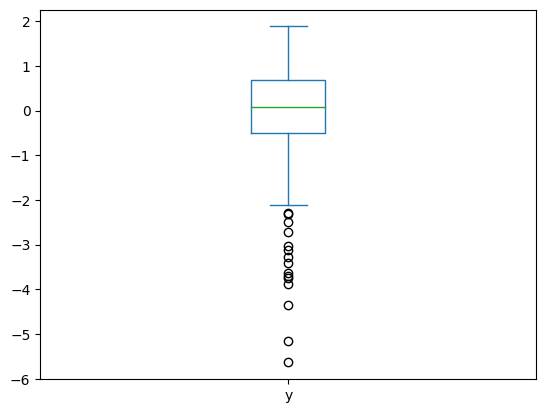

In [ ]:
df['y'].plot.box()

In [ ]:
label_cols = ['y']

In [ ]:
ds = RegressionDataset(tokenizer = smiles_tokenizer, file_path = 'chem_datasets/freesolv.csv', block_size = 515, x_col = "smiles", y_col = ['y'])
train_ds, valid_ds = random_split(ds, lengths= (int(len(df)*0.8), len(df) - int(len(df)*0.8)))
train_loader = DataLoader(train_ds, batch_size = 16, shuffle = True)
valid_loader = DataLoader(valid_ds, batch_size = 16, shuffle = True)



Using custom data configuration default


init dataset
Loaded Dataset
Number of lines: 642
Block size: 515


In [ ]:
data = next(iter(train_loader))

In [ ]:
data.keys()

dict_keys(['input_ids', 'attention_mask', 'label'])

In [ ]:
data['input_ids'].shape, data['label'].shape

(torch.Size([16, 515]), torch.Size([16, 1]))

In [ ]:
config = RobertaConfig(
        vocab_size = 600,
        max_position_embeddings = 515,
        num_attention_heads = 6,
        num_hidden_layers = 6,
        type_vocab_size = 515,
        num_labels = 1,
        is_gpu = True,
        num_outputs = len(label_cols),
        position_embedding_type = 'random'
    )
model = RobertaForRegression(config)

In [ ]:
device = torch.device('cuda')

In [ ]:
yhat = model(data['input_ids'])

In [ ]:
yhat[0].shape

torch.Size([16, 1])

In [ ]:
model.roberta.load_state_dict(torch.load("./models/roberta_method_verification_old_loss.pth"))

<All keys matched successfully>

In [ ]:
model = model.to(device)

In [ ]:
model.freeze_unfreeze()

In [ ]:
for i in model.parameters():
  assert i.requires_grad == True

In [ ]:
train_regression(model, train_dataloader = train_loader, val_dataloader = valid_loader, learning_rate = 1e-05, epochs = 5, wd = 1e-02)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:04<00:00,  6.71it/s]


Epochs: 1 | Train Loss:  1.019             | Val Loss:  0.791


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:02<00:00, 14.47it/s]


Epochs: 2 | Train Loss:  0.936             | Val Loss:  0.774


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:02<00:00, 14.46it/s]


Epochs: 3 | Train Loss:  0.894             | Val Loss:  0.778


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:02<00:00, 14.42it/s]


Epochs: 4 | Train Loss:  0.895             | Val Loss:  0.786


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:02<00:00, 14.44it/s]


Epochs: 5 | Train Loss:  0.870             | Val Loss:  0.714


In [ ]:
model.freeze_unfreeze(action= 'u')

In [ ]:
train_regression(model, train_dataloader = train_loader, val_dataloader = valid_loader, learning_rate = 5e-06, epochs = 5, wd = 1e-02)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:06<00:00,  5.40it/s]


Epochs: 1 | Train Loss:  0.913             | Val Loss:  0.756


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:06<00:00,  5.39it/s]


Epochs: 2 | Train Loss:  0.896             | Val Loss:  0.790


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:06<00:00,  5.40it/s]


Epochs: 3 | Train Loss:  0.892             | Val Loss:  0.746


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:06<00:00,  5.41it/s]


Epochs: 4 | Train Loss:  0.857             | Val Loss:  0.732


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:06<00:00,  5.39it/s]


Epochs: 5 | Train Loss:  0.869             | Val Loss:  0.713


In [ ]:
train_regression(model, train_dataloader = train_loader, val_dataloader = valid_loader, learning_rate = 1e-06, epochs = 15, wd = 1e-02)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:06<00:00,  5.41it/s]


Epochs: 1 | Train Loss:  0.861             | Val Loss:  0.739


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:06<00:00,  5.41it/s]


Epochs: 2 | Train Loss:  0.849             | Val Loss:  0.756


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:06<00:00,  5.40it/s]


Epochs: 3 | Train Loss:  0.859             | Val Loss:  0.741


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:06<00:00,  5.40it/s]


Epochs: 4 | Train Loss:  0.864             | Val Loss:  0.734


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:06<00:00,  5.39it/s]


Epochs: 5 | Train Loss:  0.846             | Val Loss:  0.766


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:06<00:00,  5.39it/s]


Epochs: 6 | Train Loss:  0.848             | Val Loss:  0.762


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:06<00:00,  5.39it/s]


Epochs: 7 | Train Loss:  0.831             | Val Loss:  0.720


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:06<00:00,  5.39it/s]


Epochs: 8 | Train Loss:  0.869             | Val Loss:  0.745


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:06<00:00,  5.38it/s]


Epochs: 9 | Train Loss:  0.845             | Val Loss:  0.721


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:06<00:00,  5.39it/s]


Epochs: 10 | Train Loss:  0.837             | Val Loss:  0.738


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:06<00:00,  5.41it/s]


Epochs: 11 | Train Loss:  0.853             | Val Loss:  0.740


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:06<00:00,  5.40it/s]


Epochs: 12 | Train Loss:  0.829             | Val Loss:  0.729


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:06<00:00,  5.41it/s]


Epochs: 13 | Train Loss:  0.851             | Val Loss:  0.700


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:06<00:00,  5.40it/s]


Epochs: 14 | Train Loss:  0.851             | Val Loss:  0.772


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:06<00:00,  5.40it/s]


Epochs: 15 | Train Loss:  0.846             | Val Loss:  0.739


In [ ]:
torch.save(model.roberta.state_dict(), "./models/roberta_finetuned_freesolv.pth")

In [ ]:
len(valid_ds)

129

In [ ]:
testing_loader = DataLoader(valid_ds, shuffle = True, batch_size = 64)

In [ ]:
test_batch = next(iter(testing_loader))

In [ ]:
x ,  y = test_batch['input_ids'], test_batch['label']

In [ ]:
x, y = x.to(device), y.to(device)

In [ ]:
yhat = model(x)

In [ ]:
yhat[0].shape

torch.Size([64, 1])

In [ ]:
yhat = yhat[0]


In [ ]:
yhat = yhat.to('cpu')

In [ ]:
y = y.to('cpu')

In [ ]:
yhat, y = yhat.squeeze(), y.squeeze()

In [ ]:
F.mse_loss(y, yhat)

tensor(0.7241)

In [ ]:
torch.sqrt(F.mse_loss(y, yhat))

tensor(0.8509)

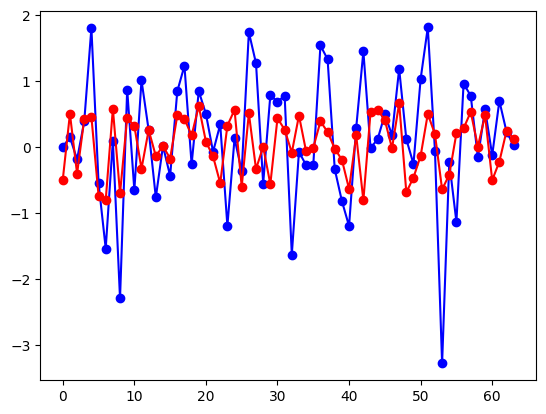

In [ ]:
x = torch.arange(len(y)).numpy()
y = y.numpy()
yhat = yhat.numpy()
# Plot the curves
plt.plot(x, y, label='True Values', color='blue', marker='o')
plt.plot(x, yhat, label='Predicted Values', color='red', marker='o')


# Delaney Scaffold

In [6]:
!ls -lrts chem_datasets/

total 629396
   508 -rw-r--r-- 1 ec2-user ec2-user    519906 Feb 22 11:44 smiles_cas_N6512_icmSmiles.csv
   216 -rw-r--r-- 1 ec2-user ec2-user    219265 Feb 22 11:44 data_PAMPA7_4_input.csv
   268 -rw-r--r-- 1 ec2-user ec2-user    273755 Feb 22 11:44 data_PAMPA7_4.csv
   224 -rw-r--r-- 1 ec2-user ec2-user    226277 Feb 22 11:44 data_HLM_DOD.csv
   160 -rw-r--r-- 1 ec2-user ec2-user    161328 Feb 22 12:55 data_PgpInh_DOD_SALI_lt20_2191.csv
  3808 -rw-r--r-- 1 ec2-user ec2-user   3897767 Mar  1 19:33 bace.csv
   316 -rw-r--r-- 1 ec2-user ec2-user    321126 Mar  2 13:56 lipo.csv
   160 -rw-r--r-- 1 ec2-user ec2-user    161289 Mar  2 13:56 clintox_anton.csv
    68 -rw-r--r-- 1 ec2-user ec2-user     66679 Mar  2 13:56 clearance.csv
   160 -rw-r--r-- 1 ec2-user ec2-user    162062 Mar  2 13:56 bbbp.csv
   140 -rw-r--r-- 1 ec2-user ec2-user    141769 Mar  2 13:56 bace_regression_anton.csv
   140 -rw-r--r-- 1 ec2-user ec2-user    140245 Mar  2 13:56 bace_classification_anton.csv
   136 -rw-r--r

In [11]:
df = pd.read_csv('chem_datasets/delaney_scaffold_train.csv')

In [12]:
df.head()

,Compound ID,measured log(solubility:mol/L),ESOL predicted log(solubility:mol/L),SMILES
0,"1,1,1,2-Tetrachloroethane",-2.18,-2.794,ClCC(Cl)(Cl)Cl
1,"1,1,1-Trichloroethane",-2.00,-2.232,CC(Cl)(Cl)Cl
2,"1,1,2,2-Tetrachloroethane",-1.74,-2.549,ClC(Cl)C(Cl)Cl
3,"1,1,2-Trichloroethane",-1.48,-1.961,ClCC(Cl)Cl
4,"1,1,2-Trichlorotrifluoroethane",-3.04,-3.077,FC(F)(Cl)C(F)(Cl)Cl


In [ ]:
train_ds = RegressionDataset(tokenizer = smiles_tokenizer, file_path = 'chem_datasets/delaney_scaffold_train.csv', block_size = 515, x_col = "SMILES", y_col = ['measured log(solubility:mol/L)'])
valid_ds = RegressionDataset(tokenizer = smiles_tokenizer, file_path = 'chem_datasets/delaney_scaffold_test.csv', block_size = 515, x_col = "SMILES", y_col = ['measured log(solubility:mol/L)'])
train_loader = DataLoader(train_ds, batch_size = 32, shuffle = True)
valid_loader = DataLoader(valid_ds, batch_size = 32, shuffle = True)

config = RobertaConfig(
        vocab_size = 600,
        max_position_embeddings = 515,
        num_attention_heads = 6,
        num_hidden_layers = 6,
        type_vocab_size = 515,
        num_labels = 1,
        is_gpu = True,
        num_outputs = 1,
        position_embedding_type = 'random'
    )
model = RobertaForRegression(config)

device = torch.device('cuda')
model.to(device)

model.freeze_unfreeze()

In [14]:
data = next(iter(train_loader))

In [16]:
data['input_ids'].shape

torch.Size([32, 515])

In [ ]:
device = torch.device('cuda')
model.to(device)

In [19]:
model.freeze_unfreeze()

In [20]:
for i in model.parameters():
  assert i.requires_grad == True

AssertionError: ignored

In [21]:
train_regression(model, train_dataloader = train_loader, val_dataloader = valid_loader, learning_rate = 5e-05, epochs = 7)

100%|██████████| 31/31 [00:06<00:00,  4.85it/s]


Epochs: 1 | Train Loss:  14.028             | Val Loss:  15.576


100%|██████████| 31/31 [00:04<00:00,  7.43it/s]


Epochs: 2 | Train Loss:  6.460             | Val Loss:  5.097


100%|██████████| 31/31 [00:04<00:00,  7.43it/s]


Epochs: 3 | Train Loss:  4.371             | Val Loss:  5.178


100%|██████████| 31/31 [00:04<00:00,  7.41it/s]


Epochs: 4 | Train Loss:  4.282             | Val Loss:  5.121


100%|██████████| 31/31 [00:04<00:00,  7.40it/s]


Epochs: 5 | Train Loss:  4.347             | Val Loss:  4.967


100%|██████████| 31/31 [00:04<00:00,  7.23it/s]


Epochs: 6 | Train Loss:  4.296             | Val Loss:  5.345


100%|██████████| 31/31 [00:04<00:00,  7.32it/s]


Epochs: 7 | Train Loss:  4.305             | Val Loss:  4.683


In [22]:
train_regression(model, train_dataloader = train_loader, val_dataloader = valid_loader, learning_rate = 1e-05, epochs = 5, wd = 1e-01)

100%|██████████| 31/31 [00:04<00:00,  7.44it/s]


Epochs: 1 | Train Loss:  4.313             | Val Loss:  5.223


100%|██████████| 31/31 [00:04<00:00,  7.43it/s]


Epochs: 2 | Train Loss:  4.322             | Val Loss:  5.075


100%|██████████| 31/31 [00:04<00:00,  7.41it/s]


Epochs: 3 | Train Loss:  4.348             | Val Loss:  5.040


100%|██████████| 31/31 [00:04<00:00,  7.40it/s]


Epochs: 4 | Train Loss:  4.256             | Val Loss:  5.167


100%|██████████| 31/31 [00:04<00:00,  7.37it/s]


Epochs: 5 | Train Loss:  4.337             | Val Loss:  5.180


In [23]:
model.freeze_unfreeze(action = 'u')

In [24]:
train_regression(model, train_dataloader = train_loader, val_dataloader = valid_loader, learning_rate = 1e-06, epochs = 10, wd = 1e-02)

100%|██████████| 31/31 [00:10<00:00,  2.85it/s]


Epochs: 1 | Train Loss:  4.302             | Val Loss:  5.469


100%|██████████| 31/31 [00:10<00:00,  2.84it/s]


Epochs: 2 | Train Loss:  4.301             | Val Loss:  4.977


100%|██████████| 31/31 [00:10<00:00,  2.83it/s]


Epochs: 3 | Train Loss:  4.294             | Val Loss:  4.935


100%|██████████| 31/31 [00:10<00:00,  2.83it/s]


Epochs: 4 | Train Loss:  4.291             | Val Loss:  4.841


100%|██████████| 31/31 [00:10<00:00,  2.83it/s]


Epochs: 5 | Train Loss:  4.261             | Val Loss:  5.154


100%|██████████| 31/31 [00:10<00:00,  2.83it/s]


Epochs: 6 | Train Loss:  4.215             | Val Loss:  5.156


100%|██████████| 31/31 [00:10<00:00,  2.83it/s]


Epochs: 7 | Train Loss:  4.221             | Val Loss:  5.297


100%|██████████| 31/31 [00:10<00:00,  2.83it/s]


Epochs: 8 | Train Loss:  4.245             | Val Loss:  4.865


100%|██████████| 31/31 [00:10<00:00,  2.83it/s]


Epochs: 9 | Train Loss:  4.284             | Val Loss:  5.349


100%|██████████| 31/31 [00:10<00:00,  2.83it/s]


Epochs: 10 | Train Loss:  4.204             | Val Loss:  4.935


In [25]:
model.freeze_unfreeze()

In [26]:
train_regression(model, train_dataloader = train_loader, val_dataloader = valid_loader, learning_rate = 1e-04, epochs = 3, wd = 1e-02)

100%|██████████| 31/31 [00:04<00:00,  6.95it/s]


Epochs: 1 | Train Loss:  4.192             | Val Loss:  4.765


100%|██████████| 31/31 [00:04<00:00,  6.94it/s]


Epochs: 2 | Train Loss:  4.240             | Val Loss:  5.181


100%|██████████| 31/31 [00:04<00:00,  6.93it/s]


Epochs: 3 | Train Loss:  4.166             | Val Loss:  4.980


In [27]:
model.freeze_unfreeze(action = 'u')

In [28]:
train_regression(model, train_dataloader = train_loader, val_dataloader = valid_loader, learning_rate = 1e-05, epochs = 10, wd = 4e-02)

100%|██████████| 31/31 [00:10<00:00,  2.85it/s]


Epochs: 1 | Train Loss:  4.176             | Val Loss:  4.771


100%|██████████| 31/31 [00:10<00:00,  2.84it/s]


Epochs: 2 | Train Loss:  4.105             | Val Loss:  4.661


100%|██████████| 31/31 [00:10<00:00,  2.84it/s]


Epochs: 3 | Train Loss:  3.449             | Val Loss:  3.193


100%|██████████| 31/31 [00:10<00:00,  2.83it/s]


Epochs: 4 | Train Loss:  2.666             | Val Loss:  2.602


100%|██████████| 31/31 [00:10<00:00,  2.83it/s]


Epochs: 5 | Train Loss:  2.122             | Val Loss:  2.828


100%|██████████| 31/31 [00:10<00:00,  2.83it/s]


Epochs: 6 | Train Loss:  2.043             | Val Loss:  2.446


100%|██████████| 31/31 [00:10<00:00,  2.83it/s]


Epochs: 7 | Train Loss:  1.981             | Val Loss:  2.745


100%|██████████| 31/31 [00:10<00:00,  2.83it/s]


Epochs: 8 | Train Loss:  1.951             | Val Loss:  2.500


100%|██████████| 31/31 [00:10<00:00,  2.83it/s]


Epochs: 9 | Train Loss:  1.870             | Val Loss:  2.552


100%|██████████| 31/31 [00:10<00:00,  2.83it/s]


Epochs: 10 | Train Loss:  1.863             | Val Loss:  2.271


In [29]:
train_regression(model, train_dataloader = train_loader, val_dataloader = valid_loader, learning_rate = 1e-05, epochs = 10, wd = 4e-02)

100%|██████████| 31/31 [00:10<00:00,  2.86it/s]


Epochs: 1 | Train Loss:  1.900             | Val Loss:  2.421


100%|██████████| 31/31 [00:10<00:00,  2.84it/s]


Epochs: 2 | Train Loss:  1.954             | Val Loss:  2.317


100%|██████████| 31/31 [00:10<00:00,  2.84it/s]


Epochs: 3 | Train Loss:  2.092             | Val Loss:  2.279


100%|██████████| 31/31 [00:10<00:00,  2.84it/s]


Epochs: 4 | Train Loss:  1.775             | Val Loss:  1.956


100%|██████████| 31/31 [00:10<00:00,  2.83it/s]


Epochs: 5 | Train Loss:  1.468             | Val Loss:  1.698


100%|██████████| 31/31 [00:10<00:00,  2.83it/s]


Epochs: 6 | Train Loss:  1.254             | Val Loss:  1.720


100%|██████████| 31/31 [00:10<00:00,  2.83it/s]


Epochs: 7 | Train Loss:  1.198             | Val Loss:  1.719


100%|██████████| 31/31 [00:10<00:00,  2.82it/s]


Epochs: 8 | Train Loss:  1.198             | Val Loss:  1.463


100%|██████████| 31/31 [00:10<00:00,  2.82it/s]


Epochs: 9 | Train Loss:  1.146             | Val Loss:  1.440


100%|██████████| 31/31 [00:10<00:00,  2.83it/s]


Epochs: 10 | Train Loss:  1.109             | Val Loss:  1.539


In [30]:
train_regression(model, train_dataloader = train_loader, val_dataloader = valid_loader, learning_rate = 5e-06, epochs = 10, wd = 1e-05)

100%|██████████| 31/31 [00:10<00:00,  2.85it/s]


Epochs: 1 | Train Loss:  1.166             | Val Loss:  1.670


100%|██████████| 31/31 [00:10<00:00,  2.84it/s]


Epochs: 2 | Train Loss:  1.133             | Val Loss:  1.504


100%|██████████| 31/31 [00:10<00:00,  2.84it/s]


Epochs: 3 | Train Loss:  1.146             | Val Loss:  1.762


100%|██████████| 31/31 [00:10<00:00,  2.84it/s]


Epochs: 4 | Train Loss:  1.198             | Val Loss:  1.687


100%|██████████| 31/31 [00:10<00:00,  2.83it/s]


Epochs: 5 | Train Loss:  1.149             | Val Loss:  1.690


100%|██████████| 31/31 [00:10<00:00,  2.83it/s]


Epochs: 6 | Train Loss:  1.082             | Val Loss:  1.623


100%|██████████| 31/31 [00:10<00:00,  2.82it/s]


Epochs: 7 | Train Loss:  1.079             | Val Loss:  1.818


100%|██████████| 31/31 [00:10<00:00,  2.83it/s]


Epochs: 8 | Train Loss:  1.064             | Val Loss:  1.618


100%|██████████| 31/31 [00:10<00:00,  2.83it/s]


Epochs: 9 | Train Loss:  1.032             | Val Loss:  1.527


100%|██████████| 31/31 [00:10<00:00,  2.83it/s]


Epochs: 10 | Train Loss:  1.015             | Val Loss:  1.623


In [31]:
train_regression(model, train_dataloader = train_loader, val_dataloader = valid_loader, learning_rate = 1e-06, epochs = 25, wd = 1e-02)

100%|██████████| 31/31 [00:10<00:00,  2.86it/s]


Epochs: 1 | Train Loss:  1.030             | Val Loss:  1.565


100%|██████████| 31/31 [00:10<00:00,  2.84it/s]


Epochs: 2 | Train Loss:  1.033             | Val Loss:  1.600


100%|██████████| 31/31 [00:10<00:00,  2.84it/s]


Epochs: 3 | Train Loss:  1.015             | Val Loss:  1.550


100%|██████████| 31/31 [00:10<00:00,  2.84it/s]


Epochs: 4 | Train Loss:  1.019             | Val Loss:  1.500


100%|██████████| 31/31 [00:10<00:00,  2.83it/s]


Epochs: 5 | Train Loss:  1.027             | Val Loss:  1.668


100%|██████████| 31/31 [00:10<00:00,  2.83it/s]


Epochs: 6 | Train Loss:  1.044             | Val Loss:  1.501


100%|██████████| 31/31 [00:10<00:00,  2.83it/s]


Epochs: 7 | Train Loss:  0.987             | Val Loss:  1.494


100%|██████████| 31/31 [00:10<00:00,  2.82it/s]


Epochs: 8 | Train Loss:  1.012             | Val Loss:  1.429


100%|██████████| 31/31 [00:10<00:00,  2.82it/s]


Epochs: 9 | Train Loss:  1.010             | Val Loss:  1.519


100%|██████████| 31/31 [00:10<00:00,  2.83it/s]


Epochs: 10 | Train Loss:  1.011             | Val Loss:  1.465


100%|██████████| 31/31 [00:10<00:00,  2.83it/s]


Epochs: 11 | Train Loss:  1.050             | Val Loss:  1.563


100%|██████████| 31/31 [00:10<00:00,  2.83it/s]


Epochs: 12 | Train Loss:  1.009             | Val Loss:  1.651


100%|██████████| 31/31 [00:10<00:00,  2.83it/s]


Epochs: 13 | Train Loss:  1.019             | Val Loss:  1.552


100%|██████████| 31/31 [00:10<00:00,  2.83it/s]


Epochs: 14 | Train Loss:  0.962             | Val Loss:  1.488


100%|██████████| 31/31 [00:10<00:00,  2.83it/s]


Epochs: 15 | Train Loss:  1.015             | Val Loss:  1.563


100%|██████████| 31/31 [00:10<00:00,  2.83it/s]


Epochs: 16 | Train Loss:  0.981             | Val Loss:  1.566


100%|██████████| 31/31 [00:10<00:00,  2.83it/s]


Epochs: 17 | Train Loss:  0.993             | Val Loss:  1.399


100%|██████████| 31/31 [00:10<00:00,  2.83it/s]


Epochs: 18 | Train Loss:  0.988             | Val Loss:  1.443


100%|██████████| 31/31 [00:10<00:00,  2.83it/s]


Epochs: 19 | Train Loss:  0.970             | Val Loss:  1.592


100%|██████████| 31/31 [00:10<00:00,  2.83it/s]


Epochs: 20 | Train Loss:  0.979             | Val Loss:  1.603


100%|██████████| 31/31 [00:10<00:00,  2.83it/s]


Epochs: 21 | Train Loss:  0.947             | Val Loss:  1.697


100%|██████████| 31/31 [00:10<00:00,  2.83it/s]


Epochs: 22 | Train Loss:  0.982             | Val Loss:  1.618


100%|██████████| 31/31 [00:10<00:00,  2.83it/s]


Epochs: 23 | Train Loss:  0.979             | Val Loss:  1.453


100%|██████████| 31/31 [00:10<00:00,  2.83it/s]


Epochs: 24 | Train Loss:  0.955             | Val Loss:  1.496


100%|██████████| 31/31 [00:10<00:00,  2.83it/s]


Epochs: 25 | Train Loss:  0.950             | Val Loss:  1.488


In [32]:
train_regression(model, train_dataloader = train_loader, val_dataloader = valid_loader, learning_rate = 5e-06, epochs = 5, wd = 1e-01)

100%|██████████| 31/31 [00:10<00:00,  2.85it/s]


Epochs: 1 | Train Loss:  0.953             | Val Loss:  1.708


100%|██████████| 31/31 [00:10<00:00,  2.85it/s]


Epochs: 2 | Train Loss:  1.040             | Val Loss:  1.952


100%|██████████| 31/31 [00:10<00:00,  2.84it/s]


Epochs: 3 | Train Loss:  1.059             | Val Loss:  1.496


100%|██████████| 31/31 [00:10<00:00,  2.84it/s]


Epochs: 4 | Train Loss:  0.997             | Val Loss:  1.544


100%|██████████| 31/31 [00:10<00:00,  2.83it/s]


Epochs: 5 | Train Loss:  0.932             | Val Loss:  1.458


In [33]:
train_regression(model, train_dataloader = train_loader, val_dataloader = valid_loader, learning_rate = 1e-06, epochs = 5, wd = 1e-01)

100%|██████████| 31/31 [00:10<00:00,  2.84it/s]


Epochs: 1 | Train Loss:  0.917             | Val Loss:  1.574


100%|██████████| 31/31 [00:10<00:00,  2.84it/s]


Epochs: 2 | Train Loss:  0.949             | Val Loss:  1.545


100%|██████████| 31/31 [00:10<00:00,  2.83it/s]


Epochs: 3 | Train Loss:  0.924             | Val Loss:  1.546


100%|██████████| 31/31 [00:10<00:00,  2.83it/s]


Epochs: 4 | Train Loss:  0.946             | Val Loss:  1.585


100%|██████████| 31/31 [00:10<00:00,  2.83it/s]


Epochs: 5 | Train Loss:  0.917             | Val Loss:  1.431


In [34]:
train_regression(model, train_dataloader = train_loader, val_dataloader = valid_loader, learning_rate = 5e-07, epochs = 15, wd = 1e-02)

100%|██████████| 31/31 [00:10<00:00,  2.84it/s]


Epochs: 1 | Train Loss:  0.883             | Val Loss:  1.425


100%|██████████| 31/31 [00:10<00:00,  2.83it/s]


Epochs: 2 | Train Loss:  0.930             | Val Loss:  1.547


100%|██████████| 31/31 [00:10<00:00,  2.83it/s]


Epochs: 3 | Train Loss:  0.922             | Val Loss:  1.458


100%|██████████| 31/31 [00:10<00:00,  2.83it/s]


Epochs: 4 | Train Loss:  0.929             | Val Loss:  1.491


100%|██████████| 31/31 [00:10<00:00,  2.84it/s]


Epochs: 5 | Train Loss:  0.934             | Val Loss:  1.485


100%|██████████| 31/31 [00:10<00:00,  2.83it/s]


Epochs: 6 | Train Loss:  0.915             | Val Loss:  1.403


100%|██████████| 31/31 [00:10<00:00,  2.83it/s]


Epochs: 7 | Train Loss:  0.916             | Val Loss:  1.388


100%|██████████| 31/31 [00:10<00:00,  2.83it/s]


Epochs: 8 | Train Loss:  0.937             | Val Loss:  1.576


100%|██████████| 31/31 [00:10<00:00,  2.83it/s]


Epochs: 9 | Train Loss:  0.922             | Val Loss:  1.414


100%|██████████| 31/31 [00:10<00:00,  2.83it/s]


Epochs: 10 | Train Loss:  0.946             | Val Loss:  1.400


100%|██████████| 31/31 [00:10<00:00,  2.83it/s]


Epochs: 11 | Train Loss:  0.905             | Val Loss:  1.407


100%|██████████| 31/31 [00:10<00:00,  2.83it/s]


Epochs: 12 | Train Loss:  0.891             | Val Loss:  1.495


100%|██████████| 31/31 [00:10<00:00,  2.83it/s]


Epochs: 13 | Train Loss:  0.905             | Val Loss:  1.349


100%|██████████| 31/31 [00:10<00:00,  2.83it/s]


Epochs: 14 | Train Loss:  0.900             | Val Loss:  1.388


100%|██████████| 31/31 [00:10<00:00,  2.83it/s]


Epochs: 15 | Train Loss:  0.875             | Val Loss:  1.402


In [35]:
train_regression(model, train_dataloader = train_loader, val_dataloader = valid_loader, learning_rate = 1e-07, epochs = 25, wd = 1e-02)

100%|██████████| 31/31 [00:10<00:00,  2.86it/s]


Epochs: 1 | Train Loss:  0.903             | Val Loss:  1.449


100%|██████████| 31/31 [00:10<00:00,  2.84it/s]


Epochs: 2 | Train Loss:  0.906             | Val Loss:  1.501


100%|██████████| 31/31 [00:10<00:00,  2.84it/s]


Epochs: 3 | Train Loss:  0.891             | Val Loss:  1.573


100%|██████████| 31/31 [00:10<00:00,  2.83it/s]


Epochs: 4 | Train Loss:  0.928             | Val Loss:  1.490


100%|██████████| 31/31 [00:10<00:00,  2.83it/s]


Epochs: 5 | Train Loss:  0.905             | Val Loss:  1.299


100%|██████████| 31/31 [00:10<00:00,  2.82it/s]


Epochs: 6 | Train Loss:  0.914             | Val Loss:  1.509


100%|██████████| 31/31 [00:10<00:00,  2.83it/s]


Epochs: 7 | Train Loss:  0.926             | Val Loss:  1.479


100%|██████████| 31/31 [00:10<00:00,  2.83it/s]


Epochs: 8 | Train Loss:  0.903             | Val Loss:  1.512


100%|██████████| 31/31 [00:10<00:00,  2.83it/s]


Epochs: 9 | Train Loss:  0.903             | Val Loss:  1.427


100%|██████████| 31/31 [00:10<00:00,  2.83it/s]


Epochs: 10 | Train Loss:  0.901             | Val Loss:  1.562


100%|██████████| 31/31 [00:10<00:00,  2.83it/s]


Epochs: 11 | Train Loss:  0.915             | Val Loss:  1.560


100%|██████████| 31/31 [00:10<00:00,  2.83it/s]


Epochs: 12 | Train Loss:  0.876             | Val Loss:  1.492


100%|██████████| 31/31 [00:10<00:00,  2.83it/s]


Epochs: 13 | Train Loss:  0.892             | Val Loss:  1.473


100%|██████████| 31/31 [00:10<00:00,  2.82it/s]


Epochs: 14 | Train Loss:  0.853             | Val Loss:  1.336


100%|██████████| 31/31 [00:10<00:00,  2.82it/s]


Epochs: 15 | Train Loss:  0.884             | Val Loss:  1.555


100%|██████████| 31/31 [00:10<00:00,  2.83it/s]


Epochs: 16 | Train Loss:  0.865             | Val Loss:  1.528


100%|██████████| 31/31 [00:10<00:00,  2.83it/s]


Epochs: 17 | Train Loss:  0.887             | Val Loss:  1.526


100%|██████████| 31/31 [00:10<00:00,  2.83it/s]


Epochs: 18 | Train Loss:  0.900             | Val Loss:  1.511


100%|██████████| 31/31 [00:10<00:00,  2.83it/s]


Epochs: 19 | Train Loss:  0.900             | Val Loss:  1.453


100%|██████████| 31/31 [00:10<00:00,  2.83it/s]


Epochs: 20 | Train Loss:  0.895             | Val Loss:  1.433


100%|██████████| 31/31 [00:10<00:00,  2.82it/s]


Epochs: 21 | Train Loss:  0.900             | Val Loss:  1.484


100%|██████████| 31/31 [00:10<00:00,  2.82it/s]


Epochs: 22 | Train Loss:  0.887             | Val Loss:  1.542


100%|██████████| 31/31 [00:11<00:00,  2.82it/s]


Epochs: 23 | Train Loss:  0.905             | Val Loss:  1.474


100%|██████████| 31/31 [00:11<00:00,  2.82it/s]


Epochs: 24 | Train Loss:  0.889             | Val Loss:  1.513


100%|██████████| 31/31 [00:11<00:00,  2.82it/s]


Epochs: 25 | Train Loss:  0.897             | Val Loss:  1.442


In [36]:
train_regression(model, train_dataloader = train_loader, val_dataloader = valid_loader, learning_rate = 1e-04, epochs = 2, wd = 1e-01)

100%|██████████| 31/31 [00:10<00:00,  2.86it/s]


Epochs: 1 | Train Loss:  1.565             | Val Loss:  2.106


100%|██████████| 31/31 [00:10<00:00,  2.85it/s]


Epochs: 2 | Train Loss:  1.144             | Val Loss:  1.463


In [37]:
train_regression(model, train_dataloader = train_loader, val_dataloader = valid_loader, learning_rate = 1e-04, epochs = 2, wd = 1e-01)

100%|██████████| 31/31 [00:11<00:00,  2.82it/s]


Epochs: 1 | Train Loss:  1.754             | Val Loss:  3.392


100%|██████████| 31/31 [00:10<00:00,  2.82it/s]


Epochs: 2 | Train Loss:  1.514             | Val Loss:  1.888


In [38]:
train_regression(model, train_dataloader = train_loader, val_dataloader = valid_loader, learning_rate = 1e-06, epochs = 15, wd = 1e-02)

100%|██████████| 31/31 [00:10<00:00,  2.85it/s]


Epochs: 1 | Train Loss:  1.093             | Val Loss:  1.847


100%|██████████| 31/31 [00:10<00:00,  2.84it/s]


Epochs: 2 | Train Loss:  1.083             | Val Loss:  1.790


100%|██████████| 31/31 [00:10<00:00,  2.84it/s]


Epochs: 3 | Train Loss:  1.080             | Val Loss:  1.951


100%|██████████| 31/31 [00:10<00:00,  2.82it/s]


Epochs: 4 | Train Loss:  1.061             | Val Loss:  1.912


100%|██████████| 31/31 [00:10<00:00,  2.83it/s]


Epochs: 5 | Train Loss:  1.087             | Val Loss:  1.810


100%|██████████| 31/31 [00:10<00:00,  2.83it/s]


Epochs: 6 | Train Loss:  1.061             | Val Loss:  1.836


100%|██████████| 31/31 [00:10<00:00,  2.83it/s]


Epochs: 7 | Train Loss:  1.017             | Val Loss:  1.675


100%|██████████| 31/31 [00:11<00:00,  2.80it/s]


Epochs: 8 | Train Loss:  1.007             | Val Loss:  1.766


100%|██████████| 31/31 [00:10<00:00,  2.84it/s]


Epochs: 9 | Train Loss:  1.040             | Val Loss:  1.812


100%|██████████| 31/31 [00:10<00:00,  2.84it/s]


Epochs: 10 | Train Loss:  0.978             | Val Loss:  1.923


100%|██████████| 31/31 [00:10<00:00,  2.84it/s]


Epochs: 11 | Train Loss:  0.975             | Val Loss:  1.654


100%|██████████| 31/31 [00:11<00:00,  2.81it/s]


Epochs: 12 | Train Loss:  0.965             | Val Loss:  1.890


100%|██████████| 31/31 [00:10<00:00,  2.84it/s]


Epochs: 13 | Train Loss:  0.981             | Val Loss:  1.685


100%|██████████| 31/31 [00:10<00:00,  2.83it/s]


Epochs: 14 | Train Loss:  0.947             | Val Loss:  1.605


100%|██████████| 31/31 [00:10<00:00,  2.83it/s]


Epochs: 15 | Train Loss:  0.966             | Val Loss:  1.790


In [39]:
train_regression(model, train_dataloader = train_loader, val_dataloader = valid_loader, learning_rate = 1e-05, epochs = 4, wd = 1e-02)

100%|██████████| 31/31 [00:11<00:00,  2.78it/s]


Epochs: 1 | Train Loss:  0.982             | Val Loss:  1.677


100%|██████████| 31/31 [00:10<00:00,  2.85it/s]


Epochs: 2 | Train Loss:  0.951             | Val Loss:  1.637


100%|██████████| 31/31 [00:10<00:00,  2.84it/s]


Epochs: 3 | Train Loss:  0.858             | Val Loss:  1.667


100%|██████████| 31/31 [00:10<00:00,  2.82it/s]


Epochs: 4 | Train Loss:  0.836             | Val Loss:  1.370


In [40]:
train_regression(model, train_dataloader = train_loader, val_dataloader = valid_loader, learning_rate = 1e-05, epochs = 4, wd = 1e-02)

100%|██████████| 31/31 [00:10<00:00,  2.85it/s]


Epochs: 1 | Train Loss:  0.835             | Val Loss:  1.539


100%|██████████| 31/31 [00:10<00:00,  2.84it/s]


Epochs: 2 | Train Loss:  0.865             | Val Loss:  1.316


100%|██████████| 31/31 [00:10<00:00,  2.83it/s]


Epochs: 3 | Train Loss:  0.759             | Val Loss:  1.397


100%|██████████| 31/31 [00:10<00:00,  2.83it/s]


Epochs: 4 | Train Loss:  0.729             | Val Loss:  1.431


In [41]:
train_regression(model, train_dataloader = train_loader, val_dataloader = valid_loader, learning_rate = 1e-05, epochs = 10, wd = 5e-02)

100%|██████████| 31/31 [00:10<00:00,  2.84it/s]


Epochs: 1 | Train Loss:  0.761             | Val Loss:  1.272


100%|██████████| 31/31 [00:10<00:00,  2.84it/s]


Epochs: 2 | Train Loss:  0.739             | Val Loss:  1.308


100%|██████████| 31/31 [00:10<00:00,  2.84it/s]


Epochs: 3 | Train Loss:  0.754             | Val Loss:  1.865


100%|██████████| 31/31 [00:10<00:00,  2.84it/s]


Epochs: 4 | Train Loss:  0.801             | Val Loss:  1.585


100%|██████████| 31/31 [00:11<00:00,  2.76it/s]


Epochs: 5 | Train Loss:  0.737             | Val Loss:  1.344


100%|██████████| 31/31 [00:10<00:00,  2.84it/s]


Epochs: 6 | Train Loss:  0.696             | Val Loss:  1.185


100%|██████████| 31/31 [00:10<00:00,  2.84it/s]


Epochs: 7 | Train Loss:  0.682             | Val Loss:  1.241


100%|██████████| 31/31 [00:10<00:00,  2.84it/s]


Epochs: 8 | Train Loss:  0.704             | Val Loss:  1.324


100%|██████████| 31/31 [00:10<00:00,  2.84it/s]


Epochs: 9 | Train Loss:  0.673             | Val Loss:  1.228


100%|██████████| 31/31 [00:10<00:00,  2.84it/s]


Epochs: 10 | Train Loss:  0.659             | Val Loss:  1.355


In [42]:
train_regression(model, train_dataloader = train_loader, val_dataloader = valid_loader, learning_rate = 1e-05, epochs = 10, wd = 5e-02)

100%|██████████| 31/31 [00:10<00:00,  2.85it/s]


Epochs: 1 | Train Loss:  0.658             | Val Loss:  1.264


100%|██████████| 31/31 [00:10<00:00,  2.84it/s]


Epochs: 2 | Train Loss:  0.663             | Val Loss:  1.297


100%|██████████| 31/31 [00:10<00:00,  2.84it/s]


Epochs: 3 | Train Loss:  0.708             | Val Loss:  1.398


100%|██████████| 31/31 [00:11<00:00,  2.77it/s]


Epochs: 4 | Train Loss:  0.725             | Val Loss:  1.200


100%|██████████| 31/31 [00:10<00:00,  2.84it/s]


Epochs: 5 | Train Loss:  0.632             | Val Loss:  1.343


100%|██████████| 31/31 [00:10<00:00,  2.84it/s]


Epochs: 6 | Train Loss:  0.670             | Val Loss:  1.213


100%|██████████| 31/31 [00:11<00:00,  2.81it/s]


Epochs: 7 | Train Loss:  0.648             | Val Loss:  1.225


100%|██████████| 31/31 [00:10<00:00,  2.83it/s]


Epochs: 8 | Train Loss:  0.646             | Val Loss:  1.320


100%|██████████| 31/31 [00:10<00:00,  2.84it/s]


Epochs: 9 | Train Loss:  0.634             | Val Loss:  1.394


100%|██████████| 31/31 [00:10<00:00,  2.83it/s]


Epochs: 10 | Train Loss:  0.609             | Val Loss:  1.264


In [43]:
train_regression(model, train_dataloader = train_loader, val_dataloader = valid_loader, learning_rate = 5e-06, epochs = 10, wd = 5e-02)

100%|██████████| 31/31 [00:10<00:00,  2.86it/s]


Epochs: 1 | Train Loss:  0.623             | Val Loss:  1.294


100%|██████████| 31/31 [00:10<00:00,  2.84it/s]


Epochs: 2 | Train Loss:  0.604             | Val Loss:  1.210


100%|██████████| 31/31 [00:11<00:00,  2.82it/s]


Epochs: 3 | Train Loss:  0.646             | Val Loss:  1.354


100%|██████████| 31/31 [00:10<00:00,  2.84it/s]


Epochs: 4 | Train Loss:  0.699             | Val Loss:  1.053


100%|██████████| 31/31 [00:10<00:00,  2.84it/s]


Epochs: 5 | Train Loss:  0.613             | Val Loss:  1.267


100%|██████████| 31/31 [00:10<00:00,  2.82it/s]


Epochs: 6 | Train Loss:  0.630             | Val Loss:  1.335


100%|██████████| 31/31 [00:10<00:00,  2.83it/s]


Epochs: 7 | Train Loss:  0.596             | Val Loss:  1.205


100%|██████████| 31/31 [00:10<00:00,  2.84it/s]


Epochs: 8 | Train Loss:  0.622             | Val Loss:  1.198


100%|██████████| 31/31 [00:10<00:00,  2.84it/s]


Epochs: 9 | Train Loss:  0.576             | Val Loss:  1.243


100%|██████████| 31/31 [00:10<00:00,  2.83it/s]


Epochs: 10 | Train Loss:  0.581             | Val Loss:  1.225


In [44]:
train_regression(model, train_dataloader = train_loader, val_dataloader = valid_loader, learning_rate = 4e-05, epochs = 2, wd = 5e-02)

100%|██████████| 31/31 [00:10<00:00,  2.85it/s]


Epochs: 1 | Train Loss:  0.748             | Val Loss:  1.479


100%|██████████| 31/31 [00:11<00:00,  2.81it/s]


Epochs: 2 | Train Loss:  0.681             | Val Loss:  1.241


In [45]:
train_regression(model, train_dataloader = train_loader, val_dataloader = valid_loader, learning_rate = 5e-06, epochs = 3, wd = 5e-02)

100%|██████████| 31/31 [00:10<00:00,  2.85it/s]


Epochs: 1 | Train Loss:  0.599             | Val Loss:  1.519


100%|██████████| 31/31 [00:10<00:00,  2.84it/s]


Epochs: 2 | Train Loss:  0.632             | Val Loss:  1.375


100%|██████████| 31/31 [00:11<00:00,  2.79it/s]


Epochs: 3 | Train Loss:  0.584             | Val Loss:  1.301


In [46]:
train_regression(model, train_dataloader = train_loader, val_dataloader = valid_loader, learning_rate = 1e-06, epochs = 20, wd = 1e-02)

100%|██████████| 31/31 [00:10<00:00,  2.86it/s]


Epochs: 1 | Train Loss:  0.576             | Val Loss:  1.284


100%|██████████| 31/31 [00:10<00:00,  2.85it/s]


Epochs: 2 | Train Loss:  0.579             | Val Loss:  1.215


100%|██████████| 31/31 [00:11<00:00,  2.80it/s]


Epochs: 3 | Train Loss:  0.580             | Val Loss:  1.222


100%|██████████| 31/31 [00:10<00:00,  2.84it/s]


Epochs: 4 | Train Loss:  0.589             | Val Loss:  1.301


100%|██████████| 31/31 [00:10<00:00,  2.84it/s]


Epochs: 5 | Train Loss:  0.591             | Val Loss:  1.270


100%|██████████| 31/31 [00:10<00:00,  2.84it/s]


Epochs: 6 | Train Loss:  0.571             | Val Loss:  1.240


100%|██████████| 31/31 [00:11<00:00,  2.81it/s]


Epochs: 7 | Train Loss:  0.547             | Val Loss:  1.227


100%|██████████| 31/31 [00:10<00:00,  2.83it/s]


Epochs: 8 | Train Loss:  0.565             | Val Loss:  1.001


100%|██████████| 31/31 [00:10<00:00,  2.83it/s]


Epochs: 9 | Train Loss:  0.579             | Val Loss:  1.182


100%|██████████| 31/31 [00:10<00:00,  2.82it/s]


Epochs: 10 | Train Loss:  0.574             | Val Loss:  1.148


100%|██████████| 31/31 [00:10<00:00,  2.83it/s]


Epochs: 11 | Train Loss:  0.570             | Val Loss:  1.273


100%|██████████| 31/31 [00:10<00:00,  2.83it/s]


Epochs: 12 | Train Loss:  0.588             | Val Loss:  1.219


100%|██████████| 31/31 [00:10<00:00,  2.83it/s]


Epochs: 13 | Train Loss:  0.581             | Val Loss:  1.200


100%|██████████| 31/31 [00:10<00:00,  2.83it/s]


Epochs: 14 | Train Loss:  0.574             | Val Loss:  1.268


100%|██████████| 31/31 [00:10<00:00,  2.83it/s]


Epochs: 15 | Train Loss:  0.558             | Val Loss:  1.285


100%|██████████| 31/31 [00:10<00:00,  2.83it/s]


Epochs: 16 | Train Loss:  0.549             | Val Loss:  1.178


100%|██████████| 31/31 [00:10<00:00,  2.83it/s]


Epochs: 17 | Train Loss:  0.566             | Val Loss:  1.292


100%|██████████| 31/31 [00:11<00:00,  2.82it/s]


Epochs: 18 | Train Loss:  0.572             | Val Loss:  1.271


100%|██████████| 31/31 [00:10<00:00,  2.83it/s]


Epochs: 19 | Train Loss:  0.583             | Val Loss:  1.065


100%|██████████| 31/31 [00:10<00:00,  2.83it/s]


Epochs: 20 | Train Loss:  0.556             | Val Loss:  1.206


# Freesolv Scaffold

In [49]:
df = pd.read_csv('chem_datasets/freesolv_scaffold_train.csv')
df.head()

,smiles,y
0,CS(=O)(=O)Cl,-0.277514
1,CC(C)C=C,1.465089
2,CCCCCCCO,-0.105855
3,CC(C)C(C)C,1.597735
4,CCCC(C)(C)O,-0.030429


In [50]:
train_ds = RegressionDataset(tokenizer = smiles_tokenizer, file_path = 'chem_datasets/freesolv_scaffold_train.csv', block_size = 515, x_col = "smiles", y_col = ['y'])
valid_ds = RegressionDataset(tokenizer = smiles_tokenizer, file_path = 'chem_datasets/freesolv_scaffold_test.csv', block_size = 515, x_col = "smiles", y_col = ['y'])

train_loader = DataLoader(train_ds, batch_size = 32, shuffle = True)
valid_loader = DataLoader(valid_ds, batch_size = 32, shuffle = True)

config = RobertaConfig(
        vocab_size = 600,
        max_position_embeddings = 515,
        num_attention_heads = 6,
        num_hidden_layers = 6,
        type_vocab_size = 515,
        num_labels = 1,
        is_gpu = True,
        num_outputs = 1,
        position_embedding_type = 'random'
    )
model = RobertaForRegression(config)

device = torch.device('cuda')
model.to(device)

model.freeze_unfreeze()

Using custom data configuration default


init dataset


0 tables [00:00, ? tables/s]

Using custom data configuration default


Dataset csv downloaded and prepared to /home/ec2-user/.cache/huggingface/datasets/csv/default-db0a7db7d728d8b9/0.0.0/ede98314803c971fef04bcee45d660c62f3332e8a74491e0b876106f3d99bd9b. Subsequent calls will reuse this data.
Loaded Dataset
Number of lines: 545
Block size: 515
init dataset


0 tables [00:00, ? tables/s]

Dataset csv downloaded and prepared to /home/ec2-user/.cache/huggingface/datasets/csv/default-5ac698675beeeb71/0.0.0/ede98314803c971fef04bcee45d660c62f3332e8a74491e0b876106f3d99bd9b. Subsequent calls will reuse this data.
Loaded Dataset
Number of lines: 97
Block size: 515


In [51]:
for i in model.parameters:
  assert i.requires_grad == True

TypeError: ignored

In [52]:
train_regression(model, train_dataloader = train_loader, val_dataloader = valid_loader, learning_rate = 1e-04, epochs = 5, wd = 1e-01)

100%|██████████| 18/18 [00:02<00:00,  7.66it/s]


Epochs: 1 | Train Loss:  0.751             | Val Loss:  2.826


100%|██████████| 18/18 [00:02<00:00,  7.65it/s]


Epochs: 2 | Train Loss:  0.729             | Val Loss:  3.008


100%|██████████| 18/18 [00:02<00:00,  7.65it/s]


Epochs: 3 | Train Loss:  0.735             | Val Loss:  2.661


100%|██████████| 18/18 [00:02<00:00,  7.65it/s]


Epochs: 4 | Train Loss:  0.738             | Val Loss:  2.971


100%|██████████| 18/18 [00:02<00:00,  7.61it/s]


Epochs: 5 | Train Loss:  0.736             | Val Loss:  2.682


In [53]:
train_regression(model, train_dataloader = train_loader, val_dataloader = valid_loader, learning_rate = 1e-05, epochs = 5, wd = 1e-01)

100%|██████████| 18/18 [00:02<00:00,  7.66it/s]


Epochs: 1 | Train Loss:  0.721             | Val Loss:  2.601


100%|██████████| 18/18 [00:02<00:00,  7.65it/s]


Epochs: 2 | Train Loss:  0.736             | Val Loss:  2.760


100%|██████████| 18/18 [00:02<00:00,  7.64it/s]


Epochs: 3 | Train Loss:  0.733             | Val Loss:  2.798


100%|██████████| 18/18 [00:02<00:00,  7.64it/s]


Epochs: 4 | Train Loss:  0.732             | Val Loss:  2.711


100%|██████████| 18/18 [00:02<00:00,  7.64it/s]


Epochs: 5 | Train Loss:  0.745             | Val Loss:  2.696


In [54]:
model.freeze_unfreeze('u')

In [55]:
train_regression(model, train_dataloader = train_loader, val_dataloader = valid_loader, learning_rate = 1e-04, epochs = 5, wd = 1e-01)

100%|██████████| 18/18 [00:06<00:00,  2.90it/s]


Epochs: 1 | Train Loss:  0.733             | Val Loss:  2.200


100%|██████████| 18/18 [00:06<00:00,  2.89it/s]


Epochs: 2 | Train Loss:  0.755             | Val Loss:  1.465


100%|██████████| 18/18 [00:06<00:00,  2.91it/s]


Epochs: 3 | Train Loss:  0.476             | Val Loss:  1.814


100%|██████████| 18/18 [00:06<00:00,  2.92it/s]


Epochs: 4 | Train Loss:  0.336             | Val Loss:  1.853


100%|██████████| 18/18 [00:06<00:00,  2.91it/s]


Epochs: 5 | Train Loss:  0.290             | Val Loss:  1.479


In [56]:
train_regression(model, train_dataloader = train_loader, val_dataloader = valid_loader, learning_rate = 1e-02, epochs = 2, wd = 1e-01)

100%|██████████| 18/18 [00:06<00:00,  2.93it/s]


Epochs: 1 | Train Loss:  18.491             | Val Loss:  2.420


100%|██████████| 18/18 [00:06<00:00,  2.90it/s]


Epochs: 2 | Train Loss:  0.737             | Val Loss:  2.822


In [57]:
train_regression(model, train_dataloader = train_loader, val_dataloader = valid_loader, learning_rate = 1e-04, epochs = 5, wd = 1e-01)

100%|██████████| 18/18 [00:06<00:00,  2.94it/s]


Epochs: 1 | Train Loss:  0.742             | Val Loss:  2.607


100%|██████████| 18/18 [00:06<00:00,  2.93it/s]


Epochs: 2 | Train Loss:  0.730             | Val Loss:  2.697


100%|██████████| 18/18 [00:06<00:00,  2.93it/s]


Epochs: 3 | Train Loss:  0.725             | Val Loss:  2.707


100%|██████████| 18/18 [00:06<00:00,  2.92it/s]


Epochs: 4 | Train Loss:  0.718             | Val Loss:  2.774


100%|██████████| 18/18 [00:06<00:00,  2.90it/s]


Epochs: 5 | Train Loss:  0.734             | Val Loss:  2.716


In [58]:
train_regression(model, train_dataloader = train_loader, val_dataloader = valid_loader, learning_rate = 1e-05, epochs = 5, wd = 1e-02)

100%|██████████| 18/18 [00:06<00:00,  2.95it/s]


Epochs: 1 | Train Loss:  0.732             | Val Loss:  2.661


100%|██████████| 18/18 [00:06<00:00,  2.95it/s]


Epochs: 2 | Train Loss:  0.729             | Val Loss:  2.570


100%|██████████| 18/18 [00:06<00:00,  2.94it/s]


Epochs: 3 | Train Loss:  0.727             | Val Loss:  2.717


100%|██████████| 18/18 [00:06<00:00,  2.93it/s]


Epochs: 4 | Train Loss:  0.730             | Val Loss:  2.667


100%|██████████| 18/18 [00:06<00:00,  2.93it/s]


Epochs: 5 | Train Loss:  0.736             | Val Loss:  2.758


In [59]:
train_regression(model, train_dataloader = train_loader, val_dataloader = valid_loader, learning_rate = 1e-03, epochs = 5, wd = 1e-02)

100%|██████████| 18/18 [00:06<00:00,  2.95it/s]


Epochs: 1 | Train Loss:  0.724             | Val Loss:  2.566


100%|██████████| 18/18 [00:06<00:00,  2.94it/s]


Epochs: 2 | Train Loss:  0.738             | Val Loss:  2.643


100%|██████████| 18/18 [00:06<00:00,  2.94it/s]


Epochs: 3 | Train Loss:  0.723             | Val Loss:  2.724


100%|██████████| 18/18 [00:06<00:00,  2.94it/s]


Epochs: 4 | Train Loss:  0.717             | Val Loss:  2.749


100%|██████████| 18/18 [00:06<00:00,  2.94it/s]


Epochs: 5 | Train Loss:  0.725             | Val Loss:  2.716


In [60]:
train_regression(model, train_dataloader = train_loader, val_dataloader = valid_loader, learning_rate = 5e-05, epochs = 5, wd = 1e-02)

100%|██████████| 18/18 [00:06<00:00,  2.95it/s]


Epochs: 1 | Train Loss:  0.716             | Val Loss:  2.580


100%|██████████| 18/18 [00:06<00:00,  2.94it/s]


Epochs: 2 | Train Loss:  0.719             | Val Loss:  2.733


100%|██████████| 18/18 [00:06<00:00,  2.94it/s]


Epochs: 3 | Train Loss:  0.724             | Val Loss:  2.705


100%|██████████| 18/18 [00:06<00:00,  2.94it/s]


Epochs: 4 | Train Loss:  0.716             | Val Loss:  2.704


100%|██████████| 18/18 [00:06<00:00,  2.88it/s]


Epochs: 5 | Train Loss:  0.720             | Val Loss:  2.715


In [61]:
train_regression(model, train_dataloader = train_loader, val_dataloader = valid_loader, learning_rate = 1e-06, epochs = 5, wd = 1e-02)

100%|██████████| 18/18 [00:06<00:00,  2.96it/s]


Epochs: 1 | Train Loss:  0.719             | Val Loss:  2.578


100%|██████████| 18/18 [00:06<00:00,  2.93it/s]


Epochs: 2 | Train Loss:  0.722             | Val Loss:  2.711


100%|██████████| 18/18 [00:06<00:00,  2.93it/s]


Epochs: 3 | Train Loss:  0.718             | Val Loss:  2.696


100%|██████████| 18/18 [00:06<00:00,  2.95it/s]


Epochs: 4 | Train Loss:  0.720             | Val Loss:  2.697


100%|██████████| 18/18 [00:06<00:00,  2.94it/s]


Epochs: 5 | Train Loss:  0.715             | Val Loss:  2.712


# LIPO Scaffold

In [62]:
df = pd.read_csv('ADMET_XGBoost/src/data/admet_group/lipophilicity_astrazeneca/train_val.csv')
df.head()

,Drug_ID,Drug,Y
0,CHEMBL1951894,CCN(C(=O)Cc1ccc(S(C)(=O)=O)cc1)C1CCN(CCC(c2ccc...,3.21
1,CHEMBL1951893,CCN(C(=O)Cc1ccc(S(C)(=O)=O)cc1)C1CCN(CCC(c2ccc...,2.67
2,CHEMBL197536,O=c1cc(N2CCOCC2)oc2cc(O)ccc12,1.00
3,CHEMBL1807852,C[C@H]1O[C@@H](n2cnc3c(N)nc(OC4CC5CC5C4)nc32)[...,1.66
4,CHEMBL23,COc1ccc([C@@H]2Sc3ccccc3N(CCN(C)C)C(=O)[C@@H]2...,1.99


In [63]:
train_ds = RegressionDataset(tokenizer = smiles_tokenizer, file_path = 'ADMET_XGBoost/src/data/admet_group/lipophilicity_astrazeneca/train_val.csv', block_size = 515, x_col = "Drug", y_col = ['Y'])
valid_ds = RegressionDataset(tokenizer = smiles_tokenizer, file_path = 'ADMET_XGBoost/src/data/admet_group/lipophilicity_astrazeneca/test.csv', block_size = 515, x_col = "Drug", y_col = ['Y'])

train_loader = DataLoader(train_ds, batch_size = 32, shuffle = True)
valid_loader = DataLoader(valid_ds, batch_size = 32, shuffle = True)

config = RobertaConfig(
        vocab_size = 600,
        max_position_embeddings = 515,
        num_attention_heads = 6,
        num_hidden_layers = 6,
        type_vocab_size = 515,
        num_labels = 1,
        is_gpu = True,
        num_outputs = 1,
        position_embedding_type = 'random'
    )
model = RobertaForRegression(config)

device = torch.device('cuda')
model.to(device)

model.freeze_unfreeze()

Using custom data configuration default


init dataset


0 tables [00:00, ? tables/s]

Using custom data configuration default


Dataset csv downloaded and prepared to /home/ec2-user/.cache/huggingface/datasets/csv/default-5785d7aacf1cc2cc/0.0.0/ede98314803c971fef04bcee45d660c62f3332e8a74491e0b876106f3d99bd9b. Subsequent calls will reuse this data.
Loaded Dataset
Number of lines: 3360
Block size: 515
init dataset


0 tables [00:00, ? tables/s]

Dataset csv downloaded and prepared to /home/ec2-user/.cache/huggingface/datasets/csv/default-183513fc5b3cfe0c/0.0.0/ede98314803c971fef04bcee45d660c62f3332e8a74491e0b876106f3d99bd9b. Subsequent calls will reuse this data.
Loaded Dataset
Number of lines: 840
Block size: 515


In [64]:
train_regression(model, train_dataloader = train_loader, val_dataloader = valid_loader, learning_rate = 1e-04, epochs = 5, wd = 1e-02)

100%|██████████| 105/105 [00:14<00:00,  7.16it/s]


Epochs: 1 | Train Loss:  2.889             | Val Loss:  1.420


100%|██████████| 105/105 [00:14<00:00,  7.04it/s]


Epochs: 2 | Train Loss:  1.463             | Val Loss:  1.484


100%|██████████| 105/105 [00:14<00:00,  7.13it/s]


Epochs: 3 | Train Loss:  1.476             | Val Loss:  1.496


100%|██████████| 105/105 [00:14<00:00,  7.10it/s]


Epochs: 4 | Train Loss:  1.473             | Val Loss:  1.459


100%|██████████| 105/105 [00:14<00:00,  7.14it/s]


Epochs: 5 | Train Loss:  1.458             | Val Loss:  1.478


In [65]:
train_regression(model, train_dataloader = train_loader, val_dataloader = valid_loader, learning_rate = 1e-04, epochs = 5, wd = 1e-02)

100%|██████████| 105/105 [00:14<00:00,  7.16it/s]


Epochs: 1 | Train Loss:  1.473             | Val Loss:  1.480


100%|██████████| 105/105 [00:14<00:00,  7.13it/s]


Epochs: 2 | Train Loss:  1.494             | Val Loss:  1.487


100%|██████████| 105/105 [00:14<00:00,  7.14it/s]


Epochs: 3 | Train Loss:  1.481             | Val Loss:  1.607


100%|██████████| 105/105 [00:14<00:00,  7.13it/s]


Epochs: 4 | Train Loss:  1.464             | Val Loss:  1.485


100%|██████████| 105/105 [00:14<00:00,  7.05it/s]


Epochs: 5 | Train Loss:  1.448             | Val Loss:  1.480


In [66]:
train_regression(model, train_dataloader = train_loader, val_dataloader = valid_loader, learning_rate = 1e-05, epochs = 5, wd = 1e-02)

100%|██████████| 105/105 [00:14<00:00,  7.10it/s]


Epochs: 1 | Train Loss:  1.460             | Val Loss:  1.440


100%|██████████| 105/105 [00:14<00:00,  7.06it/s]


Epochs: 2 | Train Loss:  1.459             | Val Loss:  1.446


100%|██████████| 105/105 [00:14<00:00,  7.12it/s]


Epochs: 3 | Train Loss:  1.454             | Val Loss:  1.456


100%|██████████| 105/105 [00:14<00:00,  7.13it/s]


Epochs: 4 | Train Loss:  1.460             | Val Loss:  1.465


100%|██████████| 105/105 [00:14<00:00,  7.11it/s]


Epochs: 5 | Train Loss:  1.458             | Val Loss:  1.438


In [68]:
model.freeze_unfreeze('u')

In [69]:
train_regression(model, train_dataloader = train_loader, val_dataloader = valid_loader, learning_rate = 1e-05, epochs = 5, wd = 1e-02)

100%|██████████| 105/105 [00:38<00:00,  2.74it/s]


Epochs: 1 | Train Loss:  1.461             | Val Loss:  1.401


100%|██████████| 105/105 [00:38<00:00,  2.73it/s]


Epochs: 2 | Train Loss:  1.455             | Val Loss:  1.383


100%|██████████| 105/105 [00:38<00:00,  2.73it/s]


Epochs: 3 | Train Loss:  1.372             | Val Loss:  1.458


100%|██████████| 105/105 [00:38<00:00,  2.71it/s]


Epochs: 4 | Train Loss:  1.312             | Val Loss:  1.369


100%|██████████| 105/105 [00:38<00:00,  2.73it/s]


Epochs: 5 | Train Loss:  1.310             | Val Loss:  1.403


In [70]:
train_regression(model, train_dataloader = train_loader, val_dataloader = valid_loader, learning_rate = 1e-05, epochs = 5, wd = 1e-02)

100%|██████████| 105/105 [00:38<00:00,  2.75it/s]


Epochs: 1 | Train Loss:  1.310             | Val Loss:  1.376


100%|██████████| 105/105 [00:38<00:00,  2.73it/s]


Epochs: 2 | Train Loss:  1.296             | Val Loss:  1.406


100%|██████████| 105/105 [00:38<00:00,  2.74it/s]


Epochs: 3 | Train Loss:  1.220             | Val Loss:  1.280


100%|██████████| 105/105 [00:38<00:00,  2.73it/s]


Epochs: 4 | Train Loss:  1.178             | Val Loss:  1.229


100%|██████████| 105/105 [00:38<00:00,  2.73it/s]


Epochs: 5 | Train Loss:  1.156             | Val Loss:  1.265


In [71]:
train_regression(model, train_dataloader = train_loader, val_dataloader = valid_loader, learning_rate = 1e-05, epochs = 5, wd = 1e-02)

100%|██████████| 105/105 [00:38<00:00,  2.74it/s]


Epochs: 1 | Train Loss:  1.166             | Val Loss:  1.267


100%|██████████| 105/105 [00:38<00:00,  2.74it/s]


Epochs: 2 | Train Loss:  1.194             | Val Loss:  1.304


100%|██████████| 105/105 [00:38<00:00,  2.73it/s]


Epochs: 3 | Train Loss:  1.185             | Val Loss:  1.305


100%|██████████| 105/105 [00:38<00:00,  2.73it/s]


Epochs: 4 | Train Loss:  1.161             | Val Loss:  1.260


100%|██████████| 105/105 [00:38<00:00,  2.73it/s]


Epochs: 5 | Train Loss:  1.137             | Val Loss:  1.227


In [72]:
train_regression(model, train_dataloader = train_loader, val_dataloader = valid_loader, learning_rate = 5e-06, epochs = 5, wd = 5e-02)

100%|██████████| 105/105 [00:38<00:00,  2.74it/s]


Epochs: 1 | Train Loss:  1.132             | Val Loss:  1.260


100%|██████████| 105/105 [00:38<00:00,  2.73it/s]


Epochs: 2 | Train Loss:  1.144             | Val Loss:  1.324


100%|██████████| 105/105 [00:38<00:00,  2.73it/s]


Epochs: 3 | Train Loss:  1.143             | Val Loss:  1.192


100%|██████████| 105/105 [00:38<00:00,  2.72it/s]


Epochs: 4 | Train Loss:  1.128             | Val Loss:  1.194


100%|██████████| 105/105 [00:38<00:00,  2.73it/s]


Epochs: 5 | Train Loss:  1.123             | Val Loss:  1.228


In [73]:
train_regression(model, train_dataloader = train_loader, val_dataloader = valid_loader, learning_rate = 1e-06, epochs = 5, wd = 5e-02)

100%|██████████| 105/105 [00:38<00:00,  2.76it/s]


Epochs: 1 | Train Loss:  1.127             | Val Loss:  1.173


100%|██████████| 105/105 [00:38<00:00,  2.74it/s]


Epochs: 2 | Train Loss:  1.135             | Val Loss:  1.198


100%|██████████| 105/105 [00:38<00:00,  2.73it/s]


Epochs: 3 | Train Loss:  1.124             | Val Loss:  1.203


100%|██████████| 105/105 [00:38<00:00,  2.73it/s]


Epochs: 4 | Train Loss:  1.125             | Val Loss:  1.220


100%|██████████| 105/105 [00:38<00:00,  2.72it/s]


Epochs: 5 | Train Loss:  1.113             | Val Loss:  1.215


In [74]:
train_regression(model, train_dataloader = train_loader, val_dataloader = valid_loader, learning_rate = 1e-06, epochs = 5, wd = 5e-02)

100%|██████████| 105/105 [00:38<00:00,  2.73it/s]


Epochs: 1 | Train Loss:  1.121             | Val Loss:  1.205


100%|██████████| 105/105 [00:38<00:00,  2.73it/s]


Epochs: 2 | Train Loss:  1.125             | Val Loss:  1.173


100%|██████████| 105/105 [00:38<00:00,  2.72it/s]


Epochs: 3 | Train Loss:  1.123             | Val Loss:  1.185


100%|██████████| 105/105 [00:38<00:00,  2.72it/s]


Epochs: 4 | Train Loss:  1.125             | Val Loss:  1.225


100%|██████████| 105/105 [00:38<00:00,  2.73it/s]


Epochs: 5 | Train Loss:  1.114             | Val Loss:  1.223


In [ ]:
model.roberta

In [77]:
data = next(iter(train_loader))

In [79]:
data['input_ids']

tensor([[12, 16, 15,  ...,  0,  0,  0],
        [12, 16, 16,  ...,  0,  0,  0],
        [12, 16, 23,  ...,  0,  0,  0],
        ...,
        [12, 15, 20,  ...,  0,  0,  0],
        [12, 23, 15,  ...,  0,  0,  0],
        [12, 16, 16,  ...,  0,  0,  0]])

In [81]:
data['input_ids'] = data['input_ids'].to(device)

In [86]:
acts = model.roberta(data['input_ids'])

In [91]:
acts.last_hidden_state.shape

torch.Size([32, 515, 768])

In [95]:
comp_1 = data['input_ids'][0]

In [96]:
acts_1 = acts.last_hidden_state[0]

In [98]:
comp_1.shape, acts_1.shape

(torch.Size([515]), torch.Size([515, 768]))

In [99]:
comp_1

tensor([12, 16, 15, 20, 15, 15, 15, 17, 31, 15, 21, 15, 15, 17, 16, 17, 27, 18,
        17, 27, 18, 27, 18, 25, 25, 21, 31, 15, 21, 15, 15, 15, 17, 34, 17, 23,
        18, 17, 22, 19, 18, 22, 19, 18, 15, 15, 21, 18, 15, 15, 20, 13,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0, 

In [100]:
acts_1

tensor([[ 0.3342,  0.0587, -0.2998,  ..., -0.2186, -0.2767,  0.6992],
        [ 0.1255, -1.3844,  0.3257,  ..., -0.5802,  0.1612,  0.3394],
        [ 0.2626, -0.4547, -1.2306,  ..., -1.5379,  0.4037,  1.0730],
        ...,
        [-0.4461, -1.6307,  0.6459,  ..., -1.0550,  0.1674, -0.7163],
        [-0.2070, -0.9916,  0.9229,  ..., -0.4639,  0.9274, -0.6918],
        [ 0.5991, -0.8340,  0.4498,  ..., -0.7012,  0.6301, -1.1532]],
       device='cuda:0', grad_fn=<SelectBackward0>)

In [ ]:
!pip install bertviz

In [113]:
from bertviz import head_view, model_view

In [107]:
acts_1[None].shape

torch.Size([1, 515, 768])

In [120]:
acts_1.shape

torch.Size([515, 768])

In [126]:
acts[-1][0] == acts_1

tensor([[True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        ...,
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True]], device='cuda:0')

In [111]:
smiles_comp = smiles_tokenizer.convert_ids_to_tokens(comp_1)

In [ ]:
smiles_comp

In [136]:
acts.last_hidden_state[0].shape

torch.Size([515, 768])

In [ ]:
model.roberta

In [ ]:
for i in model.roberta.parameters():
  print(i.shape)

In [156]:
model.roberta.encoder.layer[-1].attention.self

RobertaSelfAttention(
  (query): Linear(in_features=768, out_features=768, bias=True)
  (key): Linear(in_features=768, out_features=768, bias=True)
  (value): Linear(in_features=768, out_features=768, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)

In [157]:
config = RobertaConfig(
        vocab_size = 600,
        max_position_embeddings = 515,
        num_attention_heads = 6,
        num_hidden_layers = 6,
        type_vocab_size = 515,
        num_labels = 1,
        is_gpu = True,
        num_outputs = 1,
        position_embedding_type = 'random',
        output_attentions = True
    )
n_model = RobertaForRegression(config)

In [167]:
n_model = None
import gc
gc.collect()

101904

In [169]:
roberta = RobertaModel(config, add_pooling_layer=False)

In [171]:
results = roberta(data['input_ids'])

In [175]:
results[-1][0].shape

torch.Size([32, 6, 515, 515])

In [178]:
len(results[-1])

6

In [182]:
results[-1][-1][0, -1, :, :].shape

torch.Size([515, 515])

In [186]:
x = data['input_ids'][0][None]

In [187]:
x.shape

torch.Size([1, 515])

In [188]:
results = roberta(x)

In [192]:
attns = results[-1]

In [193]:
tokens = smiles_tokenizer.convert_ids_to_tokens(x[0]) 

In [201]:
last_attns = attns[0][:, -1, :, :]

In [214]:
tokens = tokens[0:51]

In [217]:
last_attns = last_attns[:, :51, :51][None]

In [218]:
last_attns.shape

torch.Size([1, 1, 51, 51])

In [223]:
len(last_attns.shape)

4

In [226]:
attns[0].shape

torch.Size([1, 6, 515, 515])

In [230]:
attns[0].shape

torch.Size([1, 6, 515, 515])

In [231]:
attns = attns[0]

In [234]:
attns = attns[:, :, :51, :51]

In [235]:
attns.shape 

torch.Size([1, 6, 51, 51])

In [236]:
attns_tuple = tuple(attns)

In [238]:
type(attns_tuple)

tuple

In [239]:
len(tokens)

51

In [254]:
[attns][0].shape

torch.Size([1, 6, 51, 51])

In [243]:
len(attns_tuple[0].shape) 

3

In [256]:
attns

tensor([[[[0.0019, 0.0011, 0.0014,  ..., 0.0016, 0.0013, 0.0020],
          [0.0000, 0.0014, 0.0016,  ..., 0.0016, 0.0018, 0.0021],
          [0.0020, 0.0011, 0.0014,  ..., 0.0015, 0.0012, 0.0014],
          ...,
          [0.0018, 0.0010, 0.0013,  ..., 0.0017, 0.0000, 0.0014],
          [0.0017, 0.0011, 0.0013,  ..., 0.0015, 0.0012, 0.0013],
          [0.0020, 0.0012, 0.0015,  ..., 0.0016, 0.0016, 0.0000]],

         [[0.0024, 0.0028, 0.0027,  ..., 0.0025, 0.0027, 0.0022],
          [0.0015, 0.0015, 0.0014,  ..., 0.0017, 0.0014, 0.0016],
          [0.0019, 0.0021, 0.0022,  ..., 0.0023, 0.0028, 0.0017],
          ...,
          [0.0019, 0.0020, 0.0027,  ..., 0.0026, 0.0032, 0.0022],
          [0.0022, 0.0023, 0.0026,  ..., 0.0030, 0.0000, 0.0022],
          [0.0015, 0.0023, 0.0021,  ..., 0.0020, 0.0020, 0.0023]],

         [[0.0018, 0.0016, 0.0025,  ..., 0.0000, 0.0021, 0.0020],
          [0.0015, 0.0019, 0.0021,  ..., 0.0023, 0.0020, 0.0022],
          [0.0018, 0.0023, 0.0027,  ..., 0

In [255]:
head_view([attns], tokens)

<IPython.core.display.Javascript object>

In [258]:
!ls models/

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
roberta_descriptor_delany_pretrained.pth
roberta_finetuned_freesolv.pth
roberta_fine_tuned_no_norm.pth
roberta_finetuned_single__latent_variable_0_838.pth
roberta_latent_vars_delany_pretrained.pth
roberta_method_verification_old_loss.pth
roberta_method_verification.pth
roberta_model_latent_vars_v1.pth
roberta_model_test.pth
roberta_model_v1.pth
roberta_single_latent_variable_pre_train.pth


In [263]:
torch.save(model.roberta.state_dict(), 'models/roberta_finetuned_lipo_v2.pth')

In [260]:
!ls models/

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
roberta_descriptor_delany_pretrained.pth
roberta_finetuned_freesolv.pth
roberta_finetuned_lipo.pth
roberta_fine_tuned_no_norm.pth
roberta_finetuned_single__latent_variable_0_838.pth
roberta_latent_vars_delany_pretrained.pth
roberta_method_verification_old_loss.pth
roberta_method_verification.pth
roberta_model_latent_vars_v1.pth
roberta_model_test.pth
roberta_model_v1.pth
roberta_single_latent_variable_pre_train.pth


In [264]:
roberta.load_state_dict(torch.load('models/roberta_finetuned_lipo_v2.pth'))

<All keys matched successfully>

In [265]:
results = roberta(x)

In [269]:
attns = results[-1][0]

In [272]:
attns = attns[:, :, :51, :51]

In [273]:
attns.shape

torch.Size([1, 6, 51, 51])

In [274]:
head_view([attns], tokens)

<IPython.core.display.Javascript object>

In [ ]:
def viasualize_attentions(path, smiles_string):
    config = RobertaConfig(
        vocab_size = 600,
        max_position_embeddings = 515,
        num_attention_heads = 6,
        num_hidden_layers = 6,
        type_vocab_size = 515,
        num_labels = 1,
        is_gpu = True,
        num_outputs = 1,
        position_embedding_type = 'random',
        output_attentions = True
    )
    model = RobertaForRegression(config)

    model.roberta.load_state_dict(torch.load(path))

    len_to_consider = len(smiles_string)
    data = smiles_tokenizer(smiles, add_special_tokens = True, truncation = True, padding = "max_length", max_length=515)
    x = torch.tensor(data['input_ids'])[None]

    attns = model.roberta(x)[-1][0]
    attns = attns[:, :, :len_to_consider, :len_to_consider]
    tokens = smiles_tokenizer.convert_ids_to_tokens(x[0]) 
    tokens = tokens[0:len_to_consider]
    head_view([attns], tokens)

